In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from matplotlib import ticker

%matplotlib inline 

from platform import python_version
print(python_version())

3.12.7


In [5]:
df = pd.read_spss('988 Awareness_11.21.2023 jp.sav')

In [6]:
df

,mno,ResponseId,Sample_Type,QDev_DetType_Start,UserLanguage,Duration__in_seconds_,K6_nervous,k6_hopeless,k6_restless,k6_depressed,...,At_least_1source_very_likely,All_sources_very_UNlikely,Cluster_membership,Cluster_1_y_n,Cluster_2_y_n,Cluster_3_y_n,Cluster_4_y_n,Cluster_5_y_n,zreg_flipped_political_party,zreg_flipped_urbanicity
0,1149231.0,R_BukczwzRKHjO5BT,KP,WinPC,EN,184.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dem,sub-urban
1,1215288.0,R_2TpHMISFBwPJLuv,KP,iPhone,EN,223.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indy,sub-urban
2,1959393.0,R_3mh65LolWSeejQa,KP,iPhone,EN,228.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dem,sub-urban
3,495120.0,R_1mxyhg9tzx7Hfm8,KP,Mac,EN,255.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indy,rural
4,871837.0,R_22VcqIbiyqxKV9g,KP,iPhone,EN,277.0,None of the time,None of the time,None of the time,None of the time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,sub-urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,1986011.0,R_x5G004jo7j0zY5j,KP,WinPC,EN,102138.0,None of the time,None of the time,None of the time,None of the time,...,"yes, at least very likely one source",NaN,5.0,0.0,0.0,0.0,0.0,1.0,indy,urban
5054,620476.0,R_3haoQYeGzZyWAjS,KP,AndroidTablet,EN,550.0,None of the time,None of the time,None of the time,None of the time,...,"yes, at least very likely one source",NaN,5.0,0.0,0.0,0.0,0.0,1.0,dem,rural
5055,769803.0,R_2dE0Oas63q1Y38k,KP,WinPC,EN,575.0,All of the time\t,All of the time\t,Most of the time,None of the time,...,"yes, at least very likely one source",NaN,5.0,0.0,0.0,0.0,0.0,1.0,indy,sub-urban
5056,1667347.0,R_2diNF9NfdJV8vtV,KP,WinPC,EN,611.0,None of the time,None of the time,A little of the time,None of the time,...,"yes, at least very likely one source",NaN,5.0,0.0,0.0,0.0,0.0,1.0,other,urban


In [5]:
df['z_Age_cat_fixed'] = '60+'
for pp in ['18-29', '30-44', '45-59']:
    df.loc[df.z_Age_cat == pp, 'z_Age_cat_fixed'] = pp

In [6]:
df.groupby('z_Age_cat_fixed').size()

z_Age_cat_fixed
18-29     589
30-44    1144
45-59    1296
60+      2029
dtype: int64

In [7]:
#the features that we will cluster on
cluster_cols=['Y_6_7_Reach_out_988', 
              'Y_6_7_Reach_out_OTHER_crisisline',
              'Y_6_7_Reach_out_MH_prof',
              'Y_6_7_Reach_out_friend_fam',
              'Y_6_7_Reach_out_religious_network',
              'N_1_2_Reach_out_988',
              'N_1_2_Reach_out_OTHER_crisisline',
              'N_1_2_Reach_out_MH_prof',
              'N_1_2_Reach_out_friend_fam',
              'N_1_2_Reach_out_religious_network']

df_study = df[df[cluster_cols].isna().sum(axis=1)<10].copy()

In [8]:
#demographic features
demo_cols = [
'heard_of_988', 
'zK6_Catagory', 
'K6_nervous', 
'k6_hopeless', 
'k6_restless', 
'k6_depressed', 
'k6_effort', 
'k6_worthless' ,
'z_Age_cat_fixed',
'zIncome',
'zEducation_cat',
'zReg_flipped_race_ethn',
'zgender',
'zreg_flipped_urbanicity',
'zreg_flipped_political_party',
'zRegion_census']

In [9]:
df_study.shape

(5006, 94)

In [10]:
df_study[demo_cols + cluster_cols].tail()

,heard_of_988,zK6_Catagory,K6_nervous,k6_hopeless,k6_restless,k6_depressed,k6_effort,k6_worthless,z_Age_cat_fixed,zIncome,...,Y_6_7_Reach_out_988,Y_6_7_Reach_out_OTHER_crisisline,Y_6_7_Reach_out_MH_prof,Y_6_7_Reach_out_friend_fam,Y_6_7_Reach_out_religious_network,N_1_2_Reach_out_988,N_1_2_Reach_out_OTHER_crisisline,N_1_2_Reach_out_MH_prof,N_1_2_Reach_out_friend_fam,N_1_2_Reach_out_religious_network
5053,yes,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,30-44,"$75,000 to $99,999",...,no,yes,yes,yes,yes,no,no,no,no,no
5054,no,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,60+,"$10,000 to $24,999",...,no,yes,yes,yes,yes,no,no,no,no,no
5055,no,moderate_distress,All of the time\t,All of the time\t,Most of the time,None of the time,None of the time,None of the time,60+,"$100,000 to $149,999",...,no,yes,yes,yes,yes,no,no,no,no,no
5056,no,no_distress,None of the time,None of the time,A little of the time,None of the time,None of the time,None of the time,18-29,"$25,000 to $49,999",...,no,yes,yes,yes,yes,no,no,no,no,no
5057,no,no_distress,Some of the time,None of the time,A little of the time,None of the time,None of the time,None of the time,60+,"$25,000 to $49,999",...,no,yes,yes,yes,yes,no,no,no,no,no


In [12]:
df_study[demo_cols + cluster_cols].isna().sum()

heard_of_988                         19
zK6_Catagory                         93
K6_nervous                            7
k6_hopeless                          27
k6_restless                          23
k6_depressed                         21
k6_effort                            35
k6_worthless                          9
z_Age_cat_fixed                       0
zIncome                               0
zEducation_cat                        0
zReg_flipped_race_ethn                0
zgender                               0
zreg_flipped_urbanicity               0
zreg_flipped_political_party         22
zRegion_census                        0
Y_6_7_Reach_out_988                  36
Y_6_7_Reach_out_OTHER_crisisline     31
Y_6_7_Reach_out_MH_prof              33
Y_6_7_Reach_out_friend_fam           33
Y_6_7_Reach_out_religious_network    38
N_1_2_Reach_out_988                  36
N_1_2_Reach_out_OTHER_crisisline     31
N_1_2_Reach_out_MH_prof              33
N_1_2_Reach_out_friend_fam           33


<Axes: >

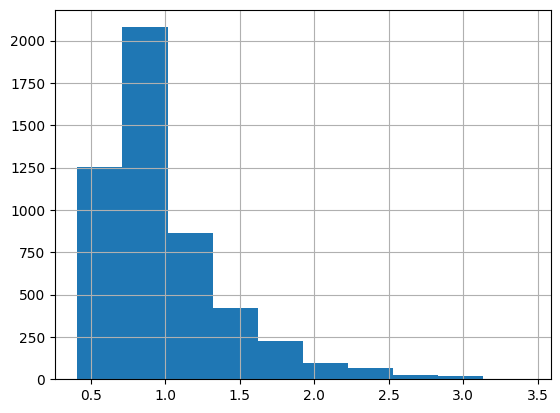

In [14]:
df.zweight_final.hist()

## exploring the clustering

In [16]:
from statsmodels.sandbox.tools import pca


df_temp = df[df[cluster_cols].isna().sum(axis=1)<10].copy()

xred, fact, eva, eve = pca((df_temp[cluster_cols] == 'yes').astype(float), keepdim=2, normalize=True)


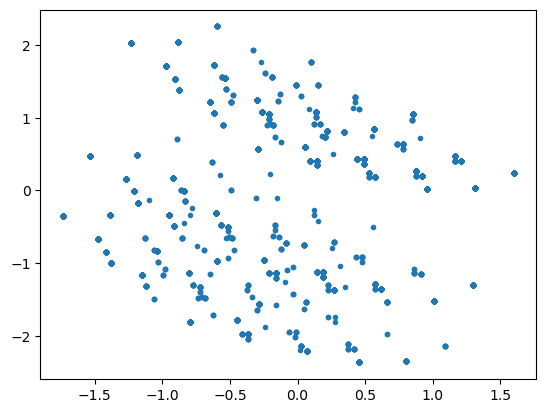

In [17]:
plt.plot(fact[:,0], fact[:,1], ".")

In [19]:
#how many missing answers
4879 - df_temp[cluster_cols].isna().sum()

Y_6_7_Reach_out_988                  4843
Y_6_7_Reach_out_OTHER_crisisline     4848
Y_6_7_Reach_out_MH_prof              4846
Y_6_7_Reach_out_friend_fam           4846
Y_6_7_Reach_out_religious_network    4841
N_1_2_Reach_out_988                  4843
N_1_2_Reach_out_OTHER_crisisline     4848
N_1_2_Reach_out_MH_prof              4846
N_1_2_Reach_out_friend_fam           4846
N_1_2_Reach_out_religious_network    4841
dtype: int64

<Axes: >

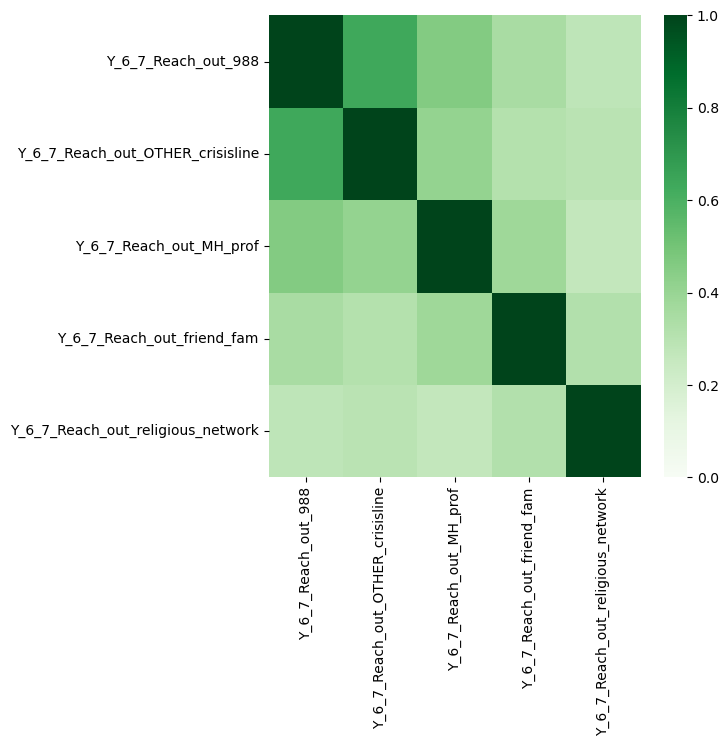

In [21]:
#correlation matrix (yes with yes)
plt.figure(figsize=(6,6))
sns.heatmap((df_temp[cluster_cols] == 'yes').corr().iloc[0:5,0:5], vmin=0, vmax=1, cmap='Greens')

<Axes: >

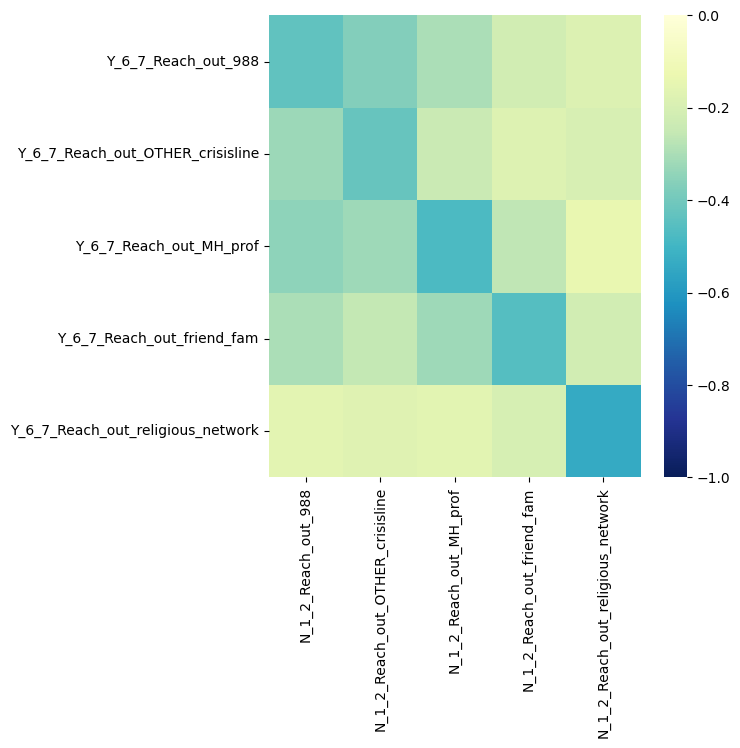

In [22]:
#correlation matrix (yes with no)
plt.figure(figsize=(6,6))
sns.heatmap((df_temp[cluster_cols] == 'yes').corr().iloc[0:5,5:10], vmin=-1, vmax=0, cmap='YlGnBu_r')

In [15]:
from stepmix.stepmix import StepMix
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [17]:
df_cluster = (df_study[cluster_cols] == 'yes').astype(int)

model = StepMix(n_components=5, n_steps = 1, measurement="binary_nan", verbose=1, random_state=6012) 

# Fit model
model.fit(df_cluster)

# Class predictions
df_study['binary_pred'] = model.predict(df_cluster)

Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.75it/s, max_LL=-2.26e+4,

MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0733  0.9572  0.9542  0.0000  0.0634
                N_1_2_Reach_out_MH_prof               0.1057  0.8780  0.4191  0.0065  0.1263
                N_1_2_Reach_out_OTHER_crisisline      0.1967  0.9685  0.9821  0.0274  0.2900
                N_1_2_Reach_out_friend_fam            0.0475  0.7764  0.0000  0.0093  0.0953
                N_1_2_Reach_out_religious_network     0.0000  0.9311  0.5803  0.2622  1.0000
                Y_6_7_Reach_out_988                   0.1194  0.0000  0.0000  0.9307  0.2380
                Y_6_7_Reach_out_MH_prof               0.2613  0.0294  0.2205  0.8678  0.4051
                Y_6_7_Re

In [18]:
mm = model.get_mm_df()

mm.round(2)

/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1173: FutureWarning: The provided callable <function mean at 0x1065f47c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


class_no                                               0     1     2     3  \
model_name param variable                                                    
binary_nan pis   N_1_2_Reach_out_988                0.07  0.96  0.95  0.00   
                 N_1_2_Reach_out_MH_prof            0.11  0.88  0.42  0.01   
                 N_1_2_Reach_out_OTHER_crisisline   0.20  0.97  0.98  0.03   
                 N_1_2_Reach_out_friend_fam         0.05  0.78  0.00  0.01   
                 N_1_2_Reach_out_religious_network  0.00  0.93  0.58  0.26   
                 Y_6_7_Reach_out_988                0.12  0.00  0.00  0.93   
                 Y_6_7_Reach_out_MH_prof            0.26  0.03  0.22  0.87   
                 Y_6_7_Reach_out_OTHER_crisisline   0.05  0.00  0.00  0.80   
                 Y_6_7_Reach_out_friend_fam         0.44  0.00  0.63  0.87   
                 Y_6_7_Reach_out_religious_network  0.28  0.01  0.22  0.49   

class_no                                               4  
model_name param variable                                 
binary_nan pis   N_1_2_Reach_out_988                0.06  
                 N_1_2_Reach_out_MH_prof            0.13  
                 N_1_2_Reach_out_OTHER_crisisline   0.29  
                 N_1_2_Reach_out_friend_fam         0.10  
                 N_1_2_Reach_out_religious_network  1.00  
                 Y_6_7_Reach_out_988                0.24  
                 Y_6_7_Reach_out_MH_prof            0.41  
                 Y_6_7_Reach_out_OTHER_crisisline   0.09  
                 Y_6_7_Reach_out_friend_fam         0.48  
                 Y_6_7_Reach_out_religious_network  0.00

<Axes: xlabel='class_no', ylabel='model_name-param-variable'>

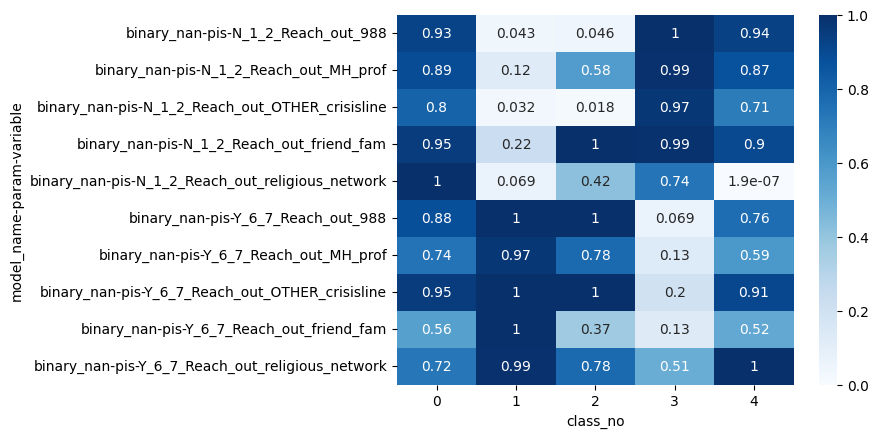

In [19]:
# Measurement parameters (heatmap)
sns.heatmap(1-mm, annot=True, vmin=0, vmax=1, cmap="Blues")

In [ ]:
pd.concat([pd.DataFrame(np.round((df_study[df_study.pred_cat == 0][cluster_cols]=='yes').mean()*100,1).astype(str) + '%', columns = ['Group 0']),
pd.DataFrame(np.round((df_study[df_study.pred_cat == 1][cluster_cols]=='yes').mean()*100,1).astype(str) + '%', columns = ['Group 1']),
pd.DataFrame(np.round((df_study[df_study.pred_cat == 2][cluster_cols]=='yes').mean()*100,1).astype(str) + '%', columns = ['Group 2']),
pd.DataFrame(np.round((df_study[df_study.pred_cat == 3][cluster_cols]=='yes').mean()*100,1).astype(str) + '%', columns = ['Group 3']),
pd.DataFrame(np.round((df_study[df_study.pred_cat == 4][cluster_cols]=='yes').mean()*100,1).astype(str) + '%', columns = ['Group 4'])], axis=1)

Text(0, 0.5, 'Principle Compontent 2')

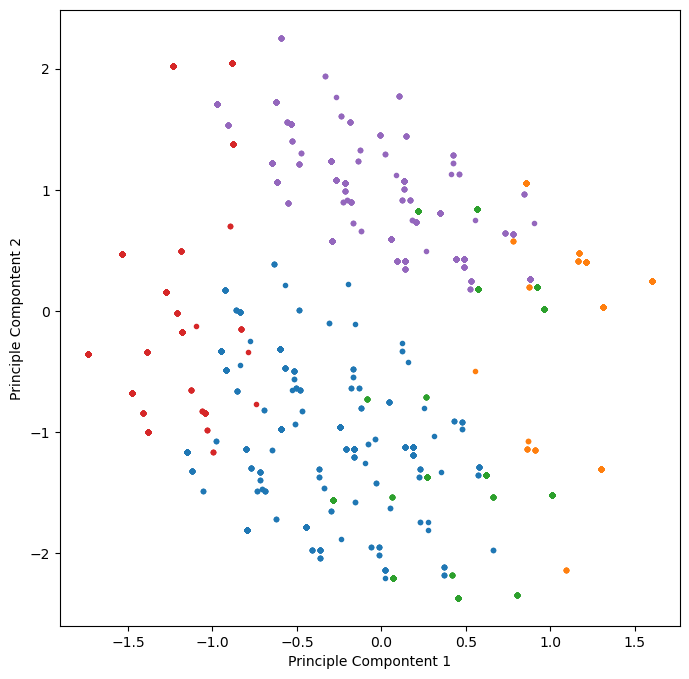

In [28]:
plt.figure(figsize=(8,8))

for ii in range(max(df_study.binary_pred)+1):
    plt.plot(fact[df_study.binary_pred==ii][:,0], fact[df_study.binary_pred==ii][:,1], ".")
    
plt.xlabel('Principle Compontent 1')
plt.ylabel('Principle Compontent 2')

## determining the optimal clustering

In [48]:
grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8],
    'n_steps': [1, 2, 3]
}
gs = GridSearchCV(estimator=model, cv=10, param_grid=grid)
gs.fit(df_cluster)

Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 37.01it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3090
                N_1_2_Reach_out_MH_prof               0.2408
                N_1_2_Reach_out_OTHER_crisisline      0.4144
                N_1_2_Reach_out_friend_fam            0.1354
                N_1_2_Reach_out_religious_network     0.5363
                Y_6_7_Reach_out_988                   0.2755
                Y_6_7_Reach_out_MH_prof               0.3822
                Y_6_7_Reach_out_OTHER_crisisline      0.1907
                Y_6_7_Reach_out_friend_fam            0.4972
                Y_6_7_Reach_out_religious_network     0.1982
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 42.24it/s, max_LL=-2.65e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.2883
                N_1_2_Reach_out_MH_prof               0.2198
                N_1_2_Reach_out_OTHER_crisisline      0.3942
                N_1_2_Reach_out_friend_fam            0.1514
                N_1_2_Reach_out_religious_network     0.5216
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3909
                Y_6_7_Reach_out_OTHER_crisisline      0.1976
                Y_6_7_Reach_out_friend_fam            0.5092
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 52.83it/s, max_LL=-2.7e+4, 
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3061
                N_1_2_Reach_out_MH_prof               0.2684
                N_1_2_Reach_out_OTHER_crisisline      0.4027
                N_1_2_Reach_out_friend_fam            0.1889
                N_1_2_Reach_out_religious_network     0.5354
                Y_6_7_Reach_out_988                   0.2808
                Y_6_7_Reach_out_MH_prof               0.3769
                Y_6_7_Reach_out_OTHER_crisisline      0.1973
                Y_6_7_Reach_out_friend_fam            0.4792
                Y_6_7_Reach_out_religious_network     0.2020
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 77.13it/s, max_LL=-2.74e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3492
                N_1_2_Reach_out_MH_prof               0.3074
                N_1_2_Reach_out_OTHER_crisisline      0.4149
                N_1_2_Reach_out_friend_fam            0.2069
                N_1_2_Reach_out_religious_network     0.5412
                Y_6_7_Reach_out_988                   0.2741
                Y_6_7_Reach_out_MH_prof               0.3649
                Y_6_7_Reach_out_OTHER_crisisline      0.1971
                Y_6_7_Reach_out_friend_fam            0.4597
                Y_6_7_Reach_out_religious_network     0.2027
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 43.44it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3860
                N_1_2_Reach_out_MH_prof               0.3170
                N_1_2_Reach_out_OTHER_crisisline      0.4748
                N_1_2_Reach_out_friend_fam            0.2135
                N_1_2_Reach_out_religious_network     0.5430
                Y_6_7_Reach_out_988                   0.2746
                Y_6_7_Reach_out_MH_prof               0.3569
                Y_6_7_Reach_out_OTHER_crisisline      0.1920
                Y_6_7_Reach_out_friend_fam            0.4824
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 54.16it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3989
                N_1_2_Reach_out_MH_prof               0.3290
                N_1_2_Reach_out_OTHER_crisisline      0.5054
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.5587
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3503
                Y_6_7_Reach_out_OTHER_crisisline      0.1893
                Y_6_7_Reach_out_friend_fam            0.4462
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 140.77it/s, max_LL=-2.73e+4
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3222
                N_1_2_Reach_out_OTHER_crisisline      0.4958
                N_1_2_Reach_out_friend_fam            0.2122
                N_1_2_Reach_out_religious_network     0.5985
                Y_6_7_Reach_out_988                   0.2501
                Y_6_7_Reach_out_MH_prof               0.3440
                Y_6_7_Reach_out_OTHER_crisisline      0.1784
                Y_6_7_Reach_out_friend_fam            0.4558
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 94.80it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3278
                N_1_2_Reach_out_OTHER_crisisline      0.5053
                N_1_2_Reach_out_friend_fam            0.2199
                N_1_2_Reach_out_religious_network     0.5577
                Y_6_7_Reach_out_988                   0.1711
                Y_6_7_Reach_out_MH_prof               0.3125
                Y_6_7_Reach_out_OTHER_crisisline      0.1329
                Y_6_7_Reach_out_friend_fam            0.4279
                Y_6_7_Reach_out_religious_network     0.1975
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 76.64it/s, max_LL=-2.53e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3864
                N_1_2_Reach_out_MH_prof               0.3162
                N_1_2_Reach_out_OTHER_crisisline      0.4922
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.1842
                Y_6_7_Reach_out_MH_prof               0.2980
                Y_6_7_Reach_out_OTHER_crisisline      0.1099
                Y_6_7_Reach_out_friend_fam            0.4057
                Y_6_7_Reach_out_religious_network     0.1076
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 59.40it/s, max_LL=-2.66e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3728
                N_1_2_Reach_out_MH_prof               0.3158
                N_1_2_Reach_out_OTHER_crisisline      0.4487
                N_1_2_Reach_out_friend_fam            0.2208
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.2643
                Y_6_7_Reach_out_MH_prof               0.3411
                Y_6_7_Reach_out_OTHER_crisisline      0.1926
                Y_6_7_Reach_out_friend_fam            0.4192
                Y_6_7_Reach_out_religious_network     0.1138
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 1-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 50.08it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3090
                N_1_2_Reach_out_MH_prof               0.2408
                N_1_2_Reach_out_OTHER_crisisline      0.4144
                N_1_2_Reach_out_friend_fam            0.1354
                N_1_2_Reach_out_religious_network     0.5363
                Y_6_7_Reach_out_988                   0.2755
                Y_6_7_Reach_out_MH_prof               0.3822
                Y_6_7_Reach_out_OTHER_crisisline      0.1907
                Y_6_7_Reach_out_friend_fam            0.4972
                Y_6_7_Reach_out_religious_network     0.1982
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 70.06it/s, max_LL=-2.65e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.2883
                N_1_2_Reach_out_MH_prof               0.2198
                N_1_2_Reach_out_OTHER_crisisline      0.3942
                N_1_2_Reach_out_friend_fam            0.1514
                N_1_2_Reach_out_religious_network     0.5216
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3909
                Y_6_7_Reach_out_OTHER_crisisline      0.1976
                Y_6_7_Reach_out_friend_fam            0.5092
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 99.90it/s, max_LL=-2.7e+4, 
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3061
                N_1_2_Reach_out_MH_prof               0.2684
                N_1_2_Reach_out_OTHER_crisisline      0.4027
                N_1_2_Reach_out_friend_fam            0.1889
                N_1_2_Reach_out_religious_network     0.5354
                Y_6_7_Reach_out_988                   0.2808
                Y_6_7_Reach_out_MH_prof               0.3769
                Y_6_7_Reach_out_OTHER_crisisline      0.1973
                Y_6_7_Reach_out_friend_fam            0.4792
                Y_6_7_Reach_out_religious_network     0.2020
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 72.70it/s, max_LL=-2.74e+4,

MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3492
                N_1_2_Reach_out_MH_prof               0.3074
                N_1_2_Reach_out_OTHER_crisisline      0.4149
                N_1_2_Reach_out_friend_fam            0.2069
                N_1_2_Reach_out_religious_network     0.5412
                Y_6_7_Reach_out_988                   0.2741
                Y_6_7_Reach_out_MH_prof               0.3649
                Y_6_7_Reach_out_OTHER_crisisline      0.1971
                Y_6_7_Reach_out_friend_fam            0.4597
                Y_6_7_Reach_out_religious_network     0.2027
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num


/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 52.07it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3860
                N_1_2_Reach_out_MH_prof               0.3170
                N_1_2_Reach_out_OTHER_crisisline      0.4748
                N_1_2_Reach_out_friend_fam            0.2135
                N_1_2_Reach_out_religious_network     0.5430
                Y_6_7_Reach_out_988                   0.2746
                Y_6_7_Reach_out_MH_prof               0.3569
                Y_6_7_Reach_out_OTHER_crisisline      0.1920
                Y_6_7_Reach_out_friend_fam            0.4824
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 65.76it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3989
                N_1_2_Reach_out_MH_prof               0.3290
                N_1_2_Reach_out_OTHER_crisisline      0.5054
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.5587
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3503
                Y_6_7_Reach_out_OTHER_crisisline      0.1893
                Y_6_7_Reach_out_friend_fam            0.4462
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4505
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 96.86it/s, max_LL=-2.73e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3222
                N_1_2_Reach_out_OTHER_crisisline      0.4958
                N_1_2_Reach_out_friend_fam            0.2122
                N_1_2_Reach_out_religious_network     0.5985
                Y_6_7_Reach_out_988                   0.2501
                Y_6_7_Reach_out_MH_prof               0.3440
                Y_6_7_Reach_out_OTHER_crisisline      0.1784
                Y_6_7_Reach_out_friend_fam            0.4558
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 70.95it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3278
                N_1_2_Reach_out_OTHER_crisisline      0.5053
                N_1_2_Reach_out_friend_fam            0.2199
                N_1_2_Reach_out_religious_network     0.5577
                Y_6_7_Reach_out_988                   0.1711
                Y_6_7_Reach_out_MH_prof               0.3125
                Y_6_7_Reach_out_OTHER_crisisline      0.1329
                Y_6_7_Reach_out_friend_fam            0.4279
                Y_6_7_Reach_out_religious_network     0.1975
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 76.69it/s, max_LL=-2.53e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3864
                N_1_2_Reach_out_MH_prof               0.3162
                N_1_2_Reach_out_OTHER_crisisline      0.4922
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.1842
                Y_6_7_Reach_out_MH_prof               0.2980
                Y_6_7_Reach_out_OTHER_crisisline      0.1099
                Y_6_7_Reach_out_friend_fam            0.4057
                Y_6_7_Reach_out_religious_network     0.1076
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 42.24it/s, max_LL=-2.66e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3728
                N_1_2_Reach_out_MH_prof               0.3158
                N_1_2_Reach_out_OTHER_crisisline      0.4487
                N_1_2_Reach_out_friend_fam            0.2208
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.2643
                Y_6_7_Reach_out_MH_prof               0.3411
                Y_6_7_Reach_out_OTHER_crisisline      0.1926
                Y_6_7_Reach_out_friend_fam            0.4192
                Y_6_7_Reach_out_religious_network     0.1138
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 2-step
    Number of observations        : 4506
    Num

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 72.72it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3090
                N_1_2_Reach_out_MH_prof               0.2408
                N_1_2_Reach_out_OTHER_crisisline      0.4144
                N_1_2_Reach_out_friend_fam            0.1354
                N_1_2_Reach_out_religious_network     0.5363
                Y_6_7_Reach_out_988                   0.2755
                Y_6_7_Reach_out_MH_prof               0.3822
                Y_6_7_Reach_out_OTHER_crisisline      0.1907
                Y_6_7_Reach_out_friend_fam            0.4972
                Y_6_7_Reach_out_religious_network     0.1982
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 54.44it/s, max_LL=-2.65e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.2883
                N_1_2_Reach_out_MH_prof               0.2198
                N_1_2_Reach_out_OTHER_crisisline      0.3942
                N_1_2_Reach_out_friend_fam            0.1514
                N_1_2_Reach_out_religious_network     0.5216
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3909
                Y_6_7_Reach_out_OTHER_crisisline      0.1976
                Y_6_7_Reach_out_friend_fam            0.5092
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 44.99it/s, max_LL=-2.7e+4, 
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3061
                N_1_2_Reach_out_MH_prof               0.2684
                N_1_2_Reach_out_OTHER_crisisline      0.4027
                N_1_2_Reach_out_friend_fam            0.1889
                N_1_2_Reach_out_religious_network     0.5354
                Y_6_7_Reach_out_988                   0.2808
                Y_6_7_Reach_out_MH_prof               0.3769
                Y_6_7_Reach_out_OTHER_crisisline      0.1973
                Y_6_7_Reach_out_friend_fam            0.4792
                Y_6_7_Reach_out_religious_network     0.2020
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 64.82it/s, max_LL=-2.74e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3492
                N_1_2_Reach_out_MH_prof               0.3074
                N_1_2_Reach_out_OTHER_crisisline      0.4149
                N_1_2_Reach_out_friend_fam            0.2069
                N_1_2_Reach_out_religious_network     0.5412
                Y_6_7_Reach_out_988                   0.2741
                Y_6_7_Reach_out_MH_prof               0.3649
                Y_6_7_Reach_out_OTHER_crisisline      0.1971
                Y_6_7_Reach_out_friend_fam            0.4597
                Y_6_7_Reach_out_religious_network     0.2027
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 57.77it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3860
                N_1_2_Reach_out_MH_prof               0.3170
                N_1_2_Reach_out_OTHER_crisisline      0.4748
                N_1_2_Reach_out_friend_fam            0.2135
                N_1_2_Reach_out_religious_network     0.5430
                Y_6_7_Reach_out_988                   0.2746
                Y_6_7_Reach_out_MH_prof               0.3569
                Y_6_7_Reach_out_OTHER_crisisline      0.1920
                Y_6_7_Reach_out_friend_fam            0.4824
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 72.13it/s, max_LL=-2.76e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3989
                N_1_2_Reach_out_MH_prof               0.3290
                N_1_2_Reach_out_OTHER_crisisline      0.5054
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.5587
                Y_6_7_Reach_out_988                   0.2821
                Y_6_7_Reach_out_MH_prof               0.3503
                Y_6_7_Reach_out_OTHER_crisisline      0.1893
                Y_6_7_Reach_out_friend_fam            0.4462
                Y_6_7_Reach_out_religious_network     0.2038
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 138.47it/s, max_LL=-2.73e+4
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3222
                N_1_2_Reach_out_OTHER_crisisline      0.4958
                N_1_2_Reach_out_friend_fam            0.2122
                N_1_2_Reach_out_religious_network     0.5985
                Y_6_7_Reach_out_988                   0.2501
                Y_6_7_Reach_out_MH_prof               0.3440
                Y_6_7_Reach_out_OTHER_crisisline      0.1784
                Y_6_7_Reach_out_friend_fam            0.4558
                Y_6_7_Reach_out_religious_network     0.2022
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 54.10it/s, max_LL=-2.64e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3995
                N_1_2_Reach_out_MH_prof               0.3278
                N_1_2_Reach_out_OTHER_crisisline      0.5053
                N_1_2_Reach_out_friend_fam            0.2199
                N_1_2_Reach_out_religious_network     0.5577
                Y_6_7_Reach_out_988                   0.1711
                Y_6_7_Reach_out_MH_prof               0.3125
                Y_6_7_Reach_out_OTHER_crisisline      0.1329
                Y_6_7_Reach_out_friend_fam            0.4279
                Y_6_7_Reach_out_religious_network     0.1975
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 57.51it/s, max_LL=-2.53e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3864
                N_1_2_Reach_out_MH_prof               0.3162
                N_1_2_Reach_out_OTHER_crisisline      0.4922
                N_1_2_Reach_out_friend_fam            0.2213
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.1842
                Y_6_7_Reach_out_MH_prof               0.2980
                Y_6_7_Reach_out_OTHER_crisisline      0.1099
                Y_6_7_Reach_out_friend_fam            0.4057
                Y_6_7_Reach_out_religious_network     0.1076
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 50.00it/s, max_LL=-2.66e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan
          class_no                                         0
          param variable                                    
          pis   N_1_2_Reach_out_988                   0.3728
                N_1_2_Reach_out_MH_prof               0.3158
                N_1_2_Reach_out_OTHER_crisisline      0.4487
                N_1_2_Reach_out_friend_fam            0.2208
                N_1_2_Reach_out_religious_network     0.6274
                Y_6_7_Reach_out_988                   0.2643
                Y_6_7_Reach_out_MH_prof               0.3411
                Y_6_7_Reach_out_OTHER_crisisline      0.1926
                Y_6_7_Reach_out_friend_fam            0.4192
                Y_6_7_Reach_out_religious_network     0.1138
    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : None
    Ass

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.08it/s, max_LL=-2.29e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0196  0.7354
                N_1_2_Reach_out_MH_prof               0.0457  0.5283
                N_1_2_Reach_out_OTHER_crisisline      0.1155  0.8549
                N_1_2_Reach_out_friend_fam            0.0345  0.2841
                N_1_2_Reach_out_religious_network     0.4101  0.7223
                Y_6_7_Reach_out_988                   0.4539  0.0125
                Y_6_7_Reach_out_MH_prof               0.5506  0.1341
                Y_6_7_Reach_out_OTHER_crisisline      0.3194  0.0010
                Y_6_7_Reach_out_friend_fam            0.6317  0.2991
                Y_6_7_Reach_out_religious_network     0.2646  0.1004
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.11it/s, max_LL=-2.31e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0175  0.6881
                N_1_2_Reach_out_MH_prof               0.0432  0.4804
                N_1_2_Reach_out_OTHER_crisisline      0.1079  0.8169
                N_1_2_Reach_out_friend_fam            0.0300  0.3306
                N_1_2_Reach_out_religious_network     0.3984  0.7036
                Y_6_7_Reach_out_988                   0.4620  0.0166
                Y_6_7_Reach_out_MH_prof               0.5568  0.1460
                Y_6_7_Reach_out_OTHER_crisisline      0.3304  0.0014
                Y_6_7_Reach_out_friend_fam            0.6379  0.3193
                Y_6_7_Reach_out_religious_network     0.2694  0.1070
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 10.93it/s, max_LL=-2.2e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1363  0.9987
                N_1_2_Reach_out_MH_prof               0.0921  0.9874
                N_1_2_Reach_out_OTHER_crisisline      0.2568  0.9973
                N_1_2_Reach_out_friend_fam            0.0428  0.7848
                N_1_2_Reach_out_religious_network     0.4290  0.9694
                Y_6_7_Reach_out_988                   0.3497  0.0000
                Y_6_7_Reach_out_MH_prof               0.4693  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.2457  0.0000
                Y_6_7_Reach_out_friend_fam            0.5968  0.0000
                Y_6_7_Reach_out_religious_network     0.2515  0.0000
    Class weights
        Class 1 : 0.80
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 28.77it/s, max_LL=-2.15e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0615  0.9366
                N_1_2_Reach_out_MH_prof               0.0534  0.8261
                N_1_2_Reach_out_OTHER_crisisline      0.1453  0.9653
                N_1_2_Reach_out_friend_fam            0.0290  0.5701
                N_1_2_Reach_out_religious_network     0.3835  0.8632
                Y_6_7_Reach_out_988                   0.4065  0.0038
                Y_6_7_Reach_out_MH_prof               0.5237  0.0408
                Y_6_7_Reach_out_OTHER_crisisline      0.2934  0.0005
                Y_6_7_Reach_out_friend_fam            0.6225  0.1273
                Y_6_7_Reach_out_religious_network     0.2739  0.0572
    Class weights
        Class 1 : 0.67
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 19.88it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0294  0.8394
                N_1_2_Reach_out_MH_prof               0.0422  0.6663
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9285
                N_1_2_Reach_out_friend_fam            0.0262  0.4516
                N_1_2_Reach_out_religious_network     0.3345  0.8080
                Y_6_7_Reach_out_988                   0.4830  0.0097
                Y_6_7_Reach_out_MH_prof               0.5665  0.0905
                Y_6_7_Reach_out_OTHER_crisisline      0.3426  0.0006
                Y_6_7_Reach_out_friend_fam            0.6900  0.2184
                Y_6_7_Reach_out_religious_network     0.3045  0.0722
    Class weights
        Class 1 : 0.56
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  8.90it/s, max_LL=-2.26e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0475  0.7853
                N_1_2_Reach_out_MH_prof               0.0571  0.6279
                N_1_2_Reach_out_OTHER_crisisline      0.1696  0.8747
                N_1_2_Reach_out_friend_fam            0.0376  0.4233
                N_1_2_Reach_out_religious_network     0.3438  0.7950
                Y_6_7_Reach_out_988                   0.5315  0.0079
                Y_6_7_Reach_out_MH_prof               0.5870  0.0899
                Y_6_7_Reach_out_OTHER_crisisline      0.3610  0.0006
                Y_6_7_Reach_out_friend_fam            0.6544  0.2172
                Y_6_7_Reach_out_religious_network     0.3318  0.0630
    Class weights
        Class 1 : 0.52
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.79it/s, max_LL=-2.23e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0553  0.7964
                N_1_2_Reach_out_MH_prof               0.0441  0.6430
                N_1_2_Reach_out_OTHER_crisisline      0.1590  0.8841
                N_1_2_Reach_out_friend_fam            0.0176  0.4365
                N_1_2_Reach_out_religious_network     0.4294  0.7935
                Y_6_7_Reach_out_988                   0.4591  0.0091
                Y_6_7_Reach_out_MH_prof               0.5683  0.0853
                Y_6_7_Reach_out_OTHER_crisisline      0.3326  0.0006
                Y_6_7_Reach_out_friend_fam            0.6678  0.2114
                Y_6_7_Reach_out_religious_network     0.3226  0.0632
    Class weights
        Class 1 : 0.54
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.31it/s, max_LL=-2.21e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1030  0.8965
                N_1_2_Reach_out_MH_prof               0.0817  0.7403
                N_1_2_Reach_out_OTHER_crisisline      0.2398  0.9505
                N_1_2_Reach_out_friend_fam            0.0467  0.5104
                N_1_2_Reach_out_religious_network     0.3831  0.8505
                Y_6_7_Reach_out_988                   0.2708  0.0039
                Y_6_7_Reach_out_MH_prof               0.4655  0.0558
                Y_6_7_Reach_out_OTHER_crisisline      0.2121  0.0002
                Y_6_7_Reach_out_friend_fam            0.5818  0.1698
                Y_6_7_Reach_out_religious_network     0.2913  0.0403
    Class weights
        Class 1 : 0.63
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 14.28it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.9295  0.1201
                N_1_2_Reach_out_MH_prof               0.7823  0.0877
                N_1_2_Reach_out_OTHER_crisisline      0.9667  0.2596
                N_1_2_Reach_out_friend_fam            0.5641  0.0532
                N_1_2_Reach_out_religious_network     0.8920  0.4976
                Y_6_7_Reach_out_988                   0.0019  0.2736
                Y_6_7_Reach_out_MH_prof               0.0400  0.4246
                Y_6_7_Reach_out_OTHER_crisisline      0.0000  0.1637
                Y_6_7_Reach_out_friend_fam            0.1354  0.5382
                Y_6_7_Reach_out_religious_network     0.0065  0.1572
    Class weights
        Class 1 : 0.33
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 13.57it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0187  0.8351
                N_1_2_Reach_out_MH_prof               0.0471  0.6666
                N_1_2_Reach_out_OTHER_crisisline      0.0939  0.9119
                N_1_2_Reach_out_friend_fam            0.0419  0.4544
                N_1_2_Reach_out_religious_network     0.4759  0.8252
                Y_6_7_Reach_out_988                   0.4614  0.0071
                Y_6_7_Reach_out_MH_prof               0.5376  0.0846
                Y_6_7_Reach_out_OTHER_crisisline      0.3397  0.0006
                Y_6_7_Reach_out_friend_fam            0.5848  0.2031
                Y_6_7_Reach_out_religious_network     0.1720  0.0379
    Class weights
        Class 1 : 0.57
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  9.19it/s, max_LL=-2.29e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0196  0.7354
                N_1_2_Reach_out_MH_prof               0.0457  0.5283
                N_1_2_Reach_out_OTHER_crisisline      0.1155  0.8549
                N_1_2_Reach_out_friend_fam            0.0345  0.2841
                N_1_2_Reach_out_religious_network     0.4101  0.7223
                Y_6_7_Reach_out_988                   0.4539  0.0125
                Y_6_7_Reach_out_MH_prof               0.5506  0.1341
                Y_6_7_Reach_out_OTHER_crisisline      0.3194  0.0010
                Y_6_7_Reach_out_friend_fam            0.6317  0.2991
                Y_6_7_Reach_out_religious_network     0.2646  0.1004
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.55it/s, max_LL=-2.31e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0175  0.6881
                N_1_2_Reach_out_MH_prof               0.0432  0.4804
                N_1_2_Reach_out_OTHER_crisisline      0.1079  0.8169
                N_1_2_Reach_out_friend_fam            0.0300  0.3306
                N_1_2_Reach_out_religious_network     0.3984  0.7036
                Y_6_7_Reach_out_988                   0.4620  0.0166
                Y_6_7_Reach_out_MH_prof               0.5568  0.1460
                Y_6_7_Reach_out_OTHER_crisisline      0.3304  0.0014
                Y_6_7_Reach_out_friend_fam            0.6379  0.3193
                Y_6_7_Reach_out_religious_network     0.2694  0.1070
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 10.67it/s, max_LL=-2.2e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1363  0.9987
                N_1_2_Reach_out_MH_prof               0.0921  0.9874
                N_1_2_Reach_out_OTHER_crisisline      0.2568  0.9973
                N_1_2_Reach_out_friend_fam            0.0428  0.7848
                N_1_2_Reach_out_religious_network     0.4290  0.9694
                Y_6_7_Reach_out_988                   0.3497  0.0000
                Y_6_7_Reach_out_MH_prof               0.4693  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.2457  0.0000
                Y_6_7_Reach_out_friend_fam            0.5968  0.0000
                Y_6_7_Reach_out_religious_network     0.2515  0.0000
    Class weights
        Class 1 : 0.80
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 28.58it/s, max_LL=-2.15e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0615  0.9366
                N_1_2_Reach_out_MH_prof               0.0534  0.8261
                N_1_2_Reach_out_OTHER_crisisline      0.1453  0.9653
                N_1_2_Reach_out_friend_fam            0.0290  0.5701
                N_1_2_Reach_out_religious_network     0.3835  0.8632
                Y_6_7_Reach_out_988                   0.4065  0.0038
                Y_6_7_Reach_out_MH_prof               0.5237  0.0408
                Y_6_7_Reach_out_OTHER_crisisline      0.2934  0.0005
                Y_6_7_Reach_out_friend_fam            0.6225  0.1273
                Y_6_7_Reach_out_religious_network     0.2739  0.0572
    Class weights
        Class 1 : 0.67
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 19.40it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0294  0.8394
                N_1_2_Reach_out_MH_prof               0.0422  0.6663
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9285
                N_1_2_Reach_out_friend_fam            0.0262  0.4516
                N_1_2_Reach_out_religious_network     0.3345  0.8080
                Y_6_7_Reach_out_988                   0.4830  0.0097
                Y_6_7_Reach_out_MH_prof               0.5665  0.0905
                Y_6_7_Reach_out_OTHER_crisisline      0.3426  0.0006
                Y_6_7_Reach_out_friend_fam            0.6900  0.2184
                Y_6_7_Reach_out_religious_network     0.3045  0.0722
    Class weights
        Class 1 : 0.56
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  8.28it/s, max_LL=-2.26e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0475  0.7853
                N_1_2_Reach_out_MH_prof               0.0571  0.6279
                N_1_2_Reach_out_OTHER_crisisline      0.1696  0.8747
                N_1_2_Reach_out_friend_fam            0.0376  0.4233
                N_1_2_Reach_out_religious_network     0.3438  0.7950
                Y_6_7_Reach_out_988                   0.5315  0.0079
                Y_6_7_Reach_out_MH_prof               0.5870  0.0899
                Y_6_7_Reach_out_OTHER_crisisline      0.3610  0.0006
                Y_6_7_Reach_out_friend_fam            0.6544  0.2172
                Y_6_7_Reach_out_religious_network     0.3318  0.0630
    Class weights
        Class 1 : 0.52
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.20it/s, max_LL=-2.23e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0553  0.7964
                N_1_2_Reach_out_MH_prof               0.0441  0.6430
                N_1_2_Reach_out_OTHER_crisisline      0.1590  0.8841
                N_1_2_Reach_out_friend_fam            0.0176  0.4365
                N_1_2_Reach_out_religious_network     0.4294  0.7935
                Y_6_7_Reach_out_988                   0.4591  0.0091
                Y_6_7_Reach_out_MH_prof               0.5683  0.0853
                Y_6_7_Reach_out_OTHER_crisisline      0.3326  0.0006
                Y_6_7_Reach_out_friend_fam            0.6678  0.2114
                Y_6_7_Reach_out_religious_network     0.3226  0.0632
    Class weights
        Class 1 : 0.54
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.18it/s, max_LL=-2.21e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1030  0.8965
                N_1_2_Reach_out_MH_prof               0.0817  0.7403
                N_1_2_Reach_out_OTHER_crisisline      0.2398  0.9505
                N_1_2_Reach_out_friend_fam            0.0467  0.5104
                N_1_2_Reach_out_religious_network     0.3831  0.8505
                Y_6_7_Reach_out_988                   0.2708  0.0039
                Y_6_7_Reach_out_MH_prof               0.4655  0.0558
                Y_6_7_Reach_out_OTHER_crisisline      0.2121  0.0002
                Y_6_7_Reach_out_friend_fam            0.5818  0.1698
                Y_6_7_Reach_out_religious_network     0.2913  0.0403
    Class weights
        Class 1 : 0.63
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 15.03it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.9295  0.1201
                N_1_2_Reach_out_MH_prof               0.7823  0.0877
                N_1_2_Reach_out_OTHER_crisisline      0.9667  0.2596
                N_1_2_Reach_out_friend_fam            0.5641  0.0532
                N_1_2_Reach_out_religious_network     0.8920  0.4976
                Y_6_7_Reach_out_988                   0.0019  0.2736
                Y_6_7_Reach_out_MH_prof               0.0400  0.4246
                Y_6_7_Reach_out_OTHER_crisisline      0.0000  0.1637
                Y_6_7_Reach_out_friend_fam            0.1354  0.5382
                Y_6_7_Reach_out_religious_network     0.0065  0.1572
    Class weights
        Class 1 : 0.33
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 14.22it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0187  0.8351
                N_1_2_Reach_out_MH_prof               0.0471  0.6666
                N_1_2_Reach_out_OTHER_crisisline      0.0939  0.9119
                N_1_2_Reach_out_friend_fam            0.0419  0.4544
                N_1_2_Reach_out_religious_network     0.4759  0.8252
                Y_6_7_Reach_out_988                   0.4614  0.0071
                Y_6_7_Reach_out_MH_prof               0.5376  0.0846
                Y_6_7_Reach_out_OTHER_crisisline      0.3397  0.0006
                Y_6_7_Reach_out_friend_fam            0.5848  0.2031
                Y_6_7_Reach_out_religious_network     0.1720  0.0379
    Class weights
        Class 1 : 0.57
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  9.55it/s, max_LL=-2.29e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0196  0.7354
                N_1_2_Reach_out_MH_prof               0.0457  0.5283
                N_1_2_Reach_out_OTHER_crisisline      0.1155  0.8549
                N_1_2_Reach_out_friend_fam            0.0345  0.2841
                N_1_2_Reach_out_religious_network     0.4101  0.7223
                Y_6_7_Reach_out_988                   0.4539  0.0125
                Y_6_7_Reach_out_MH_prof               0.5506  0.1341
                Y_6_7_Reach_out_OTHER_crisisline      0.3194  0.0010
                Y_6_7_Reach_out_friend_fam            0.6317  0.2991
                Y_6_7_Reach_out_religious_network     0.2646  0.1004
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.71it/s, max_LL=-2.31e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0175  0.6881
                N_1_2_Reach_out_MH_prof               0.0432  0.4804
                N_1_2_Reach_out_OTHER_crisisline      0.1079  0.8169
                N_1_2_Reach_out_friend_fam            0.0300  0.3306
                N_1_2_Reach_out_religious_network     0.3984  0.7036
                Y_6_7_Reach_out_988                   0.4620  0.0166
                Y_6_7_Reach_out_MH_prof               0.5568  0.1460
                Y_6_7_Reach_out_OTHER_crisisline      0.3304  0.0014
                Y_6_7_Reach_out_friend_fam            0.6379  0.3193
                Y_6_7_Reach_out_religious_network     0.2694  0.1070
    Class weights
        Class 1 : 0.60
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 11.03it/s, max_LL=-2.2e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1363  0.9987
                N_1_2_Reach_out_MH_prof               0.0921  0.9874
                N_1_2_Reach_out_OTHER_crisisline      0.2568  0.9973
                N_1_2_Reach_out_friend_fam            0.0428  0.7848
                N_1_2_Reach_out_religious_network     0.4290  0.9694
                Y_6_7_Reach_out_988                   0.3497  0.0000
                Y_6_7_Reach_out_MH_prof               0.4693  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.2457  0.0000
                Y_6_7_Reach_out_friend_fam            0.5968  0.0000
                Y_6_7_Reach_out_religious_network     0.2515  0.0000
    Class weights
        Class 1 : 0.80
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 28.46it/s, max_LL=-2.15e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0615  0.9366
                N_1_2_Reach_out_MH_prof               0.0534  0.8261
                N_1_2_Reach_out_OTHER_crisisline      0.1453  0.9653
                N_1_2_Reach_out_friend_fam            0.0290  0.5701
                N_1_2_Reach_out_religious_network     0.3835  0.8632
                Y_6_7_Reach_out_988                   0.4065  0.0038
                Y_6_7_Reach_out_MH_prof               0.5237  0.0408
                Y_6_7_Reach_out_OTHER_crisisline      0.2934  0.0005
                Y_6_7_Reach_out_friend_fam            0.6225  0.1273
                Y_6_7_Reach_out_religious_network     0.2739  0.0572
    Class weights
        Class 1 : 0.67
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 19.50it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0294  0.8394
                N_1_2_Reach_out_MH_prof               0.0422  0.6663
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9285
                N_1_2_Reach_out_friend_fam            0.0262  0.4516
                N_1_2_Reach_out_religious_network     0.3345  0.8080
                Y_6_7_Reach_out_988                   0.4830  0.0097
                Y_6_7_Reach_out_MH_prof               0.5665  0.0905
                Y_6_7_Reach_out_OTHER_crisisline      0.3426  0.0006
                Y_6_7_Reach_out_friend_fam            0.6900  0.2184
                Y_6_7_Reach_out_religious_network     0.3045  0.0722
    Class weights
        Class 1 : 0.56
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  9.07it/s, max_LL=-2.26e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0475  0.7853
                N_1_2_Reach_out_MH_prof               0.0571  0.6279
                N_1_2_Reach_out_OTHER_crisisline      0.1696  0.8747
                N_1_2_Reach_out_friend_fam            0.0376  0.4233
                N_1_2_Reach_out_religious_network     0.3438  0.7950
                Y_6_7_Reach_out_988                   0.5315  0.0079
                Y_6_7_Reach_out_MH_prof               0.5870  0.0899
                Y_6_7_Reach_out_OTHER_crisisline      0.3610  0.0006
                Y_6_7_Reach_out_friend_fam            0.6544  0.2172
                Y_6_7_Reach_out_religious_network     0.3318  0.0630
    Class weights
        Class 1 : 0.52
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.99it/s, max_LL=-2.23e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0553  0.7964
                N_1_2_Reach_out_MH_prof               0.0441  0.6430
                N_1_2_Reach_out_OTHER_crisisline      0.1590  0.8841
                N_1_2_Reach_out_friend_fam            0.0176  0.4365
                N_1_2_Reach_out_religious_network     0.4294  0.7935
                Y_6_7_Reach_out_988                   0.4591  0.0091
                Y_6_7_Reach_out_MH_prof               0.5683  0.0853
                Y_6_7_Reach_out_OTHER_crisisline      0.3326  0.0006
                Y_6_7_Reach_out_friend_fam            0.6678  0.2114
                Y_6_7_Reach_out_religious_network     0.3226  0.0632
    Class weights
        Class 1 : 0.54
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.24it/s, max_LL=-2.21e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.1030  0.8965
                N_1_2_Reach_out_MH_prof               0.0817  0.7403
                N_1_2_Reach_out_OTHER_crisisline      0.2398  0.9505
                N_1_2_Reach_out_friend_fam            0.0467  0.5104
                N_1_2_Reach_out_religious_network     0.3831  0.8505
                Y_6_7_Reach_out_988                   0.2708  0.0039
                Y_6_7_Reach_out_MH_prof               0.4655  0.0558
                Y_6_7_Reach_out_OTHER_crisisline      0.2121  0.0002
                Y_6_7_Reach_out_friend_fam            0.5818  0.1698
                Y_6_7_Reach_out_religious_network     0.2913  0.0403
    Class weights
        Class 1 : 0.63
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 15.63it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.9295  0.1201
                N_1_2_Reach_out_MH_prof               0.7823  0.0877
                N_1_2_Reach_out_OTHER_crisisline      0.9667  0.2596
                N_1_2_Reach_out_friend_fam            0.5641  0.0532
                N_1_2_Reach_out_religious_network     0.8920  0.4976
                Y_6_7_Reach_out_988                   0.0019  0.2736
                Y_6_7_Reach_out_MH_prof               0.0400  0.4246
                Y_6_7_Reach_out_OTHER_crisisline      0.0000  0.1637
                Y_6_7_Reach_out_friend_fam            0.1354  0.5382
                Y_6_7_Reach_out_religious_network     0.0065  0.1572
    Class weights
        Class 1 : 0.33
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 13.47it/s, max_LL=-2.14e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan        
          class_no                                         0       1
          param variable                                            
          pis   N_1_2_Reach_out_988                   0.0187  0.8351
                N_1_2_Reach_out_MH_prof               0.0471  0.6666
                N_1_2_Reach_out_OTHER_crisisline      0.0939  0.9119
                N_1_2_Reach_out_friend_fam            0.0419  0.4544
                N_1_2_Reach_out_religious_network     0.4759  0.8252
                Y_6_7_Reach_out_988                   0.4614  0.0071
                Y_6_7_Reach_out_MH_prof               0.5376  0.0846
                Y_6_7_Reach_out_OTHER_crisisline      0.3397  0.0006
                Y_6_7_Reach_out_friend_fam            0.5848  0.2031
                Y_6_7_Reach_out_religious_network     0.1720  0.0379
    Class weights
        Class 1 : 0.57
        Class 2 

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.19it/s, max_LL=-2.17e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1106  0.0000  0.9239
                N_1_2_Reach_out_MH_prof               0.1028  0.0154  0.6762
                N_1_2_Reach_out_OTHER_crisisline      0.2880  0.0000  0.9643
                N_1_2_Reach_out_friend_fam            0.0617  0.0217  0.3631
                N_1_2_Reach_out_religious_network     0.4873  0.3219  0.7884
                Y_6_7_Reach_out_988                   0.1730  0.9329  0.0000
                Y_6_7_Reach_out_MH_prof               0.3589  0.8583  0.0825
                Y_6_7_Reach_out_OTHER_crisisline      0.0494  0.8364  0.0000
                Y_6_7_Reach_out_friend_fam            0.4901  0.8561  0.2507
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.89it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1355  0.0000  0.9173
                N_1_2_Reach_out_MH_prof               0.1078  0.0168  0.6731
                N_1_2_Reach_out_OTHER_crisisline      0.3095  0.0000  0.9548
                N_1_2_Reach_out_friend_fam            0.0581  0.0228  0.4923
                N_1_2_Reach_out_religious_network     0.4828  0.3183  0.7991
                Y_6_7_Reach_out_988                   0.1601  0.9184  0.0003
                Y_6_7_Reach_out_MH_prof               0.3515  0.8450  0.0749
                Y_6_7_Reach_out_OTHER_crisisline      0.0444  0.8237  0.0000
                Y_6_7_Reach_out_friend_fam            0.4877  0.8457  0.2567
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.19it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1893  0.0000  0.9995
                N_1_2_Reach_out_MH_prof               0.1196  0.0216  0.9902
                N_1_2_Reach_out_OTHER_crisisline      0.3552  0.0000  0.9979
                N_1_2_Reach_out_friend_fam            0.0490  0.0283  0.7875
                N_1_2_Reach_out_religious_network     0.4666  0.3315  0.9703
                Y_6_7_Reach_out_988                   0.1380  0.9087  0.0000
                Y_6_7_Reach_out_MH_prof               0.3306  0.8343  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0342  0.8050  0.0000
                Y_6_7_Reach_out_friend_fam            0.5069  0.8316  0.0000
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.63it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1085  0.0000  0.9450
                N_1_2_Reach_out_MH_prof               0.0770  0.0257  0.8439
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.0000  0.9709
                N_1_2_Reach_out_friend_fam            0.0296  0.0324  0.5922
                N_1_2_Reach_out_religious_network     0.4074  0.3327  0.8818
                Y_6_7_Reach_out_988                   0.1714  0.9347  0.0037
                Y_6_7_Reach_out_MH_prof               0.3810  0.8389  0.0331
                Y_6_7_Reach_out_OTHER_crisisline      0.0493  0.8506  0.0006
                Y_6_7_Reach_out_friend_fam            0.5234  0.8365  0.1177
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.52it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2042  0.0000  0.9279
                N_1_2_Reach_out_MH_prof               0.1190  0.0299  0.8084
                N_1_2_Reach_out_OTHER_crisisline      0.3760  0.0000  0.9651
                N_1_2_Reach_out_friend_fam            0.0408  0.0353  0.5889
                N_1_2_Reach_out_religious_network     0.3869  0.3533  0.9033
                Y_6_7_Reach_out_988                   0.1445  0.8887  0.0040
                Y_6_7_Reach_out_MH_prof               0.3457  0.8134  0.0353
                Y_6_7_Reach_out_OTHER_crisisline      0.0160  0.7866  0.0006
                Y_6_7_Reach_out_friend_fam            0.5678  0.8120  0.1182
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.99it/s, max_LL=-2.12e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2901  0.0000  0.9696
                N_1_2_Reach_out_MH_prof               0.1833  0.0195  0.8830
                N_1_2_Reach_out_OTHER_crisisline      0.4878  0.0300  0.9820
                N_1_2_Reach_out_friend_fam            0.0870  0.0253  0.6487
                N_1_2_Reach_out_religious_network     0.4814  0.3103  0.9315
                Y_6_7_Reach_out_988                   0.1237  0.8920  0.0000
                Y_6_7_Reach_out_MH_prof               0.2943  0.8196  0.0132
                Y_6_7_Reach_out_OTHER_crisisline      0.0283  0.7050  0.0000
                Y_6_7_Reach_out_friend_fam            0.4414  0.8263  0.0995
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.24s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2984  0.0002  0.9739
                N_1_2_Reach_out_MH_prof               0.1709  0.0075  0.9175
                N_1_2_Reach_out_OTHER_crisisline      0.4695  0.0311  0.9829
                N_1_2_Reach_out_friend_fam            0.0825  0.0051  0.6637
                N_1_2_Reach_out_religious_network     0.5698  0.3110  0.9246
                Y_6_7_Reach_out_988                   0.0704  0.8991  0.0000
                Y_6_7_Reach_out_MH_prof               0.2884  0.8298  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0233  0.6987  0.0000
                Y_6_7_Reach_out_friend_fam            0.4480  0.8587  0.0944
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.90it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2104  0.0025  0.9659
                N_1_2_Reach_out_MH_prof               0.1409  0.0000  0.8588
                N_1_2_Reach_out_OTHER_crisisline      0.3759  0.0377  0.9803
                N_1_2_Reach_out_friend_fam            0.0731  0.0000  0.6204
                N_1_2_Reach_out_religious_network     0.5083  0.0000  0.9080
                Y_6_7_Reach_out_988                   0.1060  0.8561  0.0000
                Y_6_7_Reach_out_MH_prof               0.3237  0.9167  0.0200
                Y_6_7_Reach_out_OTHER_crisisline      0.0570  0.7822  0.0000
                Y_6_7_Reach_out_friend_fam            0.4689  0.9483  0.1114
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.59it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1777  0.0000  0.9445
                N_1_2_Reach_out_MH_prof               0.1004  0.0641  0.8303
                N_1_2_Reach_out_OTHER_crisisline      0.3495  0.0000  0.9721
                N_1_2_Reach_out_friend_fam            0.0514  0.0719  0.6047
                N_1_2_Reach_out_religious_network     0.4594  0.7008  0.9116
                Y_6_7_Reach_out_988                   0.1336  0.8280  0.0026
                Y_6_7_Reach_out_MH_prof               0.3496  0.7008  0.0281
                Y_6_7_Reach_out_OTHER_crisisline      0.0303  0.7125  0.0004
                Y_6_7_Reach_out_friend_fam            0.4944  0.6893  0.1171
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.10it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1263  0.0000  0.9562
                N_1_2_Reach_out_MH_prof               0.1016  0.0165  0.8074
                N_1_2_Reach_out_OTHER_crisisline      0.2757  0.0000  0.9748
                N_1_2_Reach_out_friend_fam            0.0748  0.0216  0.5530
                N_1_2_Reach_out_religious_network     0.6078  0.3121  0.8517
                Y_6_7_Reach_out_988                   0.1496  0.9504  0.0000
                Y_6_7_Reach_out_MH_prof               0.3361  0.8457  0.0337
                Y_6_7_Reach_out_OTHER_crisisline      0.0530  0.8207  0.0000
                Y_6_7_Reach_out_friend_fam            0.4178  0.8352  0.1619
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.51it/s, max_LL=-2.17e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1106  0.0000  0.9239
                N_1_2_Reach_out_MH_prof               0.1028  0.0154  0.6762
                N_1_2_Reach_out_OTHER_crisisline      0.2880  0.0000  0.9643
                N_1_2_Reach_out_friend_fam            0.0617  0.0217  0.3631
                N_1_2_Reach_out_religious_network     0.4873  0.3219  0.7884
                Y_6_7_Reach_out_988                   0.1730  0.9329  0.0000
                Y_6_7_Reach_out_MH_prof               0.3589  0.8583  0.0825
                Y_6_7_Reach_out_OTHER_crisisline      0.0494  0.8364  0.0000
                Y_6_7_Reach_out_friend_fam            0.4901  0.8561  0.2507
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.69it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1355  0.0000  0.9173
                N_1_2_Reach_out_MH_prof               0.1078  0.0168  0.6731
                N_1_2_Reach_out_OTHER_crisisline      0.3095  0.0000  0.9548
                N_1_2_Reach_out_friend_fam            0.0581  0.0228  0.4923
                N_1_2_Reach_out_religious_network     0.4828  0.3183  0.7991
                Y_6_7_Reach_out_988                   0.1601  0.9184  0.0003
                Y_6_7_Reach_out_MH_prof               0.3515  0.8450  0.0749
                Y_6_7_Reach_out_OTHER_crisisline      0.0444  0.8237  0.0000
                Y_6_7_Reach_out_friend_fam            0.4877  0.8457  0.2567
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.02it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1893  0.0000  0.9995
                N_1_2_Reach_out_MH_prof               0.1196  0.0216  0.9902
                N_1_2_Reach_out_OTHER_crisisline      0.3552  0.0000  0.9979
                N_1_2_Reach_out_friend_fam            0.0490  0.0283  0.7875
                N_1_2_Reach_out_religious_network     0.4666  0.3315  0.9703
                Y_6_7_Reach_out_988                   0.1380  0.9087  0.0000
                Y_6_7_Reach_out_MH_prof               0.3306  0.8343  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0342  0.8050  0.0000
                Y_6_7_Reach_out_friend_fam            0.5069  0.8316  0.0000
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.63it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1085  0.0000  0.9450
                N_1_2_Reach_out_MH_prof               0.0770  0.0257  0.8439
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.0000  0.9709
                N_1_2_Reach_out_friend_fam            0.0296  0.0324  0.5922
                N_1_2_Reach_out_religious_network     0.4074  0.3327  0.8818
                Y_6_7_Reach_out_988                   0.1714  0.9347  0.0037
                Y_6_7_Reach_out_MH_prof               0.3810  0.8389  0.0331
                Y_6_7_Reach_out_OTHER_crisisline      0.0493  0.8506  0.0006
                Y_6_7_Reach_out_friend_fam            0.5234  0.8365  0.1177
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.58it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2042  0.0000  0.9279
                N_1_2_Reach_out_MH_prof               0.1190  0.0299  0.8084
                N_1_2_Reach_out_OTHER_crisisline      0.3760  0.0000  0.9651
                N_1_2_Reach_out_friend_fam            0.0408  0.0353  0.5889
                N_1_2_Reach_out_religious_network     0.3869  0.3533  0.9033
                Y_6_7_Reach_out_988                   0.1445  0.8887  0.0040
                Y_6_7_Reach_out_MH_prof               0.3457  0.8134  0.0353
                Y_6_7_Reach_out_OTHER_crisisline      0.0160  0.7866  0.0006
                Y_6_7_Reach_out_friend_fam            0.5678  0.8120  0.1182
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  5.07it/s, max_LL=-2.12e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2901  0.0000  0.9696
                N_1_2_Reach_out_MH_prof               0.1833  0.0195  0.8830
                N_1_2_Reach_out_OTHER_crisisline      0.4878  0.0300  0.9820
                N_1_2_Reach_out_friend_fam            0.0870  0.0253  0.6487
                N_1_2_Reach_out_religious_network     0.4814  0.3103  0.9315
                Y_6_7_Reach_out_988                   0.1237  0.8920  0.0000
                Y_6_7_Reach_out_MH_prof               0.2943  0.8196  0.0132
                Y_6_7_Reach_out_OTHER_crisisline      0.0283  0.7050  0.0000
                Y_6_7_Reach_out_friend_fam            0.4414  0.8263  0.0995
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.26s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2984  0.0002  0.9739
                N_1_2_Reach_out_MH_prof               0.1709  0.0075  0.9175
                N_1_2_Reach_out_OTHER_crisisline      0.4695  0.0311  0.9829
                N_1_2_Reach_out_friend_fam            0.0825  0.0051  0.6637
                N_1_2_Reach_out_religious_network     0.5698  0.3110  0.9246
                Y_6_7_Reach_out_988                   0.0704  0.8991  0.0000
                Y_6_7_Reach_out_MH_prof               0.2884  0.8298  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0233  0.6987  0.0000
                Y_6_7_Reach_out_friend_fam            0.4480  0.8587  0.0944
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.94it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2104  0.0025  0.9659
                N_1_2_Reach_out_MH_prof               0.1409  0.0000  0.8588
                N_1_2_Reach_out_OTHER_crisisline      0.3759  0.0377  0.9803
                N_1_2_Reach_out_friend_fam            0.0731  0.0000  0.6204
                N_1_2_Reach_out_religious_network     0.5083  0.0000  0.9080
                Y_6_7_Reach_out_988                   0.1060  0.8561  0.0000
                Y_6_7_Reach_out_MH_prof               0.3237  0.9167  0.0200
                Y_6_7_Reach_out_OTHER_crisisline      0.0570  0.7822  0.0000
                Y_6_7_Reach_out_friend_fam            0.4689  0.9483  0.1114
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.60it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1777  0.0000  0.9445
                N_1_2_Reach_out_MH_prof               0.1004  0.0641  0.8303
                N_1_2_Reach_out_OTHER_crisisline      0.3495  0.0000  0.9721
                N_1_2_Reach_out_friend_fam            0.0514  0.0719  0.6047
                N_1_2_Reach_out_religious_network     0.4594  0.7008  0.9116
                Y_6_7_Reach_out_988                   0.1336  0.8280  0.0026
                Y_6_7_Reach_out_MH_prof               0.3496  0.7008  0.0281
                Y_6_7_Reach_out_OTHER_crisisline      0.0303  0.7125  0.0004
                Y_6_7_Reach_out_friend_fam            0.4944  0.6893  0.1171
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.12it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1263  0.0000  0.9562
                N_1_2_Reach_out_MH_prof               0.1016  0.0165  0.8074
                N_1_2_Reach_out_OTHER_crisisline      0.2757  0.0000  0.9748
                N_1_2_Reach_out_friend_fam            0.0748  0.0216  0.5530
                N_1_2_Reach_out_religious_network     0.6078  0.3121  0.8517
                Y_6_7_Reach_out_988                   0.1496  0.9504  0.0000
                Y_6_7_Reach_out_MH_prof               0.3361  0.8457  0.0337
                Y_6_7_Reach_out_OTHER_crisisline      0.0530  0.8207  0.0000
                Y_6_7_Reach_out_friend_fam            0.4178  0.8352  0.1619
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.61it/s, max_LL=-2.17e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1106  0.0000  0.9239
                N_1_2_Reach_out_MH_prof               0.1028  0.0154  0.6762
                N_1_2_Reach_out_OTHER_crisisline      0.2880  0.0000  0.9643
                N_1_2_Reach_out_friend_fam            0.0617  0.0217  0.3631
                N_1_2_Reach_out_religious_network     0.4873  0.3219  0.7884
                Y_6_7_Reach_out_988                   0.1730  0.9329  0.0000
                Y_6_7_Reach_out_MH_prof               0.3589  0.8583  0.0825
                Y_6_7_Reach_out_OTHER_crisisline      0.0494  0.8364  0.0000
                Y_6_7_Reach_out_friend_fam            0.4901  0.8561  0.2507
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.97it/s, max_LL=-2.19e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1355  0.0000  0.9173
                N_1_2_Reach_out_MH_prof               0.1078  0.0168  0.6731
                N_1_2_Reach_out_OTHER_crisisline      0.3095  0.0000  0.9548
                N_1_2_Reach_out_friend_fam            0.0581  0.0228  0.4923
                N_1_2_Reach_out_religious_network     0.4828  0.3183  0.7991
                Y_6_7_Reach_out_988                   0.1601  0.9184  0.0003
                Y_6_7_Reach_out_MH_prof               0.3515  0.8450  0.0749
                Y_6_7_Reach_out_OTHER_crisisline      0.0444  0.8237  0.0000
                Y_6_7_Reach_out_friend_fam            0.4877  0.8457  0.2567
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.14it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1893  0.0000  0.9995
                N_1_2_Reach_out_MH_prof               0.1196  0.0216  0.9902
                N_1_2_Reach_out_OTHER_crisisline      0.3552  0.0000  0.9979
                N_1_2_Reach_out_friend_fam            0.0490  0.0283  0.7875
                N_1_2_Reach_out_religious_network     0.4666  0.3315  0.9703
                Y_6_7_Reach_out_988                   0.1380  0.9087  0.0000
                Y_6_7_Reach_out_MH_prof               0.3306  0.8343  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0342  0.8050  0.0000
                Y_6_7_Reach_out_friend_fam            0.5069  0.8316  0.0000
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.52it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1085  0.0000  0.9450
                N_1_2_Reach_out_MH_prof               0.0770  0.0257  0.8439
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.0000  0.9709
                N_1_2_Reach_out_friend_fam            0.0296  0.0324  0.5922
                N_1_2_Reach_out_religious_network     0.4074  0.3327  0.8818
                Y_6_7_Reach_out_988                   0.1714  0.9347  0.0037
                Y_6_7_Reach_out_MH_prof               0.3810  0.8389  0.0331
                Y_6_7_Reach_out_OTHER_crisisline      0.0493  0.8506  0.0006
                Y_6_7_Reach_out_friend_fam            0.5234  0.8365  0.1177
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.41it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2042  0.0000  0.9279
                N_1_2_Reach_out_MH_prof               0.1190  0.0299  0.8084
                N_1_2_Reach_out_OTHER_crisisline      0.3760  0.0000  0.9651
                N_1_2_Reach_out_friend_fam            0.0408  0.0353  0.5889
                N_1_2_Reach_out_religious_network     0.3869  0.3533  0.9033
                Y_6_7_Reach_out_988                   0.1445  0.8887  0.0040
                Y_6_7_Reach_out_MH_prof               0.3457  0.8134  0.0353
                Y_6_7_Reach_out_OTHER_crisisline      0.0160  0.7866  0.0006
                Y_6_7_Reach_out_friend_fam            0.5678  0.8120  0.1182
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.65it/s, max_LL=-2.12e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2901  0.0000  0.9696
                N_1_2_Reach_out_MH_prof               0.1833  0.0195  0.8830
                N_1_2_Reach_out_OTHER_crisisline      0.4878  0.0300  0.9820
                N_1_2_Reach_out_friend_fam            0.0870  0.0253  0.6487
                N_1_2_Reach_out_religious_network     0.4814  0.3103  0.9315
                Y_6_7_Reach_out_988                   0.1237  0.8920  0.0000
                Y_6_7_Reach_out_MH_prof               0.2943  0.8196  0.0132
                Y_6_7_Reach_out_OTHER_crisisline      0.0283  0.7050  0.0000
                Y_6_7_Reach_out_friend_fam            0.4414  0.8263  0.0995
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.27s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2984  0.0002  0.9739
                N_1_2_Reach_out_MH_prof               0.1709  0.0075  0.9175
                N_1_2_Reach_out_OTHER_crisisline      0.4695  0.0311  0.9829
                N_1_2_Reach_out_friend_fam            0.0825  0.0051  0.6637
                N_1_2_Reach_out_religious_network     0.5698  0.3110  0.9246
                Y_6_7_Reach_out_988                   0.0704  0.8991  0.0000
                Y_6_7_Reach_out_MH_prof               0.2884  0.8298  0.0000
                Y_6_7_Reach_out_OTHER_crisisline      0.0233  0.6987  0.0000
                Y_6_7_Reach_out_friend_fam            0.4480  0.8587  0.0944
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 11.76it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.2104  0.0025  0.9659
                N_1_2_Reach_out_MH_prof               0.1409  0.0000  0.8588
                N_1_2_Reach_out_OTHER_crisisline      0.3759  0.0377  0.9803
                N_1_2_Reach_out_friend_fam            0.0731  0.0000  0.6204
                N_1_2_Reach_out_religious_network     0.5083  0.0000  0.9080
                Y_6_7_Reach_out_988                   0.1060  0.8561  0.0000
                Y_6_7_Reach_out_MH_prof               0.3237  0.9167  0.0200
                Y_6_7_Reach_out_OTHER_crisisline      0.0570  0.7822  0.0000
                Y_6_7_Reach_out_friend_fam            0.4689  0.9483  0.1114
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.55it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1777  0.0000  0.9445
                N_1_2_Reach_out_MH_prof               0.1004  0.0641  0.8303
                N_1_2_Reach_out_OTHER_crisisline      0.3495  0.0000  0.9721
                N_1_2_Reach_out_friend_fam            0.0514  0.0719  0.6047
                N_1_2_Reach_out_religious_network     0.4594  0.7008  0.9116
                Y_6_7_Reach_out_988                   0.1336  0.8280  0.0026
                Y_6_7_Reach_out_MH_prof               0.3496  0.7008  0.0281
                Y_6_7_Reach_out_OTHER_crisisline      0.0303  0.7125  0.0004
                Y_6_7_Reach_out_friend_fam            0.4944  0.6893  0.1171
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 12.22it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                
          class_no                                         0       1       2
          param variable                                                    
          pis   N_1_2_Reach_out_988                   0.1263  0.0000  0.9562
                N_1_2_Reach_out_MH_prof               0.1016  0.0165  0.8074
                N_1_2_Reach_out_OTHER_crisisline      0.2757  0.0000  0.9748
                N_1_2_Reach_out_friend_fam            0.0748  0.0216  0.5530
                N_1_2_Reach_out_religious_network     0.6078  0.3121  0.8517
                Y_6_7_Reach_out_988                   0.1496  0.9504  0.0000
                Y_6_7_Reach_out_MH_prof               0.3361  0.8457  0.0337
                Y_6_7_Reach_out_OTHER_crisisline      0.0530  0.8207  0.0000
                Y_6_7_Reach_out_friend_fam            0.4178  0.8352  0.1619
                Y_6_7_Reach_ou

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.15it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0517  0.8980  0.9056  0.0025
                N_1_2_Reach_out_MH_prof               0.1019  0.7458  0.4251  0.0108
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.9444  0.9617  0.0266
                N_1_2_Reach_out_friend_fam            0.0640  0.5804  0.0000  0.0168
                N_1_2_Reach_out_religious_network     0.5060  0.8749  0.5558  0.3065
                Y_6_7_Reach_out_988                   0.1796  0.0054  0.0000  0.9158
                Y_6_7_Reach_out_MH_prof               0.3330  0.0586  0.2393  0.8688
                Y_6_7_Reach_out_OTHER_crisisline      0.0595  0.0010  0.0000  0.7871
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.37it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9309  0.8667  0.0037
                N_1_2_Reach_out_MH_prof               0.1120  0.8264  0.3809  0.0102
                N_1_2_Reach_out_OTHER_crisisline      0.2291  0.9381  0.9369  0.0328
                N_1_2_Reach_out_friend_fam            0.0687  1.0000  0.0000  0.0156
                N_1_2_Reach_out_religious_network     0.5094  0.9414  0.5632  0.2984
                Y_6_7_Reach_out_988                   0.1712  0.0081  0.0000  0.8911
                Y_6_7_Reach_out_MH_prof               0.3177  0.0652  0.2155  0.8585
                Y_6_7_Reach_out_OTHER_crisisline      0.0578  0.0017  0.0000  0.7602
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.17it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0530  0.9994  0.8290  0.0020
                N_1_2_Reach_out_MH_prof               0.1040  0.9888  0.2187  0.0116
                N_1_2_Reach_out_OTHER_crisisline      0.2296  0.9975  0.8827  0.0333
                N_1_2_Reach_out_friend_fam            0.0641  0.7878  0.0015  0.0166
                N_1_2_Reach_out_religious_network     0.5153  0.9698  0.3166  0.2980
                Y_6_7_Reach_out_988                   0.1693  0.0000  0.0000  0.8919
                Y_6_7_Reach_out_MH_prof               0.3168  0.0000  0.3308  0.8557
                Y_6_7_Reach_out_OTHER_crisisline      0.0556  0.0000  0.0087  0.7581
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  7.05it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0478  0.9441  0.3709  0.0000
                N_1_2_Reach_out_MH_prof               0.0615  0.8307  0.2375  0.0151
                N_1_2_Reach_out_OTHER_crisisline      0.1563  0.9716  0.5062  0.0000
                N_1_2_Reach_out_friend_fam            0.0367  0.6064  0.0285  0.0226
                N_1_2_Reach_out_religious_network     0.5252  0.9185  0.0000  0.3003
                Y_6_7_Reach_out_988                   0.1939  0.0038  0.1339  0.9397
                Y_6_7_Reach_out_MH_prof               0.3679  0.0410  0.3854  0.8549
                Y_6_7_Reach_out_OTHER_crisisline      0.0696  0.0006  0.0333  0.8544
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.20it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9319  0.8651  0.0071
                N_1_2_Reach_out_MH_prof               0.0780  0.9264  0.3926  0.0209
                N_1_2_Reach_out_OTHER_crisisline      0.1975  0.9607  0.9168  0.0000
                N_1_2_Reach_out_friend_fam            0.0495  0.7955  0.0819  0.0257
                N_1_2_Reach_out_religious_network     0.3955  0.9513  0.5922  0.3227
                Y_6_7_Reach_out_988                   0.2408  0.0060  0.0000  0.9105
                Y_6_7_Reach_out_MH_prof               0.3734  0.0000  0.2297  0.8426
                Y_6_7_Reach_out_OTHER_crisisline      0.0415  0.0010  0.0050  0.8670
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.31it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0607  0.9680  0.8886  0.0044
                N_1_2_Reach_out_MH_prof               0.1579  0.9379  0.3776  0.0084
                N_1_2_Reach_out_OTHER_crisisline      0.3099  0.9733  0.9270  0.0398
                N_1_2_Reach_out_friend_fam            0.1036  0.8014  0.0664  0.0131
                N_1_2_Reach_out_religious_network     0.4903  0.9513  0.5958  0.2835
                Y_6_7_Reach_out_988                   0.2096  0.0000  0.0000  0.8764
                Y_6_7_Reach_out_MH_prof               0.2814  0.0000  0.2462  0.8527
                Y_6_7_Reach_out_OTHER_crisisline      0.0591  0.0005  0.0000  0.7123
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.63it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0907  0.9647  0.9073  0.0048
                N_1_2_Reach_out_MH_prof               0.1386  0.8795  0.4146  0.0072
                N_1_2_Reach_out_OTHER_crisisline      0.2962  0.9715  0.9664  0.0365
                N_1_2_Reach_out_friend_fam            0.0804  0.7793  0.0000  0.0047
                N_1_2_Reach_out_religious_network     0.5972  0.9334  0.5580  0.2950
                Y_6_7_Reach_out_988                   0.1092  0.0004  0.0000  0.8943
                Y_6_7_Reach_out_MH_prof               0.2780  0.0301  0.2265  0.8417
                Y_6_7_Reach_out_OTHER_crisisline      0.0333  0.0005  0.0000  0.7106
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.98it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0616  0.9595  0.9063  0.0087
                N_1_2_Reach_out_MH_prof               0.1211  0.8768  0.4129  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.2521  0.9701  0.9542  0.0536
                N_1_2_Reach_out_friend_fam            0.0816  0.7778  0.0003  0.0000
                N_1_2_Reach_out_religious_network     0.5310  0.9333  0.5619  0.0000
                Y_6_7_Reach_out_988                   0.1274  0.0014  0.0000  0.8160
                Y_6_7_Reach_out_MH_prof               0.3115  0.0308  0.2234  0.9047
                Y_6_7_Reach_out_OTHER_crisisline      0.0697  0.0003  0.0000  0.7368
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.92it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0565  0.9499  0.8177  0.0000
                N_1_2_Reach_out_MH_prof               0.1001  0.9421  0.3247  0.0510
                N_1_2_Reach_out_OTHER_crisisline      0.1923  0.9663  0.9430  0.1160
                N_1_2_Reach_out_friend_fam            0.0541  0.8007  0.0850  0.0729
                N_1_2_Reach_out_religious_network     0.4127  0.9454  0.6837  0.7917
                Y_6_7_Reach_out_988                   0.1470  0.0053  0.0000  0.8876
                Y_6_7_Reach_out_MH_prof               0.3235  0.0000  0.2592  0.7548
                Y_6_7_Reach_out_OTHER_crisisline      0.0693  0.0009  0.0000  0.5990
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.55it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9697  0.9042  0.0000
                N_1_2_Reach_out_MH_prof               0.1006  0.9540  0.4872  0.0129
                N_1_2_Reach_out_OTHER_crisisline      0.2057  0.9731  0.9518  0.0000
                N_1_2_Reach_out_friend_fam            0.0814  0.8723  0.1007  0.0169
                N_1_2_Reach_out_religious_network     0.5950  0.9567  0.7142  0.3011
                Y_6_7_Reach_out_988                   0.1771  0.0011  0.0000  0.9568
                Y_6_7_Reach_out_MH_prof               0.3295  0.0000  0.1685  0.8561
                Y_6_7_Reach_out_OTHER_crisisline      0.0680  0.0007  0.0000  0.8305
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.13it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0517  0.8980  0.9056  0.0025
                N_1_2_Reach_out_MH_prof               0.1019  0.7458  0.4251  0.0108
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.9444  0.9617  0.0266
                N_1_2_Reach_out_friend_fam            0.0640  0.5804  0.0000  0.0168
                N_1_2_Reach_out_religious_network     0.5060  0.8749  0.5558  0.3065
                Y_6_7_Reach_out_988                   0.1796  0.0054  0.0000  0.9158
                Y_6_7_Reach_out_MH_prof               0.3330  0.0586  0.2393  0.8688
                Y_6_7_Reach_out_OTHER_crisisline      0.0595  0.0010  0.0000  0.7871
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.36it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9309  0.8667  0.0037
                N_1_2_Reach_out_MH_prof               0.1120  0.8264  0.3809  0.0102
                N_1_2_Reach_out_OTHER_crisisline      0.2291  0.9381  0.9369  0.0328
                N_1_2_Reach_out_friend_fam            0.0687  1.0000  0.0000  0.0156
                N_1_2_Reach_out_religious_network     0.5094  0.9414  0.5632  0.2984
                Y_6_7_Reach_out_988                   0.1712  0.0081  0.0000  0.8911
                Y_6_7_Reach_out_MH_prof               0.3177  0.0652  0.2155  0.8585
                Y_6_7_Reach_out_OTHER_crisisline      0.0578  0.0017  0.0000  0.7602
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.18it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0530  0.9994  0.8290  0.0020
                N_1_2_Reach_out_MH_prof               0.1040  0.9888  0.2187  0.0116
                N_1_2_Reach_out_OTHER_crisisline      0.2296  0.9975  0.8827  0.0333
                N_1_2_Reach_out_friend_fam            0.0641  0.7878  0.0015  0.0166
                N_1_2_Reach_out_religious_network     0.5153  0.9698  0.3166  0.2980
                Y_6_7_Reach_out_988                   0.1693  0.0000  0.0000  0.8919
                Y_6_7_Reach_out_MH_prof               0.3168  0.0000  0.3308  0.8557
                Y_6_7_Reach_out_OTHER_crisisline      0.0556  0.0000  0.0087  0.7581
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.91it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0478  0.9441  0.3709  0.0000
                N_1_2_Reach_out_MH_prof               0.0615  0.8307  0.2375  0.0151
                N_1_2_Reach_out_OTHER_crisisline      0.1563  0.9716  0.5062  0.0000
                N_1_2_Reach_out_friend_fam            0.0367  0.6064  0.0285  0.0226
                N_1_2_Reach_out_religious_network     0.5252  0.9185  0.0000  0.3003
                Y_6_7_Reach_out_988                   0.1939  0.0038  0.1339  0.9397
                Y_6_7_Reach_out_MH_prof               0.3679  0.0410  0.3854  0.8549
                Y_6_7_Reach_out_OTHER_crisisline      0.0696  0.0006  0.0333  0.8544
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.19it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9319  0.8651  0.0071
                N_1_2_Reach_out_MH_prof               0.0780  0.9264  0.3926  0.0209
                N_1_2_Reach_out_OTHER_crisisline      0.1975  0.9607  0.9168  0.0000
                N_1_2_Reach_out_friend_fam            0.0495  0.7955  0.0819  0.0257
                N_1_2_Reach_out_religious_network     0.3955  0.9513  0.5922  0.3227
                Y_6_7_Reach_out_988                   0.2408  0.0060  0.0000  0.9105
                Y_6_7_Reach_out_MH_prof               0.3734  0.0000  0.2297  0.8426
                Y_6_7_Reach_out_OTHER_crisisline      0.0415  0.0010  0.0050  0.8670
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.36it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0607  0.9680  0.8886  0.0044
                N_1_2_Reach_out_MH_prof               0.1579  0.9379  0.3776  0.0084
                N_1_2_Reach_out_OTHER_crisisline      0.3099  0.9733  0.9270  0.0398
                N_1_2_Reach_out_friend_fam            0.1036  0.8014  0.0664  0.0131
                N_1_2_Reach_out_religious_network     0.4903  0.9513  0.5958  0.2835
                Y_6_7_Reach_out_988                   0.2096  0.0000  0.0000  0.8764
                Y_6_7_Reach_out_MH_prof               0.2814  0.0000  0.2462  0.8527
                Y_6_7_Reach_out_OTHER_crisisline      0.0591  0.0005  0.0000  0.7123
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.58it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0907  0.9647  0.9073  0.0048
                N_1_2_Reach_out_MH_prof               0.1386  0.8795  0.4146  0.0072
                N_1_2_Reach_out_OTHER_crisisline      0.2962  0.9715  0.9664  0.0365
                N_1_2_Reach_out_friend_fam            0.0804  0.7793  0.0000  0.0047
                N_1_2_Reach_out_religious_network     0.5972  0.9334  0.5580  0.2950
                Y_6_7_Reach_out_988                   0.1092  0.0004  0.0000  0.8943
                Y_6_7_Reach_out_MH_prof               0.2780  0.0301  0.2265  0.8417
                Y_6_7_Reach_out_OTHER_crisisline      0.0333  0.0005  0.0000  0.7106
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.97it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0616  0.9595  0.9063  0.0087
                N_1_2_Reach_out_MH_prof               0.1211  0.8768  0.4129  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.2521  0.9701  0.9542  0.0536
                N_1_2_Reach_out_friend_fam            0.0816  0.7778  0.0003  0.0000
                N_1_2_Reach_out_religious_network     0.5310  0.9333  0.5619  0.0000
                Y_6_7_Reach_out_988                   0.1274  0.0014  0.0000  0.8160
                Y_6_7_Reach_out_MH_prof               0.3115  0.0308  0.2234  0.9047
                Y_6_7_Reach_out_OTHER_crisisline      0.0697  0.0003  0.0000  0.7368
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.89it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0565  0.9499  0.8177  0.0000
                N_1_2_Reach_out_MH_prof               0.1001  0.9421  0.3247  0.0510
                N_1_2_Reach_out_OTHER_crisisline      0.1923  0.9663  0.9430  0.1160
                N_1_2_Reach_out_friend_fam            0.0541  0.8007  0.0850  0.0729
                N_1_2_Reach_out_religious_network     0.4127  0.9454  0.6837  0.7917
                Y_6_7_Reach_out_988                   0.1470  0.0053  0.0000  0.8876
                Y_6_7_Reach_out_MH_prof               0.3235  0.0000  0.2592  0.7548
                Y_6_7_Reach_out_OTHER_crisisline      0.0693  0.0009  0.0000  0.5990
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.26it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9697  0.9042  0.0000
                N_1_2_Reach_out_MH_prof               0.1006  0.9540  0.4872  0.0129
                N_1_2_Reach_out_OTHER_crisisline      0.2057  0.9731  0.9518  0.0000
                N_1_2_Reach_out_friend_fam            0.0814  0.8723  0.1007  0.0169
                N_1_2_Reach_out_religious_network     0.5950  0.9567  0.7142  0.3011
                Y_6_7_Reach_out_988                   0.1771  0.0011  0.0000  0.9568
                Y_6_7_Reach_out_MH_prof               0.3295  0.0000  0.1685  0.8561
                Y_6_7_Reach_out_OTHER_crisisline      0.0680  0.0007  0.0000  0.8305
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.16it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0517  0.8980  0.9056  0.0025
                N_1_2_Reach_out_MH_prof               0.1019  0.7458  0.4251  0.0108
                N_1_2_Reach_out_OTHER_crisisline      0.2279  0.9444  0.9617  0.0266
                N_1_2_Reach_out_friend_fam            0.0640  0.5804  0.0000  0.0168
                N_1_2_Reach_out_religious_network     0.5060  0.8749  0.5558  0.3065
                Y_6_7_Reach_out_988                   0.1796  0.0054  0.0000  0.9158
                Y_6_7_Reach_out_MH_prof               0.3330  0.0586  0.2393  0.8688
                Y_6_7_Reach_out_OTHER_crisisline      0.0595  0.0010  0.0000  0.7871
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.36it/s, max_LL=-2.13e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9309  0.8667  0.0037
                N_1_2_Reach_out_MH_prof               0.1120  0.8264  0.3809  0.0102
                N_1_2_Reach_out_OTHER_crisisline      0.2291  0.9381  0.9369  0.0328
                N_1_2_Reach_out_friend_fam            0.0687  1.0000  0.0000  0.0156
                N_1_2_Reach_out_religious_network     0.5094  0.9414  0.5632  0.2984
                Y_6_7_Reach_out_988                   0.1712  0.0081  0.0000  0.8911
                Y_6_7_Reach_out_MH_prof               0.3177  0.0652  0.2155  0.8585
                Y_6_7_Reach_out_OTHER_crisisline      0.0578  0.0017  0.0000  0.7602
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.01it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0530  0.9994  0.8290  0.0020
                N_1_2_Reach_out_MH_prof               0.1040  0.9888  0.2187  0.0116
                N_1_2_Reach_out_OTHER_crisisline      0.2296  0.9975  0.8827  0.0333
                N_1_2_Reach_out_friend_fam            0.0641  0.7878  0.0015  0.0166
                N_1_2_Reach_out_religious_network     0.5153  0.9698  0.3166  0.2980
                Y_6_7_Reach_out_988                   0.1693  0.0000  0.0000  0.8919
                Y_6_7_Reach_out_MH_prof               0.3168  0.0000  0.3308  0.8557
                Y_6_7_Reach_out_OTHER_crisisline      0.0556  0.0000  0.0087  0.7581
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  6.59it/s, max_LL=-1.98e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0478  0.9441  0.3709  0.0000
                N_1_2_Reach_out_MH_prof               0.0615  0.8307  0.2375  0.0151
                N_1_2_Reach_out_OTHER_crisisline      0.1563  0.9716  0.5062  0.0000
                N_1_2_Reach_out_friend_fam            0.0367  0.6064  0.0285  0.0226
                N_1_2_Reach_out_religious_network     0.5252  0.9185  0.0000  0.3003
                Y_6_7_Reach_out_988                   0.1939  0.0038  0.1339  0.9397
                Y_6_7_Reach_out_MH_prof               0.3679  0.0410  0.3854  0.8549
                Y_6_7_Reach_out_OTHER_crisisline      0.0696  0.0006  0.0333  0.8544
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.13it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9319  0.8651  0.0071
                N_1_2_Reach_out_MH_prof               0.0780  0.9264  0.3926  0.0209
                N_1_2_Reach_out_OTHER_crisisline      0.1975  0.9607  0.9168  0.0000
                N_1_2_Reach_out_friend_fam            0.0495  0.7955  0.0819  0.0257
                N_1_2_Reach_out_religious_network     0.3955  0.9513  0.5922  0.3227
                Y_6_7_Reach_out_988                   0.2408  0.0060  0.0000  0.9105
                Y_6_7_Reach_out_MH_prof               0.3734  0.0000  0.2297  0.8426
                Y_6_7_Reach_out_OTHER_crisisline      0.0415  0.0010  0.0050  0.8670
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.08it/s, max_LL=-2.08e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0607  0.9680  0.8886  0.0044
                N_1_2_Reach_out_MH_prof               0.1579  0.9379  0.3776  0.0084
                N_1_2_Reach_out_OTHER_crisisline      0.3099  0.9733  0.9270  0.0398
                N_1_2_Reach_out_friend_fam            0.1036  0.8014  0.0664  0.0131
                N_1_2_Reach_out_religious_network     0.4903  0.9513  0.5958  0.2835
                Y_6_7_Reach_out_988                   0.2096  0.0000  0.0000  0.8764
                Y_6_7_Reach_out_MH_prof               0.2814  0.0000  0.2462  0.8527
                Y_6_7_Reach_out_OTHER_crisisline      0.0591  0.0005  0.0000  0.7123
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.45it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0907  0.9647  0.9073  0.0048
                N_1_2_Reach_out_MH_prof               0.1386  0.8795  0.4146  0.0072
                N_1_2_Reach_out_OTHER_crisisline      0.2962  0.9715  0.9664  0.0365
                N_1_2_Reach_out_friend_fam            0.0804  0.7793  0.0000  0.0047
                N_1_2_Reach_out_religious_network     0.5972  0.9334  0.5580  0.2950
                Y_6_7_Reach_out_988                   0.1092  0.0004  0.0000  0.8943
                Y_6_7_Reach_out_MH_prof               0.2780  0.0301  0.2265  0.8417
                Y_6_7_Reach_out_OTHER_crisisline      0.0333  0.0005  0.0000  0.7106
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.98it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0616  0.9595  0.9063  0.0087
                N_1_2_Reach_out_MH_prof               0.1211  0.8768  0.4129  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.2521  0.9701  0.9542  0.0536
                N_1_2_Reach_out_friend_fam            0.0816  0.7778  0.0003  0.0000
                N_1_2_Reach_out_religious_network     0.5310  0.9333  0.5619  0.0000
                Y_6_7_Reach_out_988                   0.1274  0.0014  0.0000  0.8160
                Y_6_7_Reach_out_MH_prof               0.3115  0.0308  0.2234  0.9047
                Y_6_7_Reach_out_OTHER_crisisline      0.0697  0.0003  0.0000  0.7368
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.93it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0565  0.9499  0.8177  0.0000
                N_1_2_Reach_out_MH_prof               0.1001  0.9421  0.3247  0.0510
                N_1_2_Reach_out_OTHER_crisisline      0.1923  0.9663  0.9430  0.1160
                N_1_2_Reach_out_friend_fam            0.0541  0.8007  0.0850  0.0729
                N_1_2_Reach_out_religious_network     0.4127  0.9454  0.6837  0.7917
                Y_6_7_Reach_out_988                   0.1470  0.0053  0.0000  0.8876
                Y_6_7_Reach_out_MH_prof               0.3235  0.0000  0.2592  0.7548
                Y_6_7_Reach_out_OTHER_crisisline      0.0693  0.0009  0.0000  0.5990
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.49it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                        
          class_no                                         0       1       2       3
          param variable                                                            
          pis   N_1_2_Reach_out_988                   0.0509  0.9697  0.9042  0.0000
                N_1_2_Reach_out_MH_prof               0.1006  0.9540  0.4872  0.0129
                N_1_2_Reach_out_OTHER_crisisline      0.2057  0.9731  0.9518  0.0000
                N_1_2_Reach_out_friend_fam            0.0814  0.8723  0.1007  0.0169
                N_1_2_Reach_out_religious_network     0.5950  0.9567  0.7142  0.3011
                Y_6_7_Reach_out_988                   0.1771  0.0011  0.0000  0.9568
                Y_6_7_Reach_out_MH_prof               0.3295  0.0000  0.1685  0.8561
                Y_6_7_Reach_out_OTHER_crisisline      0.0680  0.0007  0.0000  0.8305
                Y_6

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.93it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0564  0.9075  0.9577  0.0000  0.0653
                N_1_2_Reach_out_MH_prof               0.1188  0.7479  0.4318  0.0063  0.0980
                N_1_2_Reach_out_OTHER_crisisline      0.2767  0.9468  0.9872  0.0240  0.1940
                N_1_2_Reach_out_friend_fam            0.0904  0.5735  0.0000  0.0090  0.0429
                N_1_2_Reach_out_religious_network     1.0000  0.8699  0.5685  0.2638  0.0000
                Y_6_7_Reach_out_988                   0.2510  0.0000  0.0000  0.9439  0.1315
                Y_6_7_Reach_out_MH_prof               0.4180  0.0551  0.2404  0.8788  0.2711
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.02it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0102  0.9248  0.8189  0.0107  0.0673
                N_1_2_Reach_out_MH_prof               0.0591  0.8237  0.3703  0.0151  0.1199
                N_1_2_Reach_out_OTHER_crisisline      0.1662  0.9408  0.9500  0.0602  0.1917
                N_1_2_Reach_out_friend_fam            0.0701  1.0000  0.0008  0.0039  0.0660
                N_1_2_Reach_out_religious_network     0.8630  0.9447  0.5730  0.0000  0.4397
                Y_6_7_Reach_out_988                   0.7003  0.0111  0.0000  0.7933  0.0662
                Y_6_7_Reach_out_MH_prof               0.7517  0.0672  0.2266  0.8126  0.2009
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.75it/s, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0679  0.9995  0.9672  0.0000  0.0777
                N_1_2_Reach_out_MH_prof               0.1083  0.9889  0.2029  0.0067  0.1117
                N_1_2_Reach_out_OTHER_crisisline      0.2774  0.9975  1.0000  0.0288  0.2022
                N_1_2_Reach_out_friend_fam            0.0760  0.7876  0.0000  0.0108  0.0459
                N_1_2_Reach_out_religious_network     1.0000  0.9698  0.3323  0.2572  0.0000
                Y_6_7_Reach_out_988                   0.2388  0.0000  0.0000  0.9294  0.1150
                Y_6_7_Reach_out_MH_prof               0.4139  0.0000  0.3468  0.8673  0.2525
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.81it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0141  0.9343  0.9038  0.0091  0.0569
                N_1_2_Reach_out_MH_prof               0.0459  0.8176  0.6603  0.0153  0.0702
                N_1_2_Reach_out_OTHER_crisisline      0.1438  0.9677  0.9572  0.0631  0.1211
                N_1_2_Reach_out_friend_fam            0.0612  0.6993  0.0222  0.0047  0.0260
                N_1_2_Reach_out_religious_network     0.8399  0.9420  0.3857  0.0000  0.3334
                Y_6_7_Reach_out_988                   0.6603  0.0048  0.0053  0.8358  0.0587
                Y_6_7_Reach_out_MH_prof               0.7549  0.0437  0.1725  0.8308  0.2196
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.63it/s, max_LL=-2e+4, ma


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9840  0.6722  0.0000  0.6600
                N_1_2_Reach_out_MH_prof               0.0360  0.9780  0.3903  0.0311  0.3945
                N_1_2_Reach_out_OTHER_crisisline      0.0378  0.9748  0.9028  0.0699  0.7854
                N_1_2_Reach_out_friend_fam            0.0232  0.8531  0.1627  0.0362  0.0435
                N_1_2_Reach_out_religious_network     0.3276  0.9508  0.8193  0.3620  0.0000
                Y_6_7_Reach_out_988                   0.1123  0.0000  0.0467  0.9074  0.0479
                Y_6_7_Reach_out_MH_prof               0.3299  0.0000  0.1848  0.8208  0.2810
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.89it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9725  0.7946  0.0094  0.1063
                N_1_2_Reach_out_MH_prof               0.0645  0.8837  0.3725  0.0137  0.1755
                N_1_2_Reach_out_OTHER_crisisline      0.1502  0.9773  0.9484  0.0629  0.2867
                N_1_2_Reach_out_friend_fam            0.0790  0.7788  0.0000  0.0030  0.1209
                N_1_2_Reach_out_religious_network     0.9137  0.9359  0.5740  0.0000  0.5047
                Y_6_7_Reach_out_988                   1.0000  0.0000  0.0000  0.7162  0.1068
                Y_6_7_Reach_out_MH_prof               0.7628  0.0299  0.2484  0.7745  0.2142
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.92it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0923  0.9563  1.0000  0.0000  0.1355
                N_1_2_Reach_out_MH_prof               0.1269  0.8820  0.4236  0.0046  0.1667
                N_1_2_Reach_out_OTHER_crisisline      0.3176  0.9703  1.0000  0.0307  0.3091
                N_1_2_Reach_out_friend_fam            0.0792  0.7776  0.0000  0.0048  0.0623
                N_1_2_Reach_out_religious_network     1.0000  0.9345  0.5928  0.2893  0.0000
                Y_6_7_Reach_out_988                   0.1140  0.0017  0.0000  0.9499  0.1157
                Y_6_7_Reach_out_MH_prof               0.3732  0.0280  0.2224  0.8566  0.2004
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.75s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0839  0.9649  0.9995  0.0052  0.0815
                N_1_2_Reach_out_MH_prof               0.1238  0.8851  0.4154  0.0000  0.1444
                N_1_2_Reach_out_OTHER_crisisline      0.2127  0.9717  0.9974  0.0650  0.3287
                N_1_2_Reach_out_friend_fam            0.0502  0.7790  0.0000  0.0000  0.1074
                N_1_2_Reach_out_religious_network     0.0000  0.9318  0.5812  0.0000  0.9853
                Y_6_7_Reach_out_988                   0.0504  0.0000  0.0000  0.8645  0.1736
                Y_6_7_Reach_out_MH_prof               0.2275  0.0269  0.2265  0.9182  0.3813
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.18s/it, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.2446  0.9635  0.7993  0.0091  0.0682
                N_1_2_Reach_out_MH_prof               0.1298  0.9523  0.3661  0.0610  0.1031
                N_1_2_Reach_out_OTHER_crisisline      0.3829  0.9700  0.9629  0.1593  0.1642
                N_1_2_Reach_out_friend_fam            0.0423  0.8317  0.0876  0.0621  0.0636
                N_1_2_Reach_out_religious_network     0.0000  0.9341  0.7999  0.7188  0.4753
                Y_6_7_Reach_out_988                   0.1962  0.0056  0.0000  0.7095  0.0387
                Y_6_7_Reach_out_MH_prof               0.4529  0.0000  0.2312  0.6969  0.2025
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.88it/s, max_LL=-1.93e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0590  0.9780  0.4968  0.0000  0.0845
                N_1_2_Reach_out_MH_prof               0.0000  0.9446  0.0000  0.0058  1.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9727  0.9697  0.0000  0.3775
                N_1_2_Reach_out_friend_fam            0.0549  0.6148  0.1283  0.0229  0.1782
                N_1_2_Reach_out_religious_network     0.5178  0.8563  0.8005  0.3202  0.7060
                Y_6_7_Reach_out_988                   0.1113  0.0000  0.1224  0.9548  0.2571
                Y_6_7_Reach_out_MH_prof               0.3270  0.0000  0.4083  0.8541  0.0000
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.83it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0564  0.9075  0.9577  0.0000  0.0653
                N_1_2_Reach_out_MH_prof               0.1188  0.7479  0.4318  0.0063  0.0980
                N_1_2_Reach_out_OTHER_crisisline      0.2767  0.9468  0.9872  0.0240  0.1940
                N_1_2_Reach_out_friend_fam            0.0904  0.5735  0.0000  0.0090  0.0429
                N_1_2_Reach_out_religious_network     1.0000  0.8699  0.5685  0.2638  0.0000
                Y_6_7_Reach_out_988                   0.2510  0.0000  0.0000  0.9439  0.1315
                Y_6_7_Reach_out_MH_prof               0.4180  0.0551  0.2404  0.8788  0.2711
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.97it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0102  0.9248  0.8189  0.0107  0.0673
                N_1_2_Reach_out_MH_prof               0.0591  0.8237  0.3703  0.0151  0.1199
                N_1_2_Reach_out_OTHER_crisisline      0.1662  0.9408  0.9500  0.0602  0.1917
                N_1_2_Reach_out_friend_fam            0.0701  1.0000  0.0008  0.0039  0.0660
                N_1_2_Reach_out_religious_network     0.8630  0.9447  0.5730  0.0000  0.4397
                Y_6_7_Reach_out_988                   0.7003  0.0111  0.0000  0.7933  0.0662
                Y_6_7_Reach_out_MH_prof               0.7517  0.0672  0.2266  0.8126  0.2009
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.73it/s, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0679  0.9995  0.9672  0.0000  0.0777
                N_1_2_Reach_out_MH_prof               0.1083  0.9889  0.2029  0.0067  0.1117
                N_1_2_Reach_out_OTHER_crisisline      0.2774  0.9975  1.0000  0.0288  0.2022
                N_1_2_Reach_out_friend_fam            0.0760  0.7876  0.0000  0.0108  0.0459
                N_1_2_Reach_out_religious_network     1.0000  0.9698  0.3323  0.2572  0.0000
                Y_6_7_Reach_out_988                   0.2388  0.0000  0.0000  0.9294  0.1150
                Y_6_7_Reach_out_MH_prof               0.4139  0.0000  0.3468  0.8673  0.2525
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.81it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0141  0.9343  0.9038  0.0091  0.0569
                N_1_2_Reach_out_MH_prof               0.0459  0.8176  0.6603  0.0153  0.0702
                N_1_2_Reach_out_OTHER_crisisline      0.1438  0.9677  0.9572  0.0631  0.1211
                N_1_2_Reach_out_friend_fam            0.0612  0.6993  0.0222  0.0047  0.0260
                N_1_2_Reach_out_religious_network     0.8399  0.9420  0.3857  0.0000  0.3334
                Y_6_7_Reach_out_988                   0.6603  0.0048  0.0053  0.8358  0.0587
                Y_6_7_Reach_out_MH_prof               0.7549  0.0437  0.1725  0.8308  0.2196
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.59it/s, max_LL=-2e+4, ma


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9840  0.6722  0.0000  0.6600
                N_1_2_Reach_out_MH_prof               0.0360  0.9780  0.3903  0.0311  0.3945
                N_1_2_Reach_out_OTHER_crisisline      0.0378  0.9748  0.9028  0.0699  0.7854
                N_1_2_Reach_out_friend_fam            0.0232  0.8531  0.1627  0.0362  0.0435
                N_1_2_Reach_out_religious_network     0.3276  0.9508  0.8193  0.3620  0.0000
                Y_6_7_Reach_out_988                   0.1123  0.0000  0.0467  0.9074  0.0479
                Y_6_7_Reach_out_MH_prof               0.3299  0.0000  0.1848  0.8208  0.2810
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.90it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9725  0.7946  0.0094  0.1063
                N_1_2_Reach_out_MH_prof               0.0645  0.8837  0.3725  0.0137  0.1755
                N_1_2_Reach_out_OTHER_crisisline      0.1502  0.9773  0.9484  0.0629  0.2867
                N_1_2_Reach_out_friend_fam            0.0790  0.7788  0.0000  0.0030  0.1209
                N_1_2_Reach_out_religious_network     0.9137  0.9359  0.5740  0.0000  0.5047
                Y_6_7_Reach_out_988                   1.0000  0.0000  0.0000  0.7162  0.1068
                Y_6_7_Reach_out_MH_prof               0.7628  0.0299  0.2484  0.7745  0.2142
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.95it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0923  0.9563  1.0000  0.0000  0.1355
                N_1_2_Reach_out_MH_prof               0.1269  0.8820  0.4236  0.0046  0.1667
                N_1_2_Reach_out_OTHER_crisisline      0.3176  0.9703  1.0000  0.0307  0.3091
                N_1_2_Reach_out_friend_fam            0.0792  0.7776  0.0000  0.0048  0.0623
                N_1_2_Reach_out_religious_network     1.0000  0.9345  0.5928  0.2893  0.0000
                Y_6_7_Reach_out_988                   0.1140  0.0017  0.0000  0.9499  0.1157
                Y_6_7_Reach_out_MH_prof               0.3732  0.0280  0.2224  0.8566  0.2004
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.73s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0839  0.9649  0.9995  0.0052  0.0815
                N_1_2_Reach_out_MH_prof               0.1238  0.8851  0.4154  0.0000  0.1444
                N_1_2_Reach_out_OTHER_crisisline      0.2127  0.9717  0.9974  0.0650  0.3287
                N_1_2_Reach_out_friend_fam            0.0502  0.7790  0.0000  0.0000  0.1074
                N_1_2_Reach_out_religious_network     0.0000  0.9318  0.5812  0.0000  0.9853
                Y_6_7_Reach_out_988                   0.0504  0.0000  0.0000  0.8645  0.1736
                Y_6_7_Reach_out_MH_prof               0.2275  0.0269  0.2265  0.9182  0.3813
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.15s/it, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.2446  0.9635  0.7993  0.0091  0.0682
                N_1_2_Reach_out_MH_prof               0.1298  0.9523  0.3661  0.0610  0.1031
                N_1_2_Reach_out_OTHER_crisisline      0.3829  0.9700  0.9629  0.1593  0.1642
                N_1_2_Reach_out_friend_fam            0.0423  0.8317  0.0876  0.0621  0.0636
                N_1_2_Reach_out_religious_network     0.0000  0.9341  0.7999  0.7188  0.4753
                Y_6_7_Reach_out_988                   0.1962  0.0056  0.0000  0.7095  0.0387
                Y_6_7_Reach_out_MH_prof               0.4529  0.0000  0.2312  0.6969  0.2025
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.88it/s, max_LL=-1.93e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0590  0.9780  0.4968  0.0000  0.0845
                N_1_2_Reach_out_MH_prof               0.0000  0.9446  0.0000  0.0058  1.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9727  0.9697  0.0000  0.3775
                N_1_2_Reach_out_friend_fam            0.0549  0.6148  0.1283  0.0229  0.1782
                N_1_2_Reach_out_religious_network     0.5178  0.8563  0.8005  0.3202  0.7060
                Y_6_7_Reach_out_988                   0.1113  0.0000  0.1224  0.9548  0.2571
                Y_6_7_Reach_out_MH_prof               0.3270  0.0000  0.4083  0.8541  0.0000
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.94it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0564  0.9075  0.9577  0.0000  0.0653
                N_1_2_Reach_out_MH_prof               0.1188  0.7479  0.4318  0.0063  0.0980
                N_1_2_Reach_out_OTHER_crisisline      0.2767  0.9468  0.9872  0.0240  0.1940
                N_1_2_Reach_out_friend_fam            0.0904  0.5735  0.0000  0.0090  0.0429
                N_1_2_Reach_out_religious_network     1.0000  0.8699  0.5685  0.2638  0.0000
                Y_6_7_Reach_out_988                   0.2510  0.0000  0.0000  0.9439  0.1315
                Y_6_7_Reach_out_MH_prof               0.4180  0.0551  0.2404  0.8788  0.2711
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.99it/s, max_LL=-2.1e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0102  0.9248  0.8189  0.0107  0.0673
                N_1_2_Reach_out_MH_prof               0.0591  0.8237  0.3703  0.0151  0.1199
                N_1_2_Reach_out_OTHER_crisisline      0.1662  0.9408  0.9500  0.0602  0.1917
                N_1_2_Reach_out_friend_fam            0.0701  1.0000  0.0008  0.0039  0.0660
                N_1_2_Reach_out_religious_network     0.8630  0.9447  0.5730  0.0000  0.4397
                Y_6_7_Reach_out_988                   0.7003  0.0111  0.0000  0.7933  0.0662
                Y_6_7_Reach_out_MH_prof               0.7517  0.0672  0.2266  0.8126  0.2009
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.73it/s, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0679  0.9995  0.9672  0.0000  0.0777
                N_1_2_Reach_out_MH_prof               0.1083  0.9889  0.2029  0.0067  0.1117
                N_1_2_Reach_out_OTHER_crisisline      0.2774  0.9975  1.0000  0.0288  0.2022
                N_1_2_Reach_out_friend_fam            0.0760  0.7876  0.0000  0.0108  0.0459
                N_1_2_Reach_out_religious_network     1.0000  0.9698  0.3323  0.2572  0.0000
                Y_6_7_Reach_out_988                   0.2388  0.0000  0.0000  0.9294  0.1150
                Y_6_7_Reach_out_MH_prof               0.4139  0.0000  0.3468  0.8673  0.2525
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.72it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0141  0.9343  0.9038  0.0091  0.0569
                N_1_2_Reach_out_MH_prof               0.0459  0.8176  0.6603  0.0153  0.0702
                N_1_2_Reach_out_OTHER_crisisline      0.1438  0.9677  0.9572  0.0631  0.1211
                N_1_2_Reach_out_friend_fam            0.0612  0.6993  0.0222  0.0047  0.0260
                N_1_2_Reach_out_religious_network     0.8399  0.9420  0.3857  0.0000  0.3334
                Y_6_7_Reach_out_988                   0.6603  0.0048  0.0053  0.8358  0.0587
                Y_6_7_Reach_out_MH_prof               0.7549  0.0437  0.1725  0.8308  0.2196
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.42it/s, max_LL=-2e+4, ma


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9840  0.6722  0.0000  0.6600
                N_1_2_Reach_out_MH_prof               0.0360  0.9780  0.3903  0.0311  0.3945
                N_1_2_Reach_out_OTHER_crisisline      0.0378  0.9748  0.9028  0.0699  0.7854
                N_1_2_Reach_out_friend_fam            0.0232  0.8531  0.1627  0.0362  0.0435
                N_1_2_Reach_out_religious_network     0.3276  0.9508  0.8193  0.3620  0.0000
                Y_6_7_Reach_out_988                   0.1123  0.0000  0.0467  0.9074  0.0479
                Y_6_7_Reach_out_MH_prof               0.3299  0.0000  0.1848  0.8208  0.2810
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  3.90it/s, max_LL=-2.04e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.9725  0.7946  0.0094  0.1063
                N_1_2_Reach_out_MH_prof               0.0645  0.8837  0.3725  0.0137  0.1755
                N_1_2_Reach_out_OTHER_crisisline      0.1502  0.9773  0.9484  0.0629  0.2867
                N_1_2_Reach_out_friend_fam            0.0790  0.7788  0.0000  0.0030  0.1209
                N_1_2_Reach_out_religious_network     0.9137  0.9359  0.5740  0.0000  0.5047
                Y_6_7_Reach_out_988                   1.0000  0.0000  0.0000  0.7162  0.1068
                Y_6_7_Reach_out_MH_prof               0.7628  0.0299  0.2484  0.7745  0.2142
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.94it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0923  0.9563  1.0000  0.0000  0.1355
                N_1_2_Reach_out_MH_prof               0.1269  0.8820  0.4236  0.0046  0.1667
                N_1_2_Reach_out_OTHER_crisisline      0.3176  0.9703  1.0000  0.0307  0.3091
                N_1_2_Reach_out_friend_fam            0.0792  0.7776  0.0000  0.0048  0.0623
                N_1_2_Reach_out_religious_network     1.0000  0.9345  0.5928  0.2893  0.0000
                Y_6_7_Reach_out_988                   0.1140  0.0017  0.0000  0.9499  0.1157
                Y_6_7_Reach_out_MH_prof               0.3732  0.0280  0.2224  0.8566  0.2004
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.75s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0839  0.9649  0.9995  0.0052  0.0815
                N_1_2_Reach_out_MH_prof               0.1238  0.8851  0.4154  0.0000  0.1444
                N_1_2_Reach_out_OTHER_crisisline      0.2127  0.9717  0.9974  0.0650  0.3287
                N_1_2_Reach_out_friend_fam            0.0502  0.7790  0.0000  0.0000  0.1074
                N_1_2_Reach_out_religious_network     0.0000  0.9318  0.5812  0.0000  0.9853
                Y_6_7_Reach_out_988                   0.0504  0.0000  0.0000  0.8645  0.1736
                Y_6_7_Reach_out_MH_prof               0.2275  0.0269  0.2265  0.9182  0.3813
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.13s/it, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.2446  0.9635  0.7993  0.0091  0.0682
                N_1_2_Reach_out_MH_prof               0.1298  0.9523  0.3661  0.0610  0.1031
                N_1_2_Reach_out_OTHER_crisisline      0.3829  0.9700  0.9629  0.1593  0.1642
                N_1_2_Reach_out_friend_fam            0.0423  0.8317  0.0876  0.0621  0.0636
                N_1_2_Reach_out_religious_network     0.0000  0.9341  0.7999  0.7188  0.4753
                Y_6_7_Reach_out_988                   0.1962  0.0056  0.0000  0.7095  0.0387
                Y_6_7_Reach_out_MH_prof               0.4529  0.0000  0.2312  0.6969  0.2025
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.89it/s, max_LL=-1.93e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0590  0.9780  0.4968  0.0000  0.0845
                N_1_2_Reach_out_MH_prof               0.0000  0.9446  0.0000  0.0058  1.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9727  0.9697  0.0000  0.3775
                N_1_2_Reach_out_friend_fam            0.0549  0.6148  0.1283  0.0229  0.1782
                N_1_2_Reach_out_religious_network     0.5178  0.8563  0.8005  0.3202  0.7060
                Y_6_7_Reach_out_988                   0.1113  0.0000  0.1224  0.9548  0.2571
                Y_6_7_Reach_out_MH_prof               0.3270  0.0000  0.4083  0.8541  0.0000
                Y_6_7_Re

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.19it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0621  0.8997  0.8634  0.0040  0.3754
                N_1_2_Reach_out_MH_prof               0.0091  0.0907  0.7889  0.4137  0.0621  0.2531
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1945  0.9443  0.9781  0.1539  0.5164
                N_1_2_Reach_out_friend_fam            0.0041  0.0533  0.6701  0.0000  0.0720  0.0434
                N_1_2_Reach_out_religious_network     0.0000  0.5172  0.8690  0.8101  0.7640  0.0000
                Y_6_7_Reach_out_988                   0.9258  0.0654  0.0093  0.0000  0.8215  0.1333
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.03it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0086  0.0618  0.9184  0.7598  0.0000  0.3868
                N_1_2_Reach_out_MH_prof               0.0614  0.1025  0.8184  0.3403  0.0091  0.2595
                N_1_2_Reach_out_OTHER_crisisline      0.1646  0.1572  0.9407  0.9451  0.0000  0.5270
                N_1_2_Reach_out_friend_fam            0.0659  0.0607  1.0000  0.0000  0.0040  0.0508
                N_1_2_Reach_out_religious_network     0.7656  0.4767  0.9569  0.7492  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.7320  0.0511  0.0123  0.0000  0.9096  0.1267
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.07it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0435  0.9991  0.6234  0.0047  0.2168
                N_1_2_Reach_out_MH_prof               0.0648  0.1118  0.9888  0.3032  0.0111  0.0572
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1149  0.9975  0.7694  0.0444  0.5120
                N_1_2_Reach_out_friend_fam            0.0834  0.0738  0.7859  0.0104  0.0042  0.0296
                N_1_2_Reach_out_religious_network     0.8029  0.3565  0.9699  0.0000  0.0000  0.8492
                Y_6_7_Reach_out_988                   0.8840  0.0615  0.0000  0.0411  0.7923  0.2017
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.74it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0133  0.0523  0.9470  0.9279  0.0000  0.3764
                N_1_2_Reach_out_MH_prof               0.0458  0.0601  0.8815  0.7347  0.0095  0.2410
                N_1_2_Reach_out_OTHER_crisisline      0.1479  0.0992  0.9612  0.9863  0.0000  0.5247
                N_1_2_Reach_out_friend_fam            0.0578  0.0213  1.0000  0.0000  0.0046  0.0292
                N_1_2_Reach_out_religious_network     0.7680  0.4071  0.9389  0.8848  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6717  0.0420  0.0069  0.0000  0.9217  0.1274
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.26it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.9888  0.6594  0.0056  0.6195
                N_1_2_Reach_out_MH_prof               0.0429  0.0204  0.9817  0.3975  0.0117  0.3868
                N_1_2_Reach_out_OTHER_crisisline      0.0893  0.0000  0.9798  0.8726  0.0429  0.7963
                N_1_2_Reach_out_friend_fam            0.0570  0.0026  0.8580  0.1701  0.0055  0.0473
                N_1_2_Reach_out_religious_network     0.7646  0.0000  0.9544  0.8206  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6045  0.0429  0.0000  0.0288  0.8642  0.0638
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.01it/s, max_LL=-2.01e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0842  0.7088  0.9800  0.0000  0.2887
                N_1_2_Reach_out_MH_prof               0.0516  0.1755  0.3266  0.9467  0.0090  0.1869
                N_1_2_Reach_out_OTHER_crisisline      0.1525  0.1997  0.9390  0.9780  0.0000  0.4377
                N_1_2_Reach_out_friend_fam            0.0632  0.1616  0.0687  0.8006  0.0044  0.0252
                N_1_2_Reach_out_religious_network     0.8192  0.6285  0.8778  0.9200  0.0000  0.0000
                Y_6_7_Reach_out_988                   1.0000  0.1108  0.0178  0.0000  0.8886  0.1141
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.99s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0764  0.0967  1.0000  0.9782  0.0000  0.3692
                N_1_2_Reach_out_MH_prof               0.0000  0.2387  0.4031  0.9562  0.0059  0.2450
                N_1_2_Reach_out_OTHER_crisisline      0.2970  0.3285  0.9829  0.9769  0.0000  0.5056
                N_1_2_Reach_out_friend_fam            0.0641  0.0898  0.0929  0.8455  0.0058  0.0407
                N_1_2_Reach_out_religious_network     0.8848  0.5664  0.7910  0.9448  0.2650  0.0000
                Y_6_7_Reach_out_988                   0.2304  0.0787  0.0000  0.0000  0.9692  0.1289
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.51s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0661  0.9715  0.8399  0.3804  0.3548
                N_1_2_Reach_out_MH_prof               0.0000  0.1075  0.9395  0.6848  0.2506  0.0551
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.9701  0.9686  0.5208  1.0000
                N_1_2_Reach_out_friend_fam            0.0000  0.0790  1.0000  0.0000  0.0422  0.1282
                N_1_2_Reach_out_religious_network     0.0000  0.5447  0.9421  0.7922  0.0000  0.7324
                Y_6_7_Reach_out_988                   0.9153  0.0788  0.0017  0.0000  0.1172  0.2088
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.88s/it, max_LL=-1.98e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.2447  0.0604  0.9602  0.8597  0.0091  0.6803
                N_1_2_Reach_out_MH_prof               0.1297  0.1005  0.9266  0.6134  0.0603  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.3822  0.1757  0.9663  0.9661  0.1454  0.8779
                N_1_2_Reach_out_friend_fam            0.0415  0.0626  0.9999  0.0000  0.0611  0.1842
                N_1_2_Reach_out_religious_network     0.0000  0.4697  0.9358  0.8026  0.7153  0.8891
                Y_6_7_Reach_out_988                   0.1955  0.0413  0.0068  0.0000  0.7040  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.17s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0418  0.0629  0.9740  0.8856  0.0000  0.8150
                N_1_2_Reach_out_MH_prof               0.0666  0.1428  0.9633  0.8125  0.0109  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.1800  0.1839  0.9761  0.9633  0.0000  0.9447
                N_1_2_Reach_out_friend_fam            0.0000  0.1676  0.8411  0.0000  0.0224  0.1713
                N_1_2_Reach_out_religious_network     0.7013  0.4583  0.9442  0.6205  0.2705  0.8749
                Y_6_7_Reach_out_988                   0.2726  0.1255  0.0000  0.0000  0.9687  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.13it/s, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0621  0.8997  0.8634  0.0040  0.3754
                N_1_2_Reach_out_MH_prof               0.0091  0.0907  0.7889  0.4137  0.0621  0.2531
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1945  0.9443  0.9781  0.1539  0.5164
                N_1_2_Reach_out_friend_fam            0.0041  0.0533  0.6701  0.0000  0.0720  0.0434
                N_1_2_Reach_out_religious_network     0.0000  0.5172  0.8690  0.8101  0.7640  0.0000
                Y_6_7_Reach_out_988                   0.9258  0.0654  0.0093  0.0000  0.8215  0.1333
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.03s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0086  0.0618  0.9184  0.7598  0.0000  0.3868
                N_1_2_Reach_out_MH_prof               0.0614  0.1025  0.8184  0.3403  0.0091  0.2595
                N_1_2_Reach_out_OTHER_crisisline      0.1646  0.1572  0.9407  0.9451  0.0000  0.5270
                N_1_2_Reach_out_friend_fam            0.0659  0.0607  1.0000  0.0000  0.0040  0.0508
                N_1_2_Reach_out_religious_network     0.7656  0.4767  0.9569  0.7492  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.7320  0.0511  0.0123  0.0000  0.9096  0.1267
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.15it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0435  0.9991  0.6234  0.0047  0.2168
                N_1_2_Reach_out_MH_prof               0.0648  0.1118  0.9888  0.3032  0.0111  0.0572
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1149  0.9975  0.7694  0.0444  0.5120
                N_1_2_Reach_out_friend_fam            0.0834  0.0738  0.7859  0.0104  0.0042  0.0296
                N_1_2_Reach_out_religious_network     0.8029  0.3565  0.9699  0.0000  0.0000  0.8492
                Y_6_7_Reach_out_988                   0.8840  0.0615  0.0000  0.0411  0.7923  0.2017
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.73it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0133  0.0523  0.9470  0.9279  0.0000  0.3764
                N_1_2_Reach_out_MH_prof               0.0458  0.0601  0.8815  0.7347  0.0095  0.2410
                N_1_2_Reach_out_OTHER_crisisline      0.1479  0.0992  0.9612  0.9863  0.0000  0.5247
                N_1_2_Reach_out_friend_fam            0.0578  0.0213  1.0000  0.0000  0.0046  0.0292
                N_1_2_Reach_out_religious_network     0.7680  0.4071  0.9389  0.8848  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6717  0.0420  0.0069  0.0000  0.9217  0.1274
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.34it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.9888  0.6594  0.0056  0.6195
                N_1_2_Reach_out_MH_prof               0.0429  0.0204  0.9817  0.3975  0.0117  0.3868
                N_1_2_Reach_out_OTHER_crisisline      0.0893  0.0000  0.9798  0.8726  0.0429  0.7963
                N_1_2_Reach_out_friend_fam            0.0570  0.0026  0.8580  0.1701  0.0055  0.0473
                N_1_2_Reach_out_religious_network     0.7646  0.0000  0.9544  0.8206  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6045  0.0429  0.0000  0.0288  0.8642  0.0638
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.04it/s, max_LL=-2.01e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0842  0.7088  0.9800  0.0000  0.2887
                N_1_2_Reach_out_MH_prof               0.0516  0.1755  0.3266  0.9467  0.0090  0.1869
                N_1_2_Reach_out_OTHER_crisisline      0.1525  0.1997  0.9390  0.9780  0.0000  0.4377
                N_1_2_Reach_out_friend_fam            0.0632  0.1616  0.0687  0.8006  0.0044  0.0252
                N_1_2_Reach_out_religious_network     0.8192  0.6285  0.8778  0.9200  0.0000  0.0000
                Y_6_7_Reach_out_988                   1.0000  0.1108  0.0178  0.0000  0.8886  0.1141
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.66s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0764  0.0967  1.0000  0.9782  0.0000  0.3692
                N_1_2_Reach_out_MH_prof               0.0000  0.2387  0.4031  0.9562  0.0059  0.2450
                N_1_2_Reach_out_OTHER_crisisline      0.2970  0.3285  0.9829  0.9769  0.0000  0.5056
                N_1_2_Reach_out_friend_fam            0.0641  0.0898  0.0929  0.8455  0.0058  0.0407
                N_1_2_Reach_out_religious_network     0.8848  0.5664  0.7910  0.9448  0.2650  0.0000
                Y_6_7_Reach_out_988                   0.2304  0.0787  0.0000  0.0000  0.9692  0.1289
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.50s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0661  0.9715  0.8399  0.3804  0.3548
                N_1_2_Reach_out_MH_prof               0.0000  0.1075  0.9395  0.6848  0.2506  0.0551
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.9701  0.9686  0.5208  1.0000
                N_1_2_Reach_out_friend_fam            0.0000  0.0790  1.0000  0.0000  0.0422  0.1282
                N_1_2_Reach_out_religious_network     0.0000  0.5447  0.9421  0.7922  0.0000  0.7324
                Y_6_7_Reach_out_988                   0.9153  0.0788  0.0017  0.0000  0.1172  0.2088
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.57s/it, max_LL=-1.98e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.2447  0.0604  0.9602  0.8597  0.0091  0.6803
                N_1_2_Reach_out_MH_prof               0.1297  0.1005  0.9266  0.6134  0.0603  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.3822  0.1757  0.9663  0.9661  0.1454  0.8779
                N_1_2_Reach_out_friend_fam            0.0415  0.0626  0.9999  0.0000  0.0611  0.1842
                N_1_2_Reach_out_religious_network     0.0000  0.4697  0.9358  0.8026  0.7153  0.8891
                Y_6_7_Reach_out_988                   0.1955  0.0413  0.0068  0.0000  0.7040  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.11s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0418  0.0629  0.9740  0.8856  0.0000  0.8150
                N_1_2_Reach_out_MH_prof               0.0666  0.1428  0.9633  0.8125  0.0109  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.1800  0.1839  0.9761  0.9633  0.0000  0.9447
                N_1_2_Reach_out_friend_fam            0.0000  0.1676  0.8411  0.0000  0.0224  0.1713
                N_1_2_Reach_out_religious_network     0.7013  0.4583  0.9442  0.6205  0.2705  0.8749
                Y_6_7_Reach_out_988                   0.2726  0.1255  0.0000  0.0000  0.9687  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.05s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0621  0.8997  0.8634  0.0040  0.3754
                N_1_2_Reach_out_MH_prof               0.0091  0.0907  0.7889  0.4137  0.0621  0.2531
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1945  0.9443  0.9781  0.1539  0.5164
                N_1_2_Reach_out_friend_fam            0.0041  0.0533  0.6701  0.0000  0.0720  0.0434
                N_1_2_Reach_out_religious_network     0.0000  0.5172  0.8690  0.8101  0.7640  0.0000
                Y_6_7_Reach_out_988                   0.9258  0.0654  0.0093  0.0000  0.8215  0.1333
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.38s/it, max_LL=-2.07e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0086  0.0618  0.9184  0.7598  0.0000  0.3868
                N_1_2_Reach_out_MH_prof               0.0614  0.1025  0.8184  0.3403  0.0091  0.2595
                N_1_2_Reach_out_OTHER_crisisline      0.1646  0.1572  0.9407  0.9451  0.0000  0.5270
                N_1_2_Reach_out_friend_fam            0.0659  0.0607  1.0000  0.0000  0.0040  0.0508
                N_1_2_Reach_out_religious_network     0.7656  0.4767  0.9569  0.7492  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.7320  0.0511  0.0123  0.0000  0.9096  0.1267
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.09it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0435  0.9991  0.6234  0.0047  0.2168
                N_1_2_Reach_out_MH_prof               0.0648  0.1118  0.9888  0.3032  0.0111  0.0572
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1149  0.9975  0.7694  0.0444  0.5120
                N_1_2_Reach_out_friend_fam            0.0834  0.0738  0.7859  0.0104  0.0042  0.0296
                N_1_2_Reach_out_religious_network     0.8029  0.3565  0.9699  0.0000  0.0000  0.8492
                Y_6_7_Reach_out_988                   0.8840  0.0615  0.0000  0.0411  0.7923  0.2017
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.24it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0133  0.0523  0.9470  0.9279  0.0000  0.3764
                N_1_2_Reach_out_MH_prof               0.0458  0.0601  0.8815  0.7347  0.0095  0.2410
                N_1_2_Reach_out_OTHER_crisisline      0.1479  0.0992  0.9612  0.9863  0.0000  0.5247
                N_1_2_Reach_out_friend_fam            0.0578  0.0213  1.0000  0.0000  0.0046  0.0292
                N_1_2_Reach_out_religious_network     0.7680  0.4071  0.9389  0.8848  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6717  0.0420  0.0069  0.0000  0.9217  0.1274
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.15it/s, max_LL=-1.95e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.9888  0.6594  0.0056  0.6195
                N_1_2_Reach_out_MH_prof               0.0429  0.0204  0.9817  0.3975  0.0117  0.3868
                N_1_2_Reach_out_OTHER_crisisline      0.0893  0.0000  0.9798  0.8726  0.0429  0.7963
                N_1_2_Reach_out_friend_fam            0.0570  0.0026  0.8580  0.1701  0.0055  0.0473
                N_1_2_Reach_out_religious_network     0.7646  0.0000  0.9544  0.8206  0.0000  0.0000
                Y_6_7_Reach_out_988                   0.6045  0.0429  0.0000  0.0288  0.8642  0.0638
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.21s/it, max_LL=-2.01e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0842  0.7088  0.9800  0.0000  0.2887
                N_1_2_Reach_out_MH_prof               0.0516  0.1755  0.3266  0.9467  0.0090  0.1869
                N_1_2_Reach_out_OTHER_crisisline      0.1525  0.1997  0.9390  0.9780  0.0000  0.4377
                N_1_2_Reach_out_friend_fam            0.0632  0.1616  0.0687  0.8006  0.0044  0.0252
                N_1_2_Reach_out_religious_network     0.8192  0.6285  0.8778  0.9200  0.0000  0.0000
                Y_6_7_Reach_out_988                   1.0000  0.1108  0.0178  0.0000  0.8886  0.1141
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.06s/it, max_LL=-1.96e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0764  0.0967  1.0000  0.9782  0.0000  0.3692
                N_1_2_Reach_out_MH_prof               0.0000  0.2387  0.4031  0.9562  0.0059  0.2450
                N_1_2_Reach_out_OTHER_crisisline      0.2970  0.3285  0.9829  0.9769  0.0000  0.5056
                N_1_2_Reach_out_friend_fam            0.0641  0.0898  0.0929  0.8455  0.0058  0.0407
                N_1_2_Reach_out_religious_network     0.8848  0.5664  0.7910  0.9448  0.2650  0.0000
                Y_6_7_Reach_out_988                   0.2304  0.0787  0.0000  0.0000  0.9692  0.1289
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.50s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.0661  0.9715  0.8399  0.3804  0.3548
                N_1_2_Reach_out_MH_prof               0.0000  0.1075  0.9395  0.6848  0.2506  0.0551
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.9701  0.9686  0.5208  1.0000
                N_1_2_Reach_out_friend_fam            0.0000  0.0790  1.0000  0.0000  0.0422  0.1282
                N_1_2_Reach_out_religious_network     0.0000  0.5447  0.9421  0.7922  0.0000  0.7324
                Y_6_7_Reach_out_988                   0.9153  0.0788  0.0017  0.0000  0.1172  0.2088
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.21s/it, max_LL=-1.98e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.2447  0.0604  0.9602  0.8597  0.0091  0.6803
                N_1_2_Reach_out_MH_prof               0.1297  0.1005  0.9266  0.6134  0.0603  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.3822  0.1757  0.9663  0.9661  0.1454  0.8779
                N_1_2_Reach_out_friend_fam            0.0415  0.0626  0.9999  0.0000  0.0611  0.1842
                N_1_2_Reach_out_religious_network     0.0000  0.4697  0.9358  0.8026  0.7153  0.8891
                Y_6_7_Reach_out_988                   0.1955  0.0413  0.0068  0.0000  0.7040  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.20s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                        
          class_no                                         0       1       2       3       4       5
          param variable                                                                            
          pis   N_1_2_Reach_out_988                   0.0418  0.0629  0.9740  0.8856  0.0000  0.8150
                N_1_2_Reach_out_MH_prof               0.0666  0.1428  0.9633  0.8125  0.0109  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.1800  0.1839  0.9761  0.9633  0.0000  0.9447
                N_1_2_Reach_out_friend_fam            0.0000  0.1676  0.8411  0.0000  0.0224  0.1713
                N_1_2_Reach_out_religious_network     0.7013  0.4583  0.9442  0.6205  0.2705  0.8749
                Y_6_7_Reach_out_988                   0.2726  0.1255  0.0000  0.0000  0.9687  0.0000
                Y_6_7_Reach_out_MH_prof      

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.99s/it, max_LL=-2.05e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0117  0.0443  0.3767  0.8845  0.0581  0.9339
                N_1_2_Reach_out_MH_prof               0.0081  0.0000  1.0000  0.2414  0.4107  0.0000  0.7895
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1345  0.2752  0.5187  0.9714  0.2093  0.9544
                N_1_2_Reach_out_friend_fam            0.0047  0.0527  0.1692  0.0331  0.0000  0.0588  0.6617
                N_1_2_Reach_out_religious_network     0.0000  0.7320  0.6806  0.0000  0.8102  0.5092  0.8641
                Y_6_7_Reach_out_988                   0.9317  0.7624  0.3034  0.13

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.28s/it, max_LL=-2.05e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0213  0.0284  0.3878  0.8998  0.0580  0.9321
                N_1_2_Reach_out_MH_prof               0.0090  0.0690  0.0000  0.2606  0.3509  0.1753  0.8224
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2714  0.5284  0.9454  0.2203  0.9438
                N_1_2_Reach_out_friend_fam            0.0040  0.0791  0.0554  0.0510  0.0000  0.0604  1.0000
                N_1_2_Reach_out_religious_network     0.0000  0.7395  0.6853  0.0000  0.7467  0.4719  0.9588
                Y_6_7_Reach_out_988                   0.9026  0.8387  0.3355  0.12

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.78s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.8241  0.2194  0.0000  0.0560  0.9993
                N_1_2_Reach_out_MH_prof               0.0090  0.0612  0.3143  0.0652  0.0566  0.1168  0.9892
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.8273  0.4933  0.2105  0.1500  0.9977
                N_1_2_Reach_out_friend_fam            0.0022  0.0761  0.0114  0.0352  0.0304  0.0690  0.7862
                N_1_2_Reach_out_religious_network     0.0000  0.7284  0.0000  1.0000  0.0000  0.4026  0.9701
                Y_6_7_Reach_out_988                   0.9533  0.8636  0.0000  0.20

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.65s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0539  0.0550  0.8688  0.0457  0.9411
                N_1_2_Reach_out_MH_prof               0.0000  0.0711  0.0941  0.0000  0.4988  0.1002  0.8286
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2065  0.2255  0.9253  0.0897  0.9715
                N_1_2_Reach_out_friend_fam            0.0005  0.0804  0.0354  0.0303  0.0400  0.0209  0.6111
                N_1_2_Reach_out_religious_network     0.0000  0.6939  0.0000  0.6585  0.0000  0.3530  0.9294
                Y_6_7_Reach_out_988                   0.9631  0.8845  0.3119  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.02it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0059  0.0000  0.6064  0.0000  0.7454  0.0320  0.9875
                N_1_2_Reach_out_MH_prof               0.0121  0.0000  0.3902  0.0145  0.3571  0.6030  0.9672
                N_1_2_Reach_out_OTHER_crisisline      0.0413  0.0946  0.7773  0.0000  0.9427  0.3015  0.9751
                N_1_2_Reach_out_friend_fam            0.0059  0.0376  0.0501  0.0003  0.1191  0.3480  0.8482
                N_1_2_Reach_out_religious_network     0.0000  0.7450  0.0000  0.0000  0.8051  0.8505  0.9483
                Y_6_7_Reach_out_988                   0.8615  0.5899  0.0641  0.03

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.02it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0680  0.1504  0.8432  0.6448  0.9782
                N_1_2_Reach_out_MH_prof               0.0103  0.0685  0.2186  0.0545  0.7244  0.0000  0.9457
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1690  0.2138  0.3017  0.9343  0.8876  0.9794
                N_1_2_Reach_out_friend_fam            0.0040  0.0698  0.1676  0.0159  0.0258  0.1189  0.8226
                N_1_2_Reach_out_religious_network     0.0000  0.8611  0.6320  0.0000  0.5258  0.9248  0.9531
                Y_6_7_Reach_out_988                   0.9234  1.0000  0.1067  0.19

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.81s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0058  0.0987  0.4184  0.9512  0.4079  0.9785
                N_1_2_Reach_out_MH_prof               0.0102  0.0000  0.2014  0.2743  0.6300  0.0000  0.9344
                N_1_2_Reach_out_OTHER_crisisline      0.0500  0.0000  0.3172  0.5241  0.9863  0.6342  0.9736
                N_1_2_Reach_out_friend_fam            0.0082  0.0000  0.0853  0.0482  0.0000  0.1586  0.9922
                N_1_2_Reach_out_religious_network     0.0000  1.0000  0.5924  0.0000  0.8076  0.8726  0.9447
                Y_6_7_Reach_out_988                   0.9419  0.6798  0.0859  0.05

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.64it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0698  0.0604  0.8305  0.6052  0.9623
                N_1_2_Reach_out_MH_prof               0.0000  0.2732  0.1786  0.0000  0.5483  0.0000  0.9492
                N_1_2_Reach_out_OTHER_crisisline      0.0561  0.5533  0.1412  0.0919  0.9595  0.8722  0.9748
                N_1_2_Reach_out_friend_fam            0.0000  0.2245  0.0746  0.0197  0.0194  0.1753  0.7771
                N_1_2_Reach_out_religious_network     0.0000  0.7709  0.4000  0.4562  0.4143  0.9307  0.9464
                Y_6_7_Reach_out_988                   0.9458  1.0000  0.0000  0.00

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.18s/it, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0221  0.0564  0.2449  0.0302  0.3583  0.8842  0.9818
                N_1_2_Reach_out_MH_prof               0.0712  0.1587  0.1302  0.0000  0.1805  0.4271  0.9603
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.2005  0.3830  0.2592  0.5326  0.9583  0.9821
                N_1_2_Reach_out_friend_fam            0.0773  0.0000  0.0427  0.0000  1.0000  0.0000  0.8532
                N_1_2_Reach_out_religious_network     0.7373  0.4514  0.0000  0.6681  0.7515  0.7918  0.9437
                Y_6_7_Reach_out_988                   0.8130  0.0932  0.1961  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.32it/s, max_LL=-1.87e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0575  0.0123  0.9469  0.0000  0.0420  0.6447  0.9816
                N_1_2_Reach_out_MH_prof               0.7511  0.0000  0.9369  0.0100  0.0000  0.0000  0.9654
                N_1_2_Reach_out_OTHER_crisisline      0.3577  0.1185  0.9657  0.0000  0.0432  0.8960  0.9742
                N_1_2_Reach_out_friend_fam            0.2058  0.0528  0.0000  0.0061  0.0434  0.1497  0.8236
                N_1_2_Reach_out_religious_network     0.7136  0.7823  0.5995  0.0000  0.4145  0.8128  0.9412
                Y_6_7_Reach_out_988                   0.2875  0.6800  0.0000  0.96

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.87s/it, max_LL=-2.05e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0117  0.0443  0.3767  0.8845  0.0581  0.9339
                N_1_2_Reach_out_MH_prof               0.0081  0.0000  1.0000  0.2414  0.4107  0.0000  0.7895
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1345  0.2752  0.5187  0.9714  0.2093  0.9544
                N_1_2_Reach_out_friend_fam            0.0047  0.0527  0.1692  0.0331  0.0000  0.0588  0.6617
                N_1_2_Reach_out_religious_network     0.0000  0.7320  0.6806  0.0000  0.8102  0.5092  0.8641
                Y_6_7_Reach_out_988                   0.9317  0.7624  0.3034  0.13

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.33s/it, max_LL=-2.05e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0213  0.0284  0.3878  0.8998  0.0580  0.9321
                N_1_2_Reach_out_MH_prof               0.0090  0.0690  0.0000  0.2606  0.3509  0.1753  0.8224
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2714  0.5284  0.9454  0.2203  0.9438
                N_1_2_Reach_out_friend_fam            0.0040  0.0791  0.0554  0.0510  0.0000  0.0604  1.0000
                N_1_2_Reach_out_religious_network     0.0000  0.7395  0.6853  0.0000  0.7467  0.4719  0.9588
                Y_6_7_Reach_out_988                   0.9026  0.8387  0.3355  0.12

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.72s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.8241  0.2194  0.0000  0.0560  0.9993
                N_1_2_Reach_out_MH_prof               0.0090  0.0612  0.3143  0.0652  0.0566  0.1168  0.9892
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.8273  0.4933  0.2105  0.1500  0.9977
                N_1_2_Reach_out_friend_fam            0.0022  0.0761  0.0114  0.0352  0.0304  0.0690  0.7862
                N_1_2_Reach_out_religious_network     0.0000  0.7284  0.0000  1.0000  0.0000  0.4026  0.9701
                Y_6_7_Reach_out_988                   0.9533  0.8636  0.0000  0.20

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.51s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0539  0.0550  0.8688  0.0457  0.9411
                N_1_2_Reach_out_MH_prof               0.0000  0.0711  0.0941  0.0000  0.4988  0.1002  0.8286
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2065  0.2255  0.9253  0.0897  0.9715
                N_1_2_Reach_out_friend_fam            0.0005  0.0804  0.0354  0.0303  0.0400  0.0209  0.6111
                N_1_2_Reach_out_religious_network     0.0000  0.6939  0.0000  0.6585  0.0000  0.3530  0.9294
                Y_6_7_Reach_out_988                   0.9631  0.8845  0.3119  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.72it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0059  0.0000  0.6064  0.0000  0.7454  0.0320  0.9875
                N_1_2_Reach_out_MH_prof               0.0121  0.0000  0.3902  0.0145  0.3571  0.6030  0.9672
                N_1_2_Reach_out_OTHER_crisisline      0.0413  0.0946  0.7773  0.0000  0.9427  0.3015  0.9751
                N_1_2_Reach_out_friend_fam            0.0059  0.0376  0.0501  0.0003  0.1191  0.3480  0.8482
                N_1_2_Reach_out_religious_network     0.0000  0.7450  0.0000  0.0000  0.8051  0.8505  0.9483
                Y_6_7_Reach_out_988                   0.8615  0.5899  0.0641  0.03

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.09s/it, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0680  0.1504  0.8432  0.6448  0.9782
                N_1_2_Reach_out_MH_prof               0.0103  0.0685  0.2186  0.0545  0.7244  0.0000  0.9457
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1690  0.2138  0.3017  0.9343  0.8876  0.9794
                N_1_2_Reach_out_friend_fam            0.0040  0.0698  0.1676  0.0159  0.0258  0.1189  0.8226
                N_1_2_Reach_out_religious_network     0.0000  0.8611  0.6320  0.0000  0.5258  0.9248  0.9531
                Y_6_7_Reach_out_988                   0.9234  1.0000  0.1067  0.19

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.97s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0058  0.0987  0.4184  0.9512  0.4079  0.9785
                N_1_2_Reach_out_MH_prof               0.0102  0.0000  0.2014  0.2743  0.6300  0.0000  0.9344
                N_1_2_Reach_out_OTHER_crisisline      0.0500  0.0000  0.3172  0.5241  0.9863  0.6342  0.9736
                N_1_2_Reach_out_friend_fam            0.0082  0.0000  0.0853  0.0482  0.0000  0.1586  0.9922
                N_1_2_Reach_out_religious_network     0.0000  1.0000  0.5924  0.0000  0.8076  0.8726  0.9447
                Y_6_7_Reach_out_988                   0.9419  0.6798  0.0859  0.05

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.49it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0698  0.0604  0.8305  0.6052  0.9623
                N_1_2_Reach_out_MH_prof               0.0000  0.2732  0.1786  0.0000  0.5483  0.0000  0.9492
                N_1_2_Reach_out_OTHER_crisisline      0.0561  0.5533  0.1412  0.0919  0.9595  0.8722  0.9748
                N_1_2_Reach_out_friend_fam            0.0000  0.2245  0.0746  0.0197  0.0194  0.1753  0.7771
                N_1_2_Reach_out_religious_network     0.0000  0.7709  0.4000  0.4562  0.4143  0.9307  0.9464
                Y_6_7_Reach_out_988                   0.9458  1.0000  0.0000  0.00

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.28s/it, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0221  0.0564  0.2449  0.0302  0.3583  0.8842  0.9818
                N_1_2_Reach_out_MH_prof               0.0712  0.1587  0.1302  0.0000  0.1805  0.4271  0.9603
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.2005  0.3830  0.2592  0.5326  0.9583  0.9821
                N_1_2_Reach_out_friend_fam            0.0773  0.0000  0.0427  0.0000  1.0000  0.0000  0.8532
                N_1_2_Reach_out_religious_network     0.7373  0.4514  0.0000  0.6681  0.7515  0.7918  0.9437
                Y_6_7_Reach_out_988                   0.8130  0.0932  0.1961  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.19it/s, max_LL=-1.87e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0575  0.0123  0.9469  0.0000  0.0420  0.6447  0.9816
                N_1_2_Reach_out_MH_prof               0.7511  0.0000  0.9369  0.0100  0.0000  0.0000  0.9654
                N_1_2_Reach_out_OTHER_crisisline      0.3577  0.1185  0.9657  0.0000  0.0432  0.8960  0.9742
                N_1_2_Reach_out_friend_fam            0.2058  0.0528  0.0000  0.0061  0.0434  0.1497  0.8236
                N_1_2_Reach_out_religious_network     0.7136  0.7823  0.5995  0.0000  0.4145  0.8128  0.9412
                Y_6_7_Reach_out_988                   0.2875  0.6800  0.0000  0.96

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.57s/it, max_LL=-2.05e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0117  0.0443  0.3767  0.8845  0.0581  0.9339
                N_1_2_Reach_out_MH_prof               0.0081  0.0000  1.0000  0.2414  0.4107  0.0000  0.7895
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1345  0.2752  0.5187  0.9714  0.2093  0.9544
                N_1_2_Reach_out_friend_fam            0.0047  0.0527  0.1692  0.0331  0.0000  0.0588  0.6617
                N_1_2_Reach_out_religious_network     0.0000  0.7320  0.6806  0.0000  0.8102  0.5092  0.8641
                Y_6_7_Reach_out_988                   0.9317  0.7624  0.3034  0.13

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.46s/it, max_LL=-2.05e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0213  0.0284  0.3878  0.8998  0.0580  0.9321
                N_1_2_Reach_out_MH_prof               0.0090  0.0690  0.0000  0.2606  0.3509  0.1753  0.8224
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2714  0.5284  0.9454  0.2203  0.9438
                N_1_2_Reach_out_friend_fam            0.0040  0.0791  0.0554  0.0510  0.0000  0.0604  1.0000
                N_1_2_Reach_out_religious_network     0.0000  0.7395  0.6853  0.0000  0.7467  0.4719  0.9588
                Y_6_7_Reach_out_988                   0.9026  0.8387  0.3355  0.12

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.85s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.8241  0.2194  0.0000  0.0560  0.9993
                N_1_2_Reach_out_MH_prof               0.0090  0.0612  0.3143  0.0652  0.0566  0.1168  0.9892
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.8273  0.4933  0.2105  0.1500  0.9977
                N_1_2_Reach_out_friend_fam            0.0022  0.0761  0.0114  0.0352  0.0304  0.0690  0.7862
                N_1_2_Reach_out_religious_network     0.0000  0.7284  0.0000  1.0000  0.0000  0.4026  0.9701
                Y_6_7_Reach_out_988                   0.9533  0.8636  0.0000  0.20

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.24s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0539  0.0550  0.8688  0.0457  0.9411
                N_1_2_Reach_out_MH_prof               0.0000  0.0711  0.0941  0.0000  0.4988  0.1002  0.8286
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.0000  0.2065  0.2255  0.9253  0.0897  0.9715
                N_1_2_Reach_out_friend_fam            0.0005  0.0804  0.0354  0.0303  0.0400  0.0209  0.6111
                N_1_2_Reach_out_religious_network     0.0000  0.6939  0.0000  0.6585  0.0000  0.3530  0.9294
                Y_6_7_Reach_out_988                   0.9631  0.8845  0.3119  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.07it/s, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0059  0.0000  0.6064  0.0000  0.7454  0.0320  0.9875
                N_1_2_Reach_out_MH_prof               0.0121  0.0000  0.3902  0.0145  0.3571  0.6030  0.9672
                N_1_2_Reach_out_OTHER_crisisline      0.0413  0.0946  0.7773  0.0000  0.9427  0.3015  0.9751
                N_1_2_Reach_out_friend_fam            0.0059  0.0376  0.0501  0.0003  0.1191  0.3480  0.8482
                N_1_2_Reach_out_religious_network     0.0000  0.7450  0.0000  0.0000  0.8051  0.8505  0.9483
                Y_6_7_Reach_out_988                   0.8615  0.5899  0.0641  0.03

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.02it/s, max_LL=-1.99e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0680  0.1504  0.8432  0.6448  0.9782
                N_1_2_Reach_out_MH_prof               0.0103  0.0685  0.2186  0.0545  0.7244  0.0000  0.9457
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.1690  0.2138  0.3017  0.9343  0.8876  0.9794
                N_1_2_Reach_out_friend_fam            0.0040  0.0698  0.1676  0.0159  0.0258  0.1189  0.8226
                N_1_2_Reach_out_religious_network     0.0000  0.8611  0.6320  0.0000  0.5258  0.9248  0.9531
                Y_6_7_Reach_out_988                   0.9234  1.0000  0.1067  0.19

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.52s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0058  0.0987  0.4184  0.9512  0.4079  0.9785
                N_1_2_Reach_out_MH_prof               0.0102  0.0000  0.2014  0.2743  0.6300  0.0000  0.9344
                N_1_2_Reach_out_OTHER_crisisline      0.0500  0.0000  0.3172  0.5241  0.9863  0.6342  0.9736
                N_1_2_Reach_out_friend_fam            0.0082  0.0000  0.0853  0.0482  0.0000  0.1586  0.9922
                N_1_2_Reach_out_religious_network     0.0000  1.0000  0.5924  0.0000  0.8076  0.8726  0.9447
                Y_6_7_Reach_out_988                   0.9419  0.6798  0.0859  0.05

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.05s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0000  0.0000  0.0698  0.0604  0.8305  0.6052  0.9623
                N_1_2_Reach_out_MH_prof               0.0000  0.2732  0.1786  0.0000  0.5483  0.0000  0.9492
                N_1_2_Reach_out_OTHER_crisisline      0.0561  0.5533  0.1412  0.0919  0.9595  0.8722  0.9748
                N_1_2_Reach_out_friend_fam            0.0000  0.2245  0.0746  0.0197  0.0194  0.1753  0.7771
                N_1_2_Reach_out_religious_network     0.0000  0.7709  0.4000  0.4562  0.4143  0.9307  0.9464
                Y_6_7_Reach_out_988                   0.9458  1.0000  0.0000  0.00

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.82s/it, max_LL=-1.96e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0221  0.0564  0.2449  0.0302  0.3583  0.8842  0.9818
                N_1_2_Reach_out_MH_prof               0.0712  0.1587  0.1302  0.0000  0.1805  0.4271  0.9603
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.2005  0.3830  0.2592  0.5326  0.9583  0.9821
                N_1_2_Reach_out_friend_fam            0.0773  0.0000  0.0427  0.0000  1.0000  0.0000  0.8532
                N_1_2_Reach_out_religious_network     0.7373  0.4514  0.0000  0.6681  0.7515  0.7918  0.9437
                Y_6_7_Reach_out_988                   0.8130  0.0932  0.1961  0.34

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.36it/s, max_LL=-1.87e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                
          class_no                                         0       1       2       3       4       5       6
          param variable                                                                                    
          pis   N_1_2_Reach_out_988                   0.0575  0.0123  0.9469  0.0000  0.0420  0.6447  0.9816
                N_1_2_Reach_out_MH_prof               0.7511  0.0000  0.9369  0.0100  0.0000  0.0000  0.9654
                N_1_2_Reach_out_OTHER_crisisline      0.3577  0.1185  0.9657  0.0000  0.0432  0.8960  0.9742
                N_1_2_Reach_out_friend_fam            0.2058  0.0528  0.0000  0.0061  0.0434  0.1497  0.8236
                N_1_2_Reach_out_religious_network     0.7136  0.7823  0.5995  0.0000  0.4145  0.8128  0.9412
                Y_6_7_Reach_out_988                   0.2875  0.6800  0.0000  0.96

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.88s/it, max_LL=-2.04e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0711  0.9170  0.7354  1.0000  0.0000  0.0365  0.0071  0.0111
                N_1_2_Reach_out_MH_prof               0.4432  0.9244  0.4479  0.0000  0.1017  0.0674  0.0051  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9525  0.8708  0.8679  0.3408  0.1242  0.0498  0.0000
                N_1_2_Reach_out_friend_fam            0.3778  0.4509  0.0509  0.1487  0.0841  0.0338  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6474  0.8634  0.0000  0.7806  0.8487  0.0000  0.0000  0.6190
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.34it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0202  0.9458  0.9100  0.0602  0.0000  0.2504  0.0000  0.9100
                N_1_2_Reach_out_MH_prof               0.0656  0.9557  0.8590  0.1832  0.0000  0.1173  0.0094  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9548  0.9628  0.2327  0.2615  0.3952  0.0000  0.8910
                N_1_2_Reach_out_friend_fam            0.0743  1.0000  0.0223  0.0666  0.0483  0.0450  0.0031  0.1638
                N_1_2_Reach_out_religious_network     0.6968  0.9829  0.4828  0.4786  0.6710  0.0000  0.0000  0.8068
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.47s/it, max_LL=-1.89e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0194  0.9996  0.8597  0.0638  0.0705  0.0191  0.0000  1.0000
                N_1_2_Reach_out_MH_prof               0.0660  0.9890  0.4675  0.1023  0.1556  0.0000  0.0000  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9977  0.9448  0.2112  0.2281  0.2762  0.0000  0.9011
                N_1_2_Reach_out_friend_fam            0.0742  0.7865  0.0025  0.0488  0.0466  0.0598  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6865  0.9699  0.0000  0.0000  0.4627  0.6799  0.0000  0.6629
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.24s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9484  0.0464  0.0565  0.0465  0.0409  0.0188  0.8619
                N_1_2_Reach_out_MH_prof               0.0000  0.8256  0.9041  0.0641  0.0654  0.0000  0.0000  0.5031
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9755  0.0883  0.2125  0.0873  0.2267  0.0000  0.9218
                N_1_2_Reach_out_friend_fam            0.0023  0.6066  0.3473  0.0213  0.0181  0.0290  0.0458  0.0399
                N_1_2_Reach_out_religious_network     0.0000  0.9296  0.6678  0.0000  0.3228  0.6546  0.6151  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.01it/s, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0062  0.9876  0.0332  0.8225  0.0000  0.0000  0.0000  0.7523
                N_1_2_Reach_out_MH_prof               0.0131  0.9683  0.6124  0.4565  0.0000  0.0500  0.0000  0.3620
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9756  0.3003  0.8231  0.0000  0.2417  0.0761  0.9407
                N_1_2_Reach_out_friend_fam            0.0052  0.8521  0.3447  0.0542  0.0000  0.0083  0.0409  0.1206
                N_1_2_Reach_out_religious_network     0.0000  0.9493  0.8254  0.0000  0.0000  0.0000  0.8175  0.8049
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.58s/it, max_LL=-1.97e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9787  0.0958  0.8264  0.0559  0.0009  0.0000  0.7349
                N_1_2_Reach_out_MH_prof               0.0000  0.9479  0.0000  0.4458  1.0000  0.0049  0.0000  0.3056
                N_1_2_Reach_out_OTHER_crisisline      0.1503  0.9770  0.2407  0.8350  0.2687  0.0000  0.1786  0.9104
                N_1_2_Reach_out_friend_fam            0.0578  0.8024  0.1797  0.0562  0.1787  0.0041  0.0107  0.0546
                N_1_2_Reach_out_religious_network     0.8808  0.9349  0.6694  0.0000  0.5995  0.0000  0.0000  0.7871
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.99s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9825  0.0672  0.7669  0.1456  0.2452  0.0438  0.9969
                N_1_2_Reach_out_MH_prof               0.0059  0.9676  0.0000  0.0000  1.0000  0.0759  0.0000  0.9390
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9805  0.1736  0.9272  0.4388  0.4698  0.2016  0.9844
                N_1_2_Reach_out_friend_fam            0.0062  0.8235  0.1113  0.1580  0.1480  0.0224  0.0405  0.0244
                N_1_2_Reach_out_religious_network     0.2633  0.9571  0.4126  0.8025  0.6272  0.0000  1.0000  0.5769
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.93s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9731  0.5704  0.8700  0.0727  0.0536  0.0000  0.3789
                N_1_2_Reach_out_MH_prof               0.0000  0.9373  0.0000  0.6675  0.1398  0.0000  0.2490  0.2496
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9700  0.9340  0.9753  0.1682  0.0000  0.5493  0.5189
                N_1_2_Reach_out_friend_fam            0.0000  1.0000  0.1585  0.0000  0.0638  0.0350  0.2332  0.0419
                N_1_2_Reach_out_religious_network     0.0000  0.9420  0.8312  0.8088  0.4356  0.6491  0.8141  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:04<00:00,  4.47s/it, max_LL=-1.95e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0109  0.9740  1.0000  0.0552  0.6104  0.0000  0.0454  0.8636
                N_1_2_Reach_out_MH_prof               0.0000  0.9299  0.0887  0.0618  0.0000  0.1350  0.8064  0.6283
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9692  0.7686  0.1787  0.8664  0.2621  0.2788  0.9621
                N_1_2_Reach_out_friend_fam            0.0394  1.0000  0.0245  0.0598  0.2070  0.0428  0.2387  0.0000
                N_1_2_Reach_out_religious_network     0.6923  0.9343  0.0000  0.4487  0.9433  0.0000  0.8035  0.8122
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.25s/it, max_LL=-1.86e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9726  0.0681  0.0000  0.8060  0.0000  0.0613  0.8880
                N_1_2_Reach_out_MH_prof               0.0130  0.9662  0.1391  0.1518  0.0000  0.0504  0.0468  0.9211
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9767  0.1630  1.0000  0.9619  0.0000  0.0000  0.9620
                N_1_2_Reach_out_friend_fam            0.0061  0.8336  0.1427  0.0920  0.1540  0.0678  0.0000  0.0286
                N_1_2_Reach_out_religious_network     0.0000  0.9563  0.4164  0.9894  0.8290  0.6834  0.6013  0.6030
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.82s/it, max_LL=-2.04e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0711  0.9170  0.7354  1.0000  0.0000  0.0365  0.0071  0.0111
                N_1_2_Reach_out_MH_prof               0.4432  0.9244  0.4479  0.0000  0.1017  0.0674  0.0051  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9525  0.8708  0.8679  0.3408  0.1242  0.0498  0.0000
                N_1_2_Reach_out_friend_fam            0.3778  0.4509  0.0509  0.1487  0.0841  0.0338  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6474  0.8634  0.0000  0.7806  0.8487  0.0000  0.0000  0.6190
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.06it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0202  0.9458  0.9100  0.0602  0.0000  0.2504  0.0000  0.9100
                N_1_2_Reach_out_MH_prof               0.0656  0.9557  0.8590  0.1832  0.0000  0.1173  0.0094  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9548  0.9628  0.2327  0.2615  0.3952  0.0000  0.8910
                N_1_2_Reach_out_friend_fam            0.0743  1.0000  0.0223  0.0666  0.0483  0.0450  0.0031  0.1638
                N_1_2_Reach_out_religious_network     0.6968  0.9829  0.4828  0.4786  0.6710  0.0000  0.0000  0.8068
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:04<00:00,  4.07s/it, max_LL=-1.89e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0194  0.9996  0.8597  0.0638  0.0705  0.0191  0.0000  1.0000
                N_1_2_Reach_out_MH_prof               0.0660  0.9890  0.4675  0.1023  0.1556  0.0000  0.0000  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9977  0.9448  0.2112  0.2281  0.2762  0.0000  0.9011
                N_1_2_Reach_out_friend_fam            0.0742  0.7865  0.0025  0.0488  0.0466  0.0598  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6865  0.9699  0.0000  0.0000  0.4627  0.6799  0.0000  0.6629
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.51s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9484  0.0464  0.0565  0.0465  0.0409  0.0188  0.8619
                N_1_2_Reach_out_MH_prof               0.0000  0.8256  0.9041  0.0641  0.0654  0.0000  0.0000  0.5031
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9755  0.0883  0.2125  0.0873  0.2267  0.0000  0.9218
                N_1_2_Reach_out_friend_fam            0.0023  0.6066  0.3473  0.0213  0.0181  0.0290  0.0458  0.0399
                N_1_2_Reach_out_religious_network     0.0000  0.9296  0.6678  0.0000  0.3228  0.6546  0.6151  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.21s/it, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0062  0.9876  0.0332  0.8225  0.0000  0.0000  0.0000  0.7523
                N_1_2_Reach_out_MH_prof               0.0131  0.9683  0.6124  0.4565  0.0000  0.0500  0.0000  0.3620
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9756  0.3003  0.8231  0.0000  0.2417  0.0761  0.9407
                N_1_2_Reach_out_friend_fam            0.0052  0.8521  0.3447  0.0542  0.0000  0.0083  0.0409  0.1206
                N_1_2_Reach_out_religious_network     0.0000  0.9493  0.8254  0.0000  0.0000  0.0000  0.8175  0.8049
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.39s/it, max_LL=-1.97e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9787  0.0958  0.8264  0.0559  0.0009  0.0000  0.7349
                N_1_2_Reach_out_MH_prof               0.0000  0.9479  0.0000  0.4458  1.0000  0.0049  0.0000  0.3056
                N_1_2_Reach_out_OTHER_crisisline      0.1503  0.9770  0.2407  0.8350  0.2687  0.0000  0.1786  0.9104
                N_1_2_Reach_out_friend_fam            0.0578  0.8024  0.1797  0.0562  0.1787  0.0041  0.0107  0.0546
                N_1_2_Reach_out_religious_network     0.8808  0.9349  0.6694  0.0000  0.5995  0.0000  0.0000  0.7871
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.12s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9825  0.0672  0.7669  0.1456  0.2452  0.0438  0.9969
                N_1_2_Reach_out_MH_prof               0.0059  0.9676  0.0000  0.0000  1.0000  0.0759  0.0000  0.9390
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9805  0.1736  0.9272  0.4388  0.4698  0.2016  0.9844
                N_1_2_Reach_out_friend_fam            0.0062  0.8235  0.1113  0.1580  0.1480  0.0224  0.0405  0.0244
                N_1_2_Reach_out_religious_network     0.2633  0.9571  0.4126  0.8025  0.6272  0.0000  1.0000  0.5769
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.80s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9731  0.5704  0.8700  0.0727  0.0536  0.0000  0.3789
                N_1_2_Reach_out_MH_prof               0.0000  0.9373  0.0000  0.6675  0.1398  0.0000  0.2490  0.2496
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9700  0.9340  0.9753  0.1682  0.0000  0.5493  0.5189
                N_1_2_Reach_out_friend_fam            0.0000  1.0000  0.1585  0.0000  0.0638  0.0350  0.2332  0.0419
                N_1_2_Reach_out_religious_network     0.0000  0.9420  0.8312  0.8088  0.4356  0.6491  0.8141  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.45s/it, max_LL=-1.95e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0109  0.9740  1.0000  0.0552  0.6104  0.0000  0.0454  0.8636
                N_1_2_Reach_out_MH_prof               0.0000  0.9299  0.0887  0.0618  0.0000  0.1350  0.8064  0.6283
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9692  0.7686  0.1787  0.8664  0.2621  0.2788  0.9621
                N_1_2_Reach_out_friend_fam            0.0394  1.0000  0.0245  0.0598  0.2070  0.0428  0.2387  0.0000
                N_1_2_Reach_out_religious_network     0.6923  0.9343  0.0000  0.4487  0.9433  0.0000  0.8035  0.8122
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.67s/it, max_LL=-1.86e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9726  0.0681  0.0000  0.8060  0.0000  0.0613  0.8880
                N_1_2_Reach_out_MH_prof               0.0130  0.9662  0.1391  0.1518  0.0000  0.0504  0.0468  0.9211
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9767  0.1630  1.0000  0.9619  0.0000  0.0000  0.9620
                N_1_2_Reach_out_friend_fam            0.0061  0.8336  0.1427  0.0920  0.1540  0.0678  0.0000  0.0286
                N_1_2_Reach_out_religious_network     0.0000  0.9563  0.4164  0.9894  0.8290  0.6834  0.6013  0.6030
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.25s/it, max_LL=-2.04e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0711  0.9170  0.7354  1.0000  0.0000  0.0365  0.0071  0.0111
                N_1_2_Reach_out_MH_prof               0.4432  0.9244  0.4479  0.0000  0.1017  0.0674  0.0051  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9525  0.8708  0.8679  0.3408  0.1242  0.0498  0.0000
                N_1_2_Reach_out_friend_fam            0.3778  0.4509  0.0509  0.1487  0.0841  0.0338  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6474  0.8634  0.0000  0.7806  0.8487  0.0000  0.0000  0.6190
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.47it/s, max_LL=-2.03e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0202  0.9458  0.9100  0.0602  0.0000  0.2504  0.0000  0.9100
                N_1_2_Reach_out_MH_prof               0.0656  0.9557  0.8590  0.1832  0.0000  0.1173  0.0094  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9548  0.9628  0.2327  0.2615  0.3952  0.0000  0.8910
                N_1_2_Reach_out_friend_fam            0.0743  1.0000  0.0223  0.0666  0.0483  0.0450  0.0031  0.1638
                N_1_2_Reach_out_religious_network     0.6968  0.9829  0.4828  0.4786  0.6710  0.0000  0.0000  0.8068
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.39s/it, max_LL=-1.89e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0194  0.9996  0.8597  0.0638  0.0705  0.0191  0.0000  1.0000
                N_1_2_Reach_out_MH_prof               0.0660  0.9890  0.4675  0.1023  0.1556  0.0000  0.0000  0.0000
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9977  0.9448  0.2112  0.2281  0.2762  0.0000  0.9011
                N_1_2_Reach_out_friend_fam            0.0742  0.7865  0.0025  0.0488  0.0466  0.0598  0.0000  0.0000
                N_1_2_Reach_out_religious_network     0.6865  0.9699  0.0000  0.0000  0.4627  0.6799  0.0000  0.6629
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.31s/it, max_LL=-1.9e+4, 


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9484  0.0464  0.0565  0.0465  0.0409  0.0188  0.8619
                N_1_2_Reach_out_MH_prof               0.0000  0.8256  0.9041  0.0641  0.0654  0.0000  0.0000  0.5031
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9755  0.0883  0.2125  0.0873  0.2267  0.0000  0.9218
                N_1_2_Reach_out_friend_fam            0.0023  0.6066  0.3473  0.0213  0.0181  0.0290  0.0458  0.0399
                N_1_2_Reach_out_religious_network     0.0000  0.9296  0.6678  0.0000  0.3228  0.6546  0.6151  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.02s/it, max_LL=-1.92e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0062  0.9876  0.0332  0.8225  0.0000  0.0000  0.0000  0.7523
                N_1_2_Reach_out_MH_prof               0.0131  0.9683  0.6124  0.4565  0.0000  0.0500  0.0000  0.3620
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9756  0.3003  0.8231  0.0000  0.2417  0.0761  0.9407
                N_1_2_Reach_out_friend_fam            0.0052  0.8521  0.3447  0.0542  0.0000  0.0083  0.0409  0.1206
                N_1_2_Reach_out_religious_network     0.0000  0.9493  0.8254  0.0000  0.0000  0.0000  0.8175  0.8049
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:01<00:00,  1.51s/it, max_LL=-1.97e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9787  0.0958  0.8264  0.0559  0.0009  0.0000  0.7349
                N_1_2_Reach_out_MH_prof               0.0000  0.9479  0.0000  0.4458  1.0000  0.0049  0.0000  0.3056
                N_1_2_Reach_out_OTHER_crisisline      0.1503  0.9770  0.2407  0.8350  0.2687  0.0000  0.1786  0.9104
                N_1_2_Reach_out_friend_fam            0.0578  0.8024  0.1797  0.0562  0.1787  0.0041  0.0107  0.0546
                N_1_2_Reach_out_religious_network     0.8808  0.9349  0.6694  0.0000  0.5995  0.0000  0.0000  0.7871
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:04<00:00,  4.97s/it, max_LL=-1.94e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9825  0.0672  0.7669  0.1456  0.2452  0.0438  0.9969
                N_1_2_Reach_out_MH_prof               0.0059  0.9676  0.0000  0.0000  1.0000  0.0759  0.0000  0.9390
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9805  0.1736  0.9272  0.4388  0.4698  0.2016  0.9844
                N_1_2_Reach_out_friend_fam            0.0062  0.8235  0.1113  0.1580  0.1480  0.0224  0.0405  0.0244
                N_1_2_Reach_out_religious_network     0.2633  0.9571  0.4126  0.8025  0.6272  0.0000  1.0000  0.5769
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:03<00:00,  3.98s/it, max_LL=-1.91e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9731  0.5704  0.8700  0.0727  0.0536  0.0000  0.3789
                N_1_2_Reach_out_MH_prof               0.0000  0.9373  0.0000  0.6675  0.1398  0.0000  0.2490  0.2496
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9700  0.9340  0.9753  0.1682  0.0000  0.5493  0.5189
                N_1_2_Reach_out_friend_fam            0.0000  1.0000  0.1585  0.0000  0.0638  0.0350  0.2332  0.0419
                N_1_2_Reach_out_religious_network     0.0000  0.9420  0.8312  0.8088  0.4356  0.6491  0.8141  0.0000
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:04<00:00,  4.95s/it, max_LL=-1.95e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0109  0.9740  1.0000  0.0552  0.6104  0.0000  0.0454  0.8636
                N_1_2_Reach_out_MH_prof               0.0000  0.9299  0.0887  0.0618  0.0000  0.1350  0.8064  0.6283
                N_1_2_Reach_out_OTHER_crisisline      0.1179  0.9692  0.7686  0.1787  0.8664  0.2621  0.2788  0.9621
                N_1_2_Reach_out_friend_fam            0.0394  1.0000  0.0245  0.0598  0.2070  0.0428  0.2387  0.0000
                N_1_2_Reach_out_religious_network     0.6923  0.9343  0.0000  0.4487  0.9433  0.0000  0.8035  0.8122
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.42s/it, max_LL=-1.86e+4,


MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                                        
          class_no                                         0       1       2       3       4       5       6       7
          param variable                                                                                            
          pis   N_1_2_Reach_out_988                   0.0000  0.9726  0.0681  0.0000  0.8060  0.0000  0.0613  0.8880
                N_1_2_Reach_out_MH_prof               0.0130  0.9662  0.1391  0.1518  0.0000  0.0504  0.0468  0.9211
                N_1_2_Reach_out_OTHER_crisisline      0.0000  0.9767  0.1630  1.0000  0.9619  0.0000  0.0000  0.9620
                N_1_2_Reach_out_friend_fam            0.0061  0.8336  0.1427  0.0920  0.1540  0.0678  0.0000  0.0286
                N_1_2_Reach_out_religious_network     0.0000  0.9563  0.4164  0.9894  0.8290  0.6834  0.6013  0.6030
                Y_

Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.25it/s, max_LL=-2.26e+4,

MODEL REPORT
    Measurement model parameters
          model_name                              binary_nan                                
          class_no                                         0       1       2       3       4
          param variable                                                                    
          pis   N_1_2_Reach_out_988                   0.0733  0.9572  0.9542  0.0000  0.0634
                N_1_2_Reach_out_MH_prof               0.1057  0.8780  0.4191  0.0065  0.1263
                N_1_2_Reach_out_OTHER_crisisline      0.1967  0.9685  0.9821  0.0274  0.2900
                N_1_2_Reach_out_friend_fam            0.0475  0.7764  0.0000  0.0093  0.0953
                N_1_2_Reach_out_religious_network     0.0000  0.9311  0.5803  0.2622  1.0000
                Y_6_7_Reach_out_988                   0.1194  0.0000  0.0000  0.9307  0.2380
                Y_6_7_Reach_out_MH_prof               0.2613  0.0294  0.2205  0.8678  0.4051
                Y_6_7_Re

GridSearchCV(cv=10,
             estimator=StepMix(measurement='binary_nan', n_components=5,
                               random_state=6012, verbose=1),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_steps': [1, 2, 3]})

In [49]:
results = pd.DataFrame(gs.cv_results_)
results["Val. Log Likelihood"] = results['mean_test_score']

/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_59925/801325505.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=results[results.param_n_steps == 3], x='param_n_components', y='Val. Log Likelihood',
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


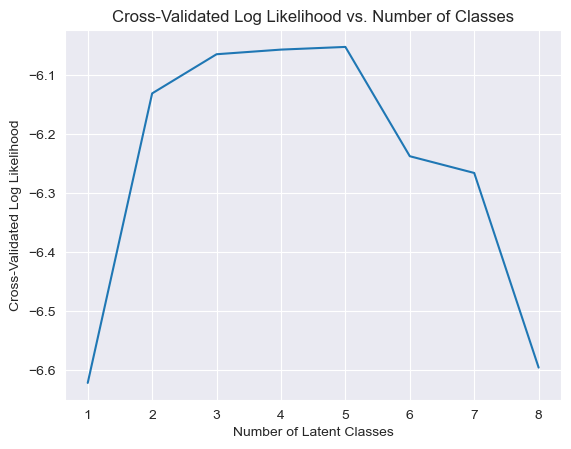

In [82]:
# Higher is better
sns.set_style("darkgrid")
sns.lineplot(data=results[results.param_n_steps == 3], x='param_n_components', y='Val. Log Likelihood',
             #hue='param_n_steps', 
             palette='Dark2')
plt.xlabel('Number of Latent Classes')
plt.ylabel('Cross-Validated Log Likelihood')
plt.title('Cross-Validated Log Likelihood vs. Number of Classes')
plt.savefig('example_fig.jpg', dpi=400)

In [76]:
results[results.param_n_steps == 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_n_steps,params,split0_test_score,split1_test_score,split2_test_score,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,Val. Log Likelihood
2,0.053895,0.011161,0.001411,0.000708,1,3,"{'n_components': 1, 'n_steps': 3}",-7.439440,-7.561778,-6.101180,...,-4.880138,-4.786475,-5.483382,-7.555294,-10.109989,-7.057788,-6.621455,1.570407,22,-6.621455
5,0.097689,0.029704,0.000557,0.000051,2,3,"{'n_components': 2, 'n_steps': 3}",-4.447073,-4.126366,-8.050039,...,-6.278624,-4.901766,-5.288171,-5.892518,-7.939752,-7.331672,-6.131546,1.356915,10,-6.131546
8,0.341186,0.347806,0.000533,0.000070,3,3,"{'n_components': 3, 'n_steps': 3}",-3.923120,-3.438196,-7.136072,...,-5.399285,-4.603753,-5.730356,-7.675984,-7.463109,-8.791409,-6.065289,1.658030,7,-6.065289
11,0.375208,0.178302,0.000520,0.000054,4,3,"{'n_components': 4, 'n_steps': 3}",-3.501595,-3.609912,-7.036350,...,-5.520128,-4.417122,-5.484046,-7.313659,-8.685772,-8.288860,-6.057442,1.751844,4,-6.057442
14,0.633120,0.447445,0.000564,0.000039,5,3,"{'n_components': 5, 'n_steps': 3}",-3.501418,-3.627994,-6.965910,...,-5.786424,-4.821847,-5.694458,-7.079872,-7.589093,-8.926186,-6.052909,1.638365,1,-6.052909
17,1.584230,0.971607,0.001136,0.000487,6,3,"{'n_components': 6, 'n_steps': 3}",-3.469691,-3.512101,-7.380808,...,-6.185417,-5.386471,-5.707224,-7.618241,-7.583648,-8.982447,-6.237857,1.695771,13,-6.237857
20,1.614047,0.875608,0.001471,0.000526,7,3,"{'n_components': 7, 'n_steps': 3}",-3.456739,-3.502718,-7.270610,...,-6.402982,-5.428642,-6.109572,-7.228812,-7.568947,-8.923174,-6.266189,1.649857,16,-6.266189
23,2.904083,1.437714,0.001387,0.000560,8,3,"{'n_components': 8, 'n_steps': 3}",-3.580641,-3.709921,-7.679977,...,-6.516402,-6.286282,-5.956360,-7.165589,-7.093485,-11.215089,-6.595520,2.025841,19,-6.595520


In [68]:
results2 = dict(param_n_components=[], aic=[], bic=[], sabic=[], caic=[], relative_entropy=[])

# Same model and grid as above
for n_comp in range(1,15):
    model = StepMix(n_components=n_comp, n_steps = 2, measurement="binary_nan", verbose=0)
    model.fit(df_cluster)
    results2['param_n_components'].append(n_comp)
    results2['aic'].append(model.aic(df_cluster))
    results2['bic'].append(model.bic(df_cluster))
    results2['sabic'].append(model.sabic(df_cluster))
    results2['caic'].append(model.caic(df_cluster))
    results2['relative_entropy'].append(model.relative_entropy(df_cluster))
    
# Save results to a dataframe
results2 = pd.DataFrame(results2)

Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00, 16.58it/s, max_LL=-3e+4, ma
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:1295: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - entropy / (n_samples * np.log(self.n_components))


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  4.60it/s, max_LL=-2.48e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.92it/s, max_LL=-2.34e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  2.32it/s, max_LL=-2.3e+4, 


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:00<00:00,  1.32it/s, max_LL=-2.26e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:04<00:00,  4.65s/it, max_LL=-2.24e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:02<00:00,  2.61s/it, max_LL=-2.2e+4, 


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:06<00:00,  6.73s/it, max_LL=-2.19e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:10<00:00, 10.54s/it, max_LL=-2.18e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:05<00:00,  5.43s/it, max_LL=-2.16e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:09<00:00,  9.94s/it, max_LL=-2.16e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:12<00:00, 12.22s/it, max_LL=-2.15e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:09<00:00,  9.98s/it, max_LL=-2.14e+4,


Fitting StepMix...


Initializations (n_init) : 100%|█| 1/1 [00:15<00:00, 15.37s/it, max_LL=-2.14e+4,
/Users/ad7203/anaconda3/lib/python3.11/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


In [69]:
results2

,param_n_components,aic,bic,sabic,caic,relative_entropy
0,1,59924.913317,59990.097242,60043.504623,60000.097242,-inf
1,2,49726.633703,49863.519945,49975.675445,49884.519945,0.869133
2,3,46857.339774,47065.928333,47236.831952,47097.928333,0.866081
3,4,46103.128665,46383.419541,46613.071279,46426.419541,0.824060
4,5,45251.055041,45603.048234,45891.448091,45657.048234,0.885203
5,6,44832.074594,45255.770104,45602.918080,45320.770104,0.848852
6,7,44176.223163,44671.620991,45077.517085,44747.620991,0.880946
7,8,44008.188897,44575.289042,45039.933255,44662.289042,0.848047
8,9,43752.965279,44391.767741,44915.160074,44489.767741,0.887471
9,10,43441.472997,44151.977777,44734.118228,44260.977777,0.894818


/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_59925/3163944272.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=results2, x='param_n_components', y='caic',
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='param_n_components', ylabel='caic'>

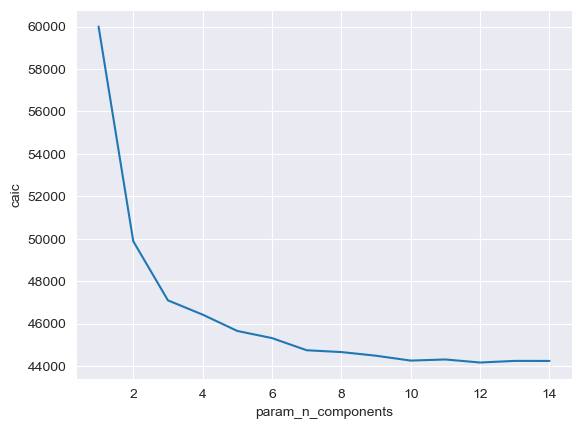

In [70]:
# Lower is better
sns.lineplot(data=results2, x='param_n_components', y='caic',
              palette='Dark2')

/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_59925/1444061319.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=results2, x='param_n_components', y='sabic',
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ad7203/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='param_n_components', ylabel='sabic'>

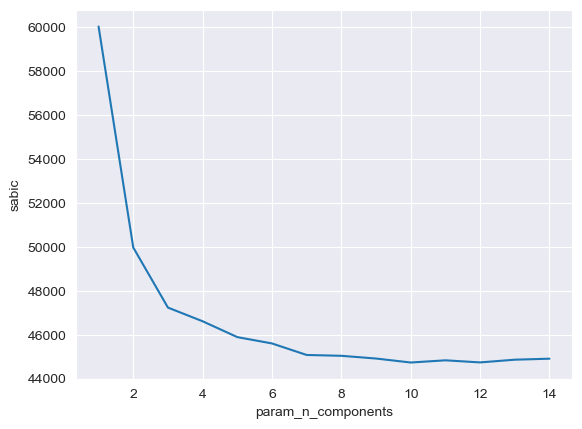

In [74]:
# Lower is better
sns.lineplot(data=results2, x='param_n_components', y='sabic',
              palette='Dark2')

In [54]:
for ii in range(max(df.binary_pred)+1):
    plt.plot(fact[df.binary_pred==ii][:,0], fact[df.binary_pred==ii][:,1], ".")

AttributeError: 'DataFrame' object has no attribute 'binary_pred'

In [ ]:
model.fit(df_cluster, verbose=1)

## demographics

In [21]:
df_study[demo_cols + ['binary_pred']]

,heard_of_988,zK6_Catagory,K6_nervous,k6_hopeless,k6_restless,k6_depressed,k6_effort,k6_worthless,z_Age_cat_fixed,zIncome,zEducation_cat,zReg_flipped_race_ethn,zgender,zreg_flipped_urbanicity,zreg_flipped_political_party,zRegion_census,binary_pred
52,no,no_distress,A little of the time,None of the time,None of the time,None of the time,Most of the time,None of the time,60+,"$10,000 to $24,999",Less than HS,hisp,Female,urban,dem,Northeast,0
53,no,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,60+,"$150,000 or more",Some college,hisp,Male,rural,other,West,0
54,no,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,60+,"$100,000 to $149,999",HS,white,Female,rural,dem,South,0
55,no,no_distress,A little of the time,None of the time,A little of the time,None of the time,None of the time,None of the time,60+,"$25,000 to $49,999",Some college,white,Female,sub-urban,dem,Midwest,0
56,yes,NaN,NaN,None of the time,NaN,None of the time,NaN,None of the time,60+,"$25,000 to $49,999",Some college,white,Male,urban,rep,South,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,yes,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,30-44,"$75,000 to $99,999",Bachelor or higher,white,Male,urban,indy,West,3
5054,no,no_distress,None of the time,None of the time,None of the time,None of the time,None of the time,None of the time,60+,"$10,000 to $24,999",HS,white,Female,rural,dem,South,3
5055,no,moderate_distress,All of the time\t,All of the time\t,Most of the time,None of the time,None of the time,None of the time,60+,"$100,000 to $149,999",Bachelor or higher,white,Male,sub-urban,indy,Midwest,3
5056,no,no_distress,None of the time,None of the time,A little of the time,None of the time,None of the time,None of the time,18-29,"$25,000 to $49,999",HS,white,Male,urban,other,Midwest,3


In [22]:
df_study.groupby('zgender').size()

/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_64648/2833488168.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_study.groupby('zgender').size()


zgender
Female    2408
Male      2598
dtype: int64

In [23]:
df_temp = df_study.copy()
for col in ['K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless']:
    df_temp[col+'_raw'] = np.nan
    df_temp.loc[df_temp[col] == 'All of the time\t',col+'_raw'] = 4
    df_temp.loc[df_temp[col] == 'Most of the time',col+'_raw'] = 3
    df_temp.loc[df_temp[col] == 'Some of the time',col+'_raw'] = 2
    df_temp.loc[df_temp[col] == 'A little of the time',col+'_raw'] = 1
    df_temp.loc[df_temp[col] == 'None of the time',col+'_raw'] = 0
df_temp['kc_score_raw'] = df_temp.K6_nervous_raw + df_temp.k6_hopeless_raw + df_temp.k6_restless_raw + df_temp.k6_depressed_raw + df_temp.k6_effort_raw + df_temp.k6_worthless_raw
df_temp['kc_cat'] = 'Serious'
df_temp.loc[df_temp.kc_score_raw <= 12, 'kc_cat'] = 'Moderate'
df_temp.loc[df_temp.kc_score_raw <=4 , 'kc_cat'] = 'None'
df_temp.groupby('kc_cat').size()

kc_cat
Moderate     921
None        3670
Serious      415
dtype: int64

In [24]:
df_study['pred_cat'] = df_study.binary_pred.astype('category')

mi_cols_cat = ['pred_cat', 'heard_of_988',  'zIncome',
       'zEducation_cat', 'zReg_flipped_race_ethn', 'zgender', 'zreg_flipped_urbanicity', 'zreg_flipped_political_party',
      'zRegion_census', 'z_Age_cat_fixed']
mi_cols_ord = ['K6_nervous_raw', 'k6_hopeless_raw', 'k6_restless_raw',
       'k6_depressed_raw', 'k6_effort_raw', 'k6_worthless_raw']

mi_cols = ['pred_cat', 'heard_of_988',  'zIncome',
       'zEducation_cat', 'zReg_flipped_race_ethn', 'zgender', 'zreg_flipped_urbanicity', 'zreg_flipped_political_party',
      'zRegion_census','K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless', 'z_Age_cat_fixed']

In [25]:
for col in mi_cols_cat:
    df_study[col] = df_study[col].astype('category')

In [26]:
df_study[mi_cols].dtypes

pred_cat                        category
heard_of_988                    category
zIncome                         category
zEducation_cat                  category
zReg_flipped_race_ethn          category
zgender                         category
zreg_flipped_urbanicity         category
zreg_flipped_political_party    category
zRegion_census                  category
K6_nervous                      category
k6_hopeless                     category
k6_restless                     category
k6_depressed                    category
k6_effort                       category
k6_worthless                    category
z_Age_cat_fixed                 category
dtype: object

In [27]:
mi_cols

['pred_cat',
 'heard_of_988',
 'zIncome',
 'zEducation_cat',
 'zReg_flipped_race_ethn',
 'zgender',
 'zreg_flipped_urbanicity',
 'zreg_flipped_political_party',
 'zRegion_census',
 'K6_nervous',
 'k6_hopeless',
 'k6_restless',
 'k6_depressed',
 'k6_effort',
 'k6_worthless',
 'z_Age_cat_fixed']

In [39]:
df_study.groupby('heard_of_988', observed=False).size()

heard_of_988
no     2892
yes    2095
dtype: int64

In [28]:
import miceforest as mf

In [29]:
kds = mf.ImputationKernel(
  df_study[mi_cols],
  save_all_iterations=True,
  datasets = 10,
  random_state=1991
)

kds.mice(3)

In [30]:
kds.dataset_count()

10

In [31]:
# percent in each group
cols = [0, 1, 2, 3, 4]

coefs = pd.DataFrame([], columns = cols)
errs = pd.DataFrame([], columns = cols)


for d in range(kds.dataset_count()):
    df_temp = kds.complete_data(dataset = d).copy()
    for col in ['K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless']:
        df_temp[col+'_raw'] = np.nan
        df_temp.loc[df_temp[col] == 'All of the time\t',col+'_raw'] = 4
        df_temp.loc[df_temp[col] == 'Most of the time',col+'_raw'] = 3
        df_temp.loc[df_temp[col] == 'Some of the time',col+'_raw'] = 2
        df_temp.loc[df_temp[col] == 'A little of the time',col+'_raw'] = 1
        df_temp.loc[df_temp[col] == 'None of the time',col+'_raw'] = 0
    df_temp['kc_score_raw'] = df_temp.K6_nervous_raw + df_temp.k6_hopeless_raw + df_temp.k6_restless_raw + df_temp.k6_depressed_raw + df_temp.k6_effort_raw + df_temp.k6_worthless_raw
    df_temp['kc_cat'] = 'Serious'
    df_temp.loc[df_temp.kc_score_raw <= 12, 'kc_cat'] = 'Moderate'
    df_temp.loc[df_temp.kc_score_raw <= 4, 'kc_cat'] = 'None'
    df_temp['weight'] = df_study['zweight_final']
    df_temp['const'] = 1
    
    cs = []
    stderrs = []
    for val in cols:
        y = (df_temp.pred_cat == val).astype(int)
        X = df_temp.const
    
        mod = sm.WLS(
              endog=y,
                exog=X,
              weights = df_temp['weight'])
        res = mod.fit()
        res.summary2()

        vals = res.summary2().tables[1]
        cs = cs + [vals['Coef.'].iloc[0]]
        stderrs = stderrs + [vals['Std.Err.'].iloc[0]]
    
    coefs.loc[d] = cs
    errs.loc[d] = stderrs

In [32]:
pd.DataFrame(round(coefs.mean() * 100, 1).astype(str) + '% ± ' + round((((errs.mean())**2 + ((1 + 1/10) * 9 / 10 * errs.std())**2)**0.5)*196,1).astype(str) + '%')

,0
0,23.4% ± 1.2%
1,20.7% ± 1.1%
2,13.2% ± 0.9%
3,17.1% ± 1.0%
4,25.5% ± 1.2%


In [33]:
demos = pd.DataFrame([['heard_of_988','yes'], 
                      ['heard_of_988','no'], 
 ['kc_cat','Serious'],
 ['kc_cat','Moderate'],
 ['kc_cat','None'],
 ['z_Age_cat_fixed','18-29'],
 ['z_Age_cat_fixed','30-44'],
 ['z_Age_cat_fixed','45-59'],
 ['z_Age_cat_fixed','60+'],
 ['zIncome','Under $10,000'],
 [ 'zIncome','$10,000 to $24,999'],
 ['zIncome','$25,000 to $49,999'],
 ['zIncome','$50,000 to $74,999'],
 ['zIncome','$75,000 to $99,999'],
 ['zIncome','$100,000 to $149,999'],
 ['zIncome','$150,000 or more'],
 ['zEducation_cat','Less than HS'],
 ['zEducation_cat','HS'],
 ['zEducation_cat','Some college'],
 ['zEducation_cat','Bachelor or higher'],
 ['zReg_flipped_race_ethn','black'],
 ['zReg_flipped_race_ethn','hisp'],
 ['zReg_flipped_race_ethn','two more race'],
 ['zReg_flipped_race_ethn','other race'],
 ['zReg_flipped_race_ethn','white'],
 ['zgender','Female'],
 ['zgender','Male'],
 ['zreg_flipped_urbanicity','urban'],
 ['zreg_flipped_urbanicity','sub-urban'],
 ['zreg_flipped_urbanicity','rural'],
 ['zreg_flipped_political_party','dem'],
 ['zreg_flipped_political_party','indy'],
 ['zreg_flipped_political_party','other'],
 ['zreg_flipped_political_party','rep'],
 ['zRegion_census','Midwest'],
 ['zRegion_census','Northeast'],
 ['zRegion_census','South'],
 ['zRegion_census','West']], columns=['feature', 'value'])

In [34]:
# demographics for each group
# specify group number, or use "all"
group = 'all'

coefs = pd.DataFrame([], columns = list(demos.feature + ' : ' + demos.value))
errs = pd.DataFrame([], columns = list(demos.feature + ' : ' + demos.value))


for d in range(kds.dataset_count()):
    df_temp = kds.complete_data(dataset = d).copy()
    if group != "all":
        df_temp = df_temp[df_temp.pred_cat == group].copy()
    
    for col in ['K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless']:
        df_temp[col+'_raw'] = np.nan
        df_temp.loc[df_temp[col] == 'All of the time\t',col+'_raw'] = 5
        df_temp.loc[df_temp[col] == 'Most of the time',col+'_raw'] = 4
        df_temp.loc[df_temp[col] == 'Some of the time',col+'_raw'] = 3
        df_temp.loc[df_temp[col] == 'A little of the time',col+'_raw'] = 2
        df_temp.loc[df_temp[col] == 'None of the time',col+'_raw'] = 1
    df_temp['kc_score_raw'] = df_temp.K6_nervous_raw + df_temp.k6_hopeless_raw + df_temp.k6_restless_raw + df_temp.k6_depressed_raw + df_temp.k6_effort_raw + df_temp.k6_worthless_raw
    df_temp['kc_cat'] = 'Serious'
    df_temp.loc[df_temp.kc_score_raw < 19, 'kc_cat'] = 'Moderate'
    df_temp.loc[df_temp.kc_score_raw < 11, 'kc_cat'] = 'None'
    df_temp['weight'] = df_study['zweight_final']
    df_temp['const'] = 1
    
    cs = []
    stderrs = []
    for ii in range(len(demos)):
        y = (df_temp[demos.feature[ii]] == demos.value[ii]).astype(int)
        X = df_temp.const
    
        mod = sm.WLS(
              endog=y,
                exog=X,
              weights = df_temp['weight'])
        res = mod.fit()
        #res.summary2()

        vals = res.summary2().tables[1]
        cs = cs + [vals['Coef.'].iloc[0]]
        stderrs = stderrs + [vals['Std.Err.'].iloc[0]]
    
    coefs.loc[d] = cs
    errs.loc[d] = stderrs

In [35]:
pd.DataFrame(round(coefs.mean() * 100, 1).astype(str) + '% ± ' + round((((errs.mean())**2 + ((1 + 1/10) * 9 / 10 * errs.std())**2)**0.5)*196,1).astype(str) + '%')

,0
heard_of_988 : yes,41.8% ± 1.4%
heard_of_988 : no,58.2% ± 1.4%
kc_cat : Serious,7.8% ± 0.7%
kc_cat : Moderate,20.3% ± 1.1%
kc_cat : None,71.8% ± 1.2%
z_Age_cat_fixed : 18-29,19.8% ± 1.1%
z_Age_cat_fixed : 30-44,25.9% ± 1.2%
z_Age_cat_fixed : 45-59,24.1% ± 1.2%
z_Age_cat_fixed : 60+,30.2% ± 1.3%
"zIncome : Under $10,000",3.4% ± 0.5%


In [ ]:
# % "very likely to reach out" cut by demographics

In [40]:
demos = pd.DataFrame([['all', 'all'],
    ['heard_of_988','yes'], 
    ['heard_of_988','no'], 
 ['kc_cat','Serious'],
 ['kc_cat','Moderate'],
 ['kc_cat','None'],
 ['z_Age_cat_fixed','18-29'],
 ['z_Age_cat_fixed','30-44'],
 ['z_Age_cat_fixed','45-59'],
 ['z_Age_cat_fixed','60+'],
 ['zIncome','Under $10,000'],
 [ 'zIncome','$10,000 to $24,999'],
 ['zIncome','$25,000 to $49,999'],
 ['zIncome','$50,000 to $74,999'],
 ['zIncome','$75,000 to $99,999'],
 ['zIncome','$100,000 to $149,999'],
 ['zIncome','$150,000 or more'],
 ['zEducation_cat','Less than HS'],
 ['zEducation_cat','HS'],
 ['zEducation_cat','Some college'],
 ['zEducation_cat','Bachelor or higher'],
 ['zReg_flipped_race_ethn','black'],
 ['zReg_flipped_race_ethn','hisp'],
 ['zReg_flipped_race_ethn','two more race'],
 ['zReg_flipped_race_ethn','other race'],
 ['zReg_flipped_race_ethn','white'],
 ['zgender','Female'],
 ['zgender','Male'],
 ['zreg_flipped_urbanicity','urban'],
 ['zreg_flipped_urbanicity','sub-urban'],
 ['zreg_flipped_urbanicity','rural'],
 ['zreg_flipped_political_party','dem'],
 ['zreg_flipped_political_party','indy'],
 ['zreg_flipped_political_party','other'],
 ['zreg_flipped_political_party','rep'],
 ['zRegion_census','Midwest'],
 ['zRegion_census','Northeast'],
 ['zRegion_census','South'],
 ['zRegion_census','West']], columns=['feature', 'value'])

source_cols = ['Y_6_7_Reach_out_988',
       'Y_6_7_Reach_out_OTHER_crisisline', 'Y_6_7_Reach_out_MH_prof',
       'Y_6_7_Reach_out_friend_fam', 'Y_6_7_Reach_out_religious_network',
       'N_1_2_Reach_out_988', 'N_1_2_Reach_out_OTHER_crisisline',
       'N_1_2_Reach_out_MH_prof', 'N_1_2_Reach_out_friend_fam',
       'N_1_2_Reach_out_religious_network']

kds = mf.ImputationKernel(
  df_study[mi_cols + source_cols],
  save_all_iterations=True,
  datasets = 10,
  random_state=1991
)

kds.mice(3)


In [41]:
# demographics for each group
# specify source ['Y_6_7_Reach_out_988',
#       'Y_6_7_Reach_out_OTHER_crisisline', 'Y_6_7_Reach_out_MH_prof',
#       'Y_6_7_Reach_out_friend_fam', 'Y_6_7_Reach_out_religious_network',
#       'N_1_2_Reach_out_988', 'N_1_2_Reach_out_OTHER_crisisline',
#       'N_1_2_Reach_out_MH_prof', 'N_1_2_Reach_out_friend_fam',
#       'N_1_2_Reach_out_religious_network']

source = source_cols[9]

coefs = pd.DataFrame([], columns = list(demos.feature + ' : ' + demos.value))
errs = pd.DataFrame([], columns = list(demos.feature + ' : ' + demos.value))


for d in range(kds.dataset_count()):
    df_temp = kds.complete_data(dataset = d).copy()
    
    for col in ['K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless']:
        df_temp[col+'_raw'] = np.nan
        df_temp.loc[df_temp[col] == 'All of the time\t',col+'_raw'] = 5
        df_temp.loc[df_temp[col] == 'Most of the time',col+'_raw'] = 4
        df_temp.loc[df_temp[col] == 'Some of the time',col+'_raw'] = 3
        df_temp.loc[df_temp[col] == 'A little of the time',col+'_raw'] = 2
        df_temp.loc[df_temp[col] == 'None of the time',col+'_raw'] = 1
    df_temp['kc_score_raw'] = df_temp.K6_nervous_raw + df_temp.k6_hopeless_raw + df_temp.k6_restless_raw + df_temp.k6_depressed_raw + df_temp.k6_effort_raw + df_temp.k6_worthless_raw
    df_temp['kc_cat'] = 'Serious'
    df_temp.loc[df_temp.kc_score_raw < 19, 'kc_cat'] = 'Moderate'
    df_temp.loc[df_temp.kc_score_raw < 11, 'kc_cat'] = 'None'
    df_temp['weight'] = df_study['zweight_final']
    df_temp['const'] = 1
    
    cs = []
    stderrs = []
    for ii in range(len(demos)):
        
        df_temp2 = df_temp.copy()
        if demos.feature[ii] != 'all':
            df_temp2 = df_temp2[df_temp2[demos.feature[ii]] == demos.value[ii]].copy()
            
        y = (df_temp2[source] == 'yes').astype(int)
        X = df_temp2.const
    
        mod = sm.WLS(
              endog=y,
                exog=X,
              weights = df_temp2['weight'])
        res = mod.fit()
        #res.summary2()

        vals = res.summary2().tables[1]
        cs = cs + [vals['Coef.'].iloc[0]]
        stderrs = stderrs + [vals['Std.Err.'].iloc[0]]
    
    coefs.loc[d] = cs
    errs.loc[d] = stderrs

In [42]:
pd.DataFrame(round(coefs.mean() * 100, 1).astype(str) + '% ± ' + round((((errs.mean())**2 + ((1 + 1/10) * 9 / 10 * errs.std())**2)**0.5)*196,1).astype(str) + '%')

,0
all : all,57.6% ± 1.4%
heard_of_988 : yes,57.8% ± 2.1%
heard_of_988 : no,57.5% ± 1.8%
kc_cat : Serious,66.9% ± 5.1%
kc_cat : Moderate,61.3% ± 3.1%
kc_cat : None,55.6% ± 1.6%
z_Age_cat_fixed : 18-29,62.8% ± 3.9%
z_Age_cat_fixed : 30-44,61.3% ± 2.8%
z_Age_cat_fixed : 45-59,54.7% ± 2.7%
z_Age_cat_fixed : 60+,53.4% ± 2.2%


## multivariable model

In [51]:
group_val = 4

cols = ['Intercept',
 "C(heard_of_988, Treatment(reference='no'))[T.yes]",       
 "C(kc_cat, Treatment(reference='None'))[T.Moderate]",
 "C(kc_cat, Treatment(reference='None'))[T.Serious]",
 "C(z_Age_cat_fixed, Treatment(reference='60+'))[T.18-29]",
 "C(z_Age_cat_fixed, Treatment(reference='60+'))[T.30-44]",
 "C(z_Age_cat_fixed, Treatment(reference='60+'))[T.45-59]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.$10,000 to $24,999]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.$100,000 to $149,999]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.$25,000 to $49,999]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.$50,000 to $74,999]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.$75,000 to $99,999]",
 "C(zIncome, Treatment(reference='$150,000 or more'))[T.Under $10,000]",
 "C(zEducation_cat, Treatment(reference='Bachelor or higher'))[T.HS]",
 "C(zEducation_cat, Treatment(reference='Bachelor or higher'))[T.Less than HS]",
 "C(zEducation_cat, Treatment(reference='Bachelor or higher'))[T.Some college]",
 "C(zReg_flipped_race_ethn, Treatment(reference='white'))[T.black]",
 "C(zReg_flipped_race_ethn, Treatment(reference='white'))[T.hisp]",
 "C(zReg_flipped_race_ethn, Treatment(reference='white'))[T.other race]",
 "C(zReg_flipped_race_ethn, Treatment(reference='white'))[T.two more race]",
 "C(zgender, Treatment(reference='Male'))[T.Female]",
 "C(zreg_flipped_urbanicity, Treatment(reference='rural'))[T.sub-urban]",
 "C(zreg_flipped_urbanicity, Treatment(reference='rural'))[T.urban]",
 "C(zreg_flipped_political_party, Treatment(reference='rep'))[T.dem]",
 "C(zreg_flipped_political_party, Treatment(reference='rep'))[T.indy]",
 "C(zreg_flipped_political_party, Treatment(reference='rep'))[T.other]",
 "C(zRegion_census, Treatment(reference='West'))[T.Midwest]",
 "C(zRegion_census, Treatment(reference='West'))[T.Northeast]",
 "C(zRegion_census, Treatment(reference='West'))[T.South]"]

coefs = pd.DataFrame([], columns = cols)
errs = pd.DataFrame([], columns = cols)

for d in range(kds.dataset_count()):
    df_temp = kds.complete_data(dataset = d).copy()

    for col in ['K6_nervous', 'k6_hopeless', 'k6_restless', 'k6_depressed', 'k6_effort', 'k6_worthless']:
        df_temp[col+'_raw'] = np.nan
        df_temp.loc[df_temp[col] == 'All of the time\t',col+'_raw'] = 5
        df_temp.loc[df_temp[col] == 'Most of the time',col+'_raw'] = 4
        df_temp.loc[df_temp[col] == 'Some of the time',col+'_raw'] = 3
        df_temp.loc[df_temp[col] == 'A little of the time',col+'_raw'] = 2
        df_temp.loc[df_temp[col] == 'None of the time',col+'_raw'] = 1
    df_temp['kc_score_raw'] = df_temp.K6_nervous_raw + df_temp.k6_hopeless_raw + df_temp.k6_restless_raw + df_temp.k6_depressed_raw + df_temp.k6_effort_raw + df_temp.k6_worthless_raw
    df_temp['kc_cat'] = 'Serious'
    df_temp.loc[df_temp.kc_score_raw < 19, 'kc_cat'] = 'Moderate'
    df_temp.loc[df_temp.kc_score_raw < 11, 'kc_cat'] = 'None'
    df_temp['weight'] = df_study['zweight_final']
    df_temp['const'] = 1

    df_temp['group_member'] = (df_temp.pred_cat == group_val).astype(int)

    formula = 'group_member ~ ' + ' + '.join (
                                  ['C(kc_cat,Treatment(reference=\'None\'))',
                                   'C(heard_of_988, Treatment(reference=\'no\'))',
                                   'C(z_Age_cat_fixed,Treatment(reference=\'60+\'))',
                                   'C(zIncome,Treatment(reference=\'$150,000 or more\'))',
                                   'C(zEducation_cat,Treatment(reference=\'Bachelor or higher\'))',
                                   'C(zReg_flipped_race_ethn,Treatment(reference=\'white\'))',
                                   'C(zgender,Treatment(reference=\'Male\'))',
                                   'C(zreg_flipped_urbanicity,Treatment(reference=\'rural\'))',
                                   'C(zreg_flipped_political_party,Treatment(reference=\'rep\'))',
                                   'C(zRegion_census,Treatment(reference=\'West\'))'  ])
    mod = smf.glm(
                  formula = formula,
                  data = df_temp,
                  freq_weights = df_temp['weight'],
                  family=sm.families.Binomial())
    res = mod.fit()
    vals = res.summary2().tables[1]
    
    coefs.loc[d] = vals['Coef.']
    errs.loc[d] = vals['Std.Err.']

In [52]:
import scipy.stats as st

coef_mi = coefs.mean()
stderr_mi = ((errs.mean())**2 + ((1 + 1/10) * 9 / 10 * errs.std())**2)**0.5
df_ans= pd.DataFrame(np.round(np.exp(coef_mi),2).astype(str) + ' [' + np.round(np.exp(coef_mi - 1.96 * stderr_mi),2).astype(str) + ', ' + np.round(np.exp(coef_mi + 1.96 * stderr_mi),2).astype(str) + ']', columns = ['aOR'])
df_ans['p'] = np.round((1 - st.norm.cdf(np.abs(coef_mi/stderr_mi))) * 2,4)
df_ans

,aOR,p
Intercept,"0.2 [0.15, 0.28]",0.0000
"C(heard_of_988, Treatment(reference='no'))[T.yes]","1.47 [1.29, 1.69]",0.0000
"C(kc_cat, Treatment(reference='None'))[T.Moderate]","1.12 [0.94, 1.33]",0.2076
"C(kc_cat, Treatment(reference='None'))[T.Serious]","1.37 [1.06, 1.75]",0.0146
"C(z_Age_cat_fixed, Treatment(reference='60+'))[T.18-29]","1.62 [1.33, 1.97]",0.0000
"C(z_Age_cat_fixed, Treatment(reference='60+'))[T.30-44]","1.22 [1.01, 1.47]",0.0388
"C(z_Age_cat_fixed, Treatment(reference='60+'))[T.45-59]","0.99 [0.82, 1.2]",0.9523
"C(zIncome, Treatment(reference='$150,000 or more'))[T.$10,000 to $24,999]","0.76 [0.57, 1.02]",0.0636
"C(zIncome, Treatment(reference='$150,000 or more'))[T.$100,000 to $149,999]","0.95 [0.78, 1.15]",0.5874
"C(zIncome, Treatment(reference='$150,000 or more'))[T.$25,000 to $49,999]","0.63 [0.49, 0.79]",0.0001


array([0.00000000e+00, 2.97410017e-02, 1.10802509e-03, 2.61745673e-07,
       3.64296938e-04, 3.41269523e-01, 7.85693692e-01, 2.67432684e-01,
       5.34478302e-04, 1.83459666e-02, 4.27083431e-01, 7.33619879e-01,
       6.05112071e-01, 5.68741577e-01, 6.71021996e-01, 1.35602813e-08,
       3.07347785e-06, 3.11710055e-01, 6.35444635e-03, 3.20549712e-04,
       7.28229959e-01, 9.78457061e-01, 7.98885202e-01, 1.19129787e-01,
       6.93612418e-01, 2.05536864e-02, 7.61206384e-02, 4.17219640e-04])

In [248]:
' + '.join(['kc_cat',
                               'z_Age_cat_fixed',
                               'zIncome',
                               'zEducation_cat',
                               'zReg_flipped_race_ethn',
                               'zgender',
                               'zreg_flipped_urbanicity',
                               'zreg_flipped_urbanicity',
                               'zRegion_census'])

'kc_cat + z_Age_cat_fixed + zIncome + zEducation_cat + zReg_flipped_race_ethn + zgender + zreg_flipped_urbanicity + zreg_flipped_urbanicity + zRegion_census'

In [221]:
df_test = df_work2[df_work2.YearBirth > 2006][['experience_cases', 'avg_ECMOs_per_case', 'avg_multiple_ECMOs_per_ECMO', 'IsFemale', 
                    'IsInborn', 'BirthWt', 'EGA', 'IsLeft', 'IsPrenatalDx', 'GotCPR', 
                    'LnAPGAR1', 'LnAPGAR5', 'RepairBeforeECMO', 'PatchRepair',
                   'LiverChest',  'DefectB', 'DefectC', 'DefectD', #'NoRepair' ,
                     'survived', 'CtrRand']].copy()

df_test[['PatchRepair','LiverChest',  'DefectB', 'DefectC', 'DefectD']] = df_test[['PatchRepair','LiverChest',  'DefectB', 'DefectC', 'DefectD']].mask(df_work2[df_work2.YearBirth > 2006].NoRepair == 1)
                    
kernel = mf.MultipleImputedKernel(
  data=df_test,
  save_all_iterations=True,
  datasets=10
  #,random_state=1991
)                  

In [222]:
df_test.isna().mean()

experience_cases               0.000000
avg_ECMOs_per_case             0.000000
avg_multiple_ECMOs_per_ECMO    0.000000
IsFemale                       0.000581
IsInborn                       0.001742
BirthWt                        0.002323
EGA                            0.040650
IsLeft                         0.001161
IsPrenatalDx                   0.000000
GotCPR                         0.121370
LnAPGAR1                       0.051103
LnAPGAR5                       0.062137
RepairBeforeECMO               0.000000
PatchRepair                    0.143438
LiverChest                     0.159698
DefectB                        0.169570
DefectC                        0.169570
DefectD                        0.169570
survived                       0.000000
CtrRand                        0.000000
dtype: float64

In [223]:
kernel.mice(10,verbose=False)

In [224]:
#test run with the first completed data set

model1 = 'experience_cases + avg_ECMOs_per_case + avg_multiple_ECMOs_per_ECMO'
model2 = model1 + ' + IsFemale + IsInborn + BirthWt + EGA + IsLeft + IsPrenatalDx + GotCPR + LnAPGAR1 + LnAPGAR5 + RepairBeforeECMO + PatchRepair'
model3 = model2 + ' + LiverChest + DefectB + DefectC + DefectD'# + NoRepair'

mod = smf.gee('survived ~ ' + model3,
              'CtrRand',
              kernel.complete_data(0),
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: GEE
===========================================================================
Model:                   GEE                 AIC:               2292.5265  
Link Function:           identity            BIC:               -12316.0783
Dependent Variable:      survived            Log-Likelihood:    -1127.3    
Date:                    2022-02-08 11:44    LL-Null:           -1247.8    
No. Observations:        1722                Deviance:          373.39     
Df Model:                18                  Pearson chi2:      373.       
Df Residuals:            1703                Scale:             0.21925    
Method:                  IRLS                                              
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    0.5431   0.0299 18.1337 0.0000  0.4844  0.6018
experience_cases             0.0042   0.0040  1.0380 0.2993 -0.0037  0.0121
avg_ECMOs_per_case           0.3474   0.2132  1.6297 0.1032 -0.0704  0.7653
avg_multiple_ECMOs_per_ECMO  0.5127   0.4130  1.2415 0.2144 -0.2967  1.3221
IsFemale                     0.0009   0.0217  0.0428 0.9658 -0.0415  0.0434
IsInborn                     0.0394   0.0345  1.1397 0.2544 -0.0283  0.1071
BirthWt                      0.0931   0.0230  4.0550 0.0001  0.0481  0.1381
EGA                          0.0059   0.0083  0.7106 0.4773 -0.0103  0.0221
IsLeft                      -0.1098   0.0298 -3.6843 0.0002 -0.1682 -0.0514
IsPrenatalDx                -0.1154   0.0331 -3.4884 0.0005 -0.1802 -0.0505
GotCPR                      -0.0869   0.0414 -2.1018 0.0356 -0.1680 -0.0059
LnAPGAR1                     0.0700   0.0257  2.7264 0.0064  0.0197  0.1204
LnAPGAR5                     0.0930   0.0395  2.3563 0.0185  0.0156  0.1704
RepairBeforeECMO             0.0470   0.0333  1.4117 0.1580 -0.0183  0.1123
PatchRepair                 -0.1112   0.0556 -1.9998 0.0455 -0.2202 -0.0022
LiverChest                  -0.0868   0.0294 -2.9483 0.0032 -0.1445 -0.0291
DefectB                     -0.0011   0.0623 -0.0179 0.9857 -0.1232  0.1210
DefectC                     -0.0987   0.0840 -1.1749 0.2400 -0.2633  0.0659
DefectD                     -0.1886   0.0883 -2.1369 0.0326 -0.3617 -0.0156
===========================================================================

"""

In [227]:
#now do all 10 completed datasets at once

model1 = 'experience_cases + avg_ECMOs_per_case + avg_multiple_ECMOs_per_ECMO'
model2 = model1 + ' + IsFemale + IsInborn + BirthWt + EGA + IsLeft + IsPrenatalDx + GotCPR + LnAPGAR1 + LnAPGAR5 + RepairBeforeECMO + PatchRepair'
model3 = model2 + ' + LiverChest + DefectB + DefectC + DefectD'# + NoRepair'

cols = ['Intercept', 'experience_cases', 'avg_ECMOs_per_case',
       'avg_multiple_ECMOs_per_ECMO', 'IsFemale', 'IsInborn', 'BirthWt', 'EGA',
       'IsLeft', 'IsPrenatalDx', 'GotCPR', 'LnAPGAR1', 'LnAPGAR5',
       'RepairBeforeECMO', 'PatchRepair',
        'LiverChest',  'DefectB', 'DefectC', 'DefectD'#, 'NoRepair' 
       ]

tester = pd.DataFrame(np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0#,0
                                ]]), columns = ['experience_cases', 'avg_ECMOs_per_case',
       'avg_multiple_ECMOs_per_ECMO', 'IsFemale', 'IsInborn', 'BirthWt', 'EGA',
       'IsLeft', 'IsPrenatalDx', 'GotCPR', 'LnAPGAR1', 'LnAPGAR5',
       'RepairBeforeECMO', 'PatchRepair', 'LiverChest',  'DefectB', 'DefectC', 'DefectD'#, 'NoRepair' 
                                                                                     ])

coefs = pd.DataFrame([], columns = cols)
errs = pd.DataFrame([], columns = cols)
preds = []
pred_ses = []


for d in range(kernel.dataset_count()):
    comp_dat = kernel.complete_data(d)
    mod = smf.gee('survived ~ ' + model3,
              'CtrRand',
              comp_dat,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())
    res = mod.fit()

    vals = res.summary2().tables[1]
    predic = res.get_prediction(tester).summary_frame(alpha=.05)
    
    coefs.loc[d] = vals['Coef.']
    errs.loc[d] = vals['Std.Err.']
    preds = preds + [predic['mean'].values[0]]
    pred_ses = pred_ses + [predic['mean_se'].values[0]]


In [237]:
df_mi_ans = pd.DataFrame(coefs.mean(), columns=['est'])

In [238]:
df_mi_ans['std_err'] = pd.DataFrame((((errs.mean())**2 + ((1 + 1/10) * 9 / 10 * errs.std())**2)**0.5))

In [239]:
df_mi_ans['z'] = df_mi_ans.est / df_mi_ans.std_err

In [251]:
import scipy.stats as st
df_mi_ans['p'] = (1 - st.norm.cdf(np.abs(df_mi_ans.z))) * 2

In [252]:
df_mi_ans

,est,std_err,z,p
Intercept,0.541368,0.030234,17.905973,0.000000
experience_cases,0.003902,0.004029,0.968450,0.332820
avg_ECMOs_per_case,0.338140,0.215965,1.565720,0.117414
avg_multiple_ECMOs_per_ECMO,0.538112,0.415353,1.295554,0.195129
IsFemale,0.001433,0.021910,0.065387,0.947866
IsInborn,0.037655,0.035071,1.073682,0.282965
BirthWt,0.089823,0.023757,3.780849,0.000156
EGA,0.007031,0.008421,0.834981,0.403728
IsLeft,-0.106054,0.030036,-3.530823,0.000414
IsPrenatalDx,-0.117671,0.033012,-3.564502,0.000365
